# NO SMOKE brightness temperature 
- using the data from laura that I downloaded with the brightness temperature script 
- download data in terminal 
- to get different days, have to change the script 

## No Smoke Case
- June 15 18 - 23 UTC 
- 110o W → 117o W
- 53o C→ 60o N 
- T-storm traveling quickly


## imports

In [1]:
import os
import awscli as aws
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date 
from datetime import time
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry

import matplotlib.pyplot as plt
import xarray 
import scipy.stats as ss 
import metpy  
import os
import h5py    
from pyhdf import SD
from mpl_toolkits.basemap import Basemap
import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import time
import calendar
from matplotlib.patches import Polygon
from netCDF4 import Dataset # Import the NetCDF Python interface
import netCDF4 as nc
import geopandas as gpd
from shapely.geometry import Point, Polygon
import bottleneck
import shapely
import dask
import nco
from sklearn.neighbors import NearestNeighbors
from math import radians, cos, sin, asin, sqrt
from textwrap import wrap
import matplotlib.patches as mpatches
import matplotlib.gridspec as grd
from matplotlib.ticker import LogFormatter 
import matplotlib.ticker as ticker


from pyproj import _proj
from pyproj.utils import _convertback, _copytobuffer
import pysplit
import cfgrib

## functions

### convert x/y to lat/lon with netcdf : project_abi(ds)

In [2]:
#FUNCTION:

#IN: an nc dataset from GOES
#OUT LAT/LON in the right projection
def project_abi(ds): #grid edges
    # grab the constants needed to do the projection from GOES grid to lat/lon
    Req = ds.variables['goes_imager_projection'].semi_major_axis
    Rpol = ds.variables['goes_imager_projection'].semi_minor_axis
    lambda_0 = ds.variables['goes_imager_projection'].longitude_of_projection_origin
    lambda_0 = lambda_0*math.pi/180
    Hsat = ds.variables['goes_imager_projection'].perspective_point_height
    H = Hsat+Req
    # projection from GOES grid to lat/lon, following https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    lat_rad_1d = ds['x'][:]
    lon_rad_1d = ds['y'][:]
    [X, Y] = np.meshgrid(lat_rad_1d, lon_rad_1d) # lon is x, lat is y, uses 'xy' indexing by default

    # sin and cos of x and y
    sinx = np.sin(X)
    sinx2 = sinx**2
    siny = np.sin(Y)
    siny2 = siny**2
    cosx = np.cos(X)
    cosx2 = cosx**2
    cosy = np.cos(Y)
    cosy2 = cosy**2

    a = np.power(np.sin(X),2.0) + (np.power(np.cos(X),2.0)*(np.power(np.cos(Y),2.0)+(((Req*Req)/(Rpol*Rpol))*np.power(np.sin(Y),2.0))))
    b = -2.0*H*np.cos(X)*np.cos(Y)
    c = (H**2.0)-(Req**2.0)

    # calculate rs
    rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a

    # calculate sx, sy, sz
    sx = rs*cosx*cosy
    sy = -rs*sinx
    sz = rs*cosx*siny
       
    # calculate lat and lon
    test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))
    lat = np.arctan(test)
    lon = lambda_0 - np.arctan(sy/(H-sx)) # in radians

    lat_deg = lat*180/math.pi
    lon_deg = lon*180/math.pi

    return lat_deg, lon_deg

In [3]:
#Here is the function, you can use it like this: 

ds= nc.Dataset('/data2/edworak/data/BT_nosmoke/202116618/OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc')
ds_lat, ds_lon = project_abi(ds)
#np.unique(ds_lat.data)
np.unique(ds_lon)

/tmp/ipykernel_186682/1134369174.py:33: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a
/tmp/ipykernel_186682/1134369174.py:41: RuntimeWarning: invalid value encountered in sqrt
  test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))


masked_array(data=[-218.27157592773438, -218.26223754882812,
                   -218.18772888183594, ..., -55.73775100708008,
                   -55.72842025756836, --],
             mask=[False, False, False, ..., False, False,  True],
       fill_value=1e+20,
            dtype=float32)

### covert x/y to lat/lon with xarray : calc_latlon(ds)

In [4]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
        
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [5]:
ds= xarray.open_dataset('/data2/edworak/data/BT_nosmoke/202116618/OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc')
ds_latlon = calc_latlon(ds)
ds_latlon

/tmp/ipykernel_186682/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/39)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    lat                                     (y, x) float32 nan nan ... nan nan
    lon                                     (y, x) float32 nan nan ... nan nan
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-15T18:59:54.1Z
    time_coverage_start:       2021-06-15T18:50:32.1Z
    time_coverage_end:         2021-06-15T18:59:39.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        66d60150-f282-48d3-a7eb-f7420a68334e

### grid cell corners: calculate_grid_cell_corners(LAT, LON)

In [6]:
#LAT and LON are 2d arrays
# finds the grid cell corners to make the boxes 
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [7]:
# plug in the transformed lat and lon into grid corners 
grid_corners = calculate_grid_cell_corners(ds_latlon["lat"][:], ds_latlon["lon"][:])
#np.unique(grid_corners[0])
#grid_unique = grid_corners[~np.isnan(grid_corners)]
grid_corners
#returns [0] as lat_corners, [1] as lon_corners 

(<xarray.DataArray 'lat' (y: 5422, x: 5422)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * y        (y) float64 0.1518 0.1517 0.1517 0.1516 ... -0.1517 -0.1517 -0.1518
   * x        (x) float64 -0.1518 -0.1517 -0.1517 ... 0.1517 0.1517 0.1518
     t        datetime64[ns] 2021-06-15T18:55:06.059201024
     y_image  float32 0.0
     x_image  float32 0.0
     lat      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
     lon      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan,
 <xarray.DataArray 'lon' (y: 5422, x: 5422)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan,

### haversine - dist

In [8]:
def dist(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

### haversine - distance between points

In [9]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km


# import GOES files 
OR_ABI-L2-MCMIPC-M3_G16_s20181781922189_e20181781924562_c20181781925075.nc

OR - Indicates the system is operational

ABI - Instrument type

L2 - Level 2 Data

MCMIP - Multichannel Cloud and Moisture Imagery products

c - CONUS file (created every 5 minutes).

M3 - Scan mode

G16 - GOES-16

sYYYYJJJHHMMSSZ - Scan start: 4 digit year, 3 digit day of year (Julian day), hour, minute, second, tenth second

eYYYYJJJHHMMSSZ - Scan end

cYYYYJJJHHMMSSZ - File Creation .nc - NetCDF file extension

# No Smoke Brightness Temp

## folder and file names

In [10]:
# path to file 

# create empty array to add into 
folder_names_unsorted = []
path = '/data2/edworak/data/BT_nosmoke/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted.append(f)
folder_names = sorted(folder_names_unsorted)
folder_names = folder_names[:-1]
folder_names


['202116618', '202116619', '202116620', '202116621', '202116622', '202116623']

In [11]:
file_names_unsorted = []

for i in range(len(folder_names)): 
    file = os.listdir(path + folder_names[i])
    file_names_unsorted.append(file)
file_names = sorted(file_names_unsorted)
file_names

[['OR_ABI-L2-MCMIPF-M6_G17_s20211661810321_e20211661819388_c20211661819542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661830321_e20211661839399_c20211661839541.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661820321_e20211661829388_c20211661829542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661840321_e20211661849388_c20211661849540.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661800321_e20211661809388_c20211661809541.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G17_s20211661920321_e20211661929399_c20211661929539.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661910321_e20211661919399_c20211661919542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661930321_e20211661939399_c20211661939540.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661940321_e20211661949388_c20211661949542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661900321_e20211661909388_c20211661909539.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661950321_e20211661959393_c20211661959543.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G17_s2021166200

In [12]:
goes_data = []

for i in range(0, len(folder_names), 1):
    for j in range(0, len(file_names), 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        goes_data = xarray.open_dataset(FILE)
# goes_data['CMI_C14'][:]
goes_data


<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-15T23:59:54.1Z
    time_coverage_start:       2021-06-15T23:50:31.9Z
    time_coverage_end:         2021-06-15T23:59:39.1Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        f36cb978-e0b6-4593-90d6-12c3404b755d

## merge all netcdf files by time

In [13]:
#File = "/data/edworak/BT_nosmoke/202116618/*.nc"
# ds_18 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116618/*.nc", combine = 'nested', concat_dim="time")
# ds_19 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116619/*.nc", combine = 'nested', concat_dim="time")
# ds_20 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116620/*.nc", combine = 'nested', concat_dim="time")
# ds_21 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116621/*.nc", combine = 'nested', concat_dim="time")
# ds_22 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116622/*.nc", combine = 'nested', concat_dim="time")
# ds_23 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116623/*.nc", combine = 'nested', concat_dim="time")

# save this to data directory 

#ds_18.to_netcdf('/data2/edworak/BT_nosmoke_combined/ds_18.nc')
#ds_23.to_netcdf('/data2/edworak/BT_nosmoke_combined/ds_23.nc')
ds_combined = calc_latlon(xarray.open_dataset('/data2/edworak/data/BT_nosmoke_combined/ds_21.nc'))
ds_combined["CMI_C14"][:]

/tmp/ipykernel_186682/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.DataArray 'CMI_C14' (time: 6, y: 5424, x: 5424)>
[176518656 values with dtype=float32]
Coordinates:
    t        (time) datetime64[ns] ...
  * y        (y) float32 0.1518 0.1518 0.1517 0.1517 ... -0.1517 -0.1518 -0.1518
  * x        (x) float32 -0.1518 -0.1518 -0.1517 ... 0.1517 0.1518 0.1518
    y_image  float32 ...
    x_image  float32 ...
    lat      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lon      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Dimensions without coordinates: time
Attributes:
    long_name:              ABI Cloud and Moisture Imagery brightness tempera...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF_C14

## select lat and lon, convert into celsius
does chat gpt work? 

In [14]:
FILE = '/data2/edworak/data/BT_nosmoke_combined/ds_21.nc'
# FILE = path + file_names[i]
ds_xy = xarray.open_dataset(FILE)
ds_latlon = calc_latlon(ds_xy)

lat_min, lat_max = 53, 60
lon_min, lon_max = -117, -110

lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
goes_data = selected_region['CMI_C14'][:] - 273.15
goes_data.attrs["units"] = "kelvin"
goes_data

# print unique values only
#np.unique(data_celsius)
#goes_data.values

/tmp/ipykernel_186682/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.DataArray 'CMI_C14' (time: 6, y: 168, x: 303)>
array([[[-47.502823, -47.622528, -47.502823, ...,        nan,
                nan,        nan],
        [       nan, -47.442978, -47.442978, ...,        nan,
                nan,        nan],
        [       nan,        nan, -46.784607, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,  21.684662,
          22.103607,        nan],
        [       nan,        nan,        nan, ...,  21.385406,
          21.325531,  21.684662],
        [       nan,        nan,        nan, ...,  21.205841,
          21.145966,  21.145966]],

       [[-44.091324, -44.62999 , -44.929245, ...,        nan,
                nan,        nan],
        [       nan, -44.151184, -44.151184, ...,        nan,
                nan,        nan],
        [       nan,        nan, -43.133713, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,  21.325531,
          21.44522 ,        nan],
        [       nan,        nan,        nan, ...,  21.44522 ,
          21.385406,  21.145966],
        [       nan,        nan,        nan, ...,  21.325531,
          21.325531,  21.265686]],

       [[-43.61252 , -42.714767, -41.99655 , ...,        nan,
                nan,        nan],
        [       nan, -42.834457, -42.35565 , ...,        nan,
                nan,        nan],
        [       nan,        nan, -42.834457, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,  21.325531,
          21.505096,        nan],
        [       nan,        nan,        nan, ...,  21.385406,
          21.684662,  21.325531],
        [       nan,        nan,        nan, ...,  21.44522 ,
          21.44522 ,  21.205841]]], dtype=float32)
Coordinates:
    t        (time) datetime64[ns] ...
  * y        (y) float32 0.1395 0.1395 0.1394 0.1394 ... 0.1303 0.1302 0.1302
  * x        (x) float32 0.02769 0.02775 0.0278 ... 0.04449 0.04455 0.0446
    y_image  float32 0.0
    x_image  float32 0.0
    lat      (y, x) float32 59.98 59.98 59.98 59.99 ... 53.0 53.0 53.0 53.01
    lon      (y, x) float32 -117.0 -116.9 -116.9 -116.8 ... -110.1 -110.1 -110.0
Dimensions without coordinates: time
Attributes:
    units:    kelvin

## change bt into a dataframe

In [15]:
"""# if I can load in BT as one data frame, then can just do this process once to compare 
ds_latlon = calc_latlon(xarray.open_dataset('/data2/edworak/data/BT_nosmoke_combined/ds_21.nc'))

#select by lat/lon region
lat_min, lat_max = 53, 60
lon_min, lon_max = -117, -110

lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

#select CMI_C14 channel anc convert into celsius
goes_data = selected_region['CMI_C14'][:] - 273.15
goes_data.attrs["units"] = "celsius"

#select where brightness temp is below -50 C
# bt_condition = (goes_data <= -50)
# ds_selected = goes_data.where(bt_condition, drop = True)

# Convert the xarray dataarray to a pandas dataframe
df = goes_data.to_dataframe()

df['Date'] = pd.to_datetime(df['t'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute
df['Second'] = df['Date'].dt.second

data = df.loc[:, ("Year","Month","Day", "Hour", "Minute", "Second", "lat", "lon", "CMI_C14")]
data.dropna(inplace = True)

# Add the dataframe to the existing pandas dataframe
#existing_df = pd.read_csv('existing_data.csv')
#result = pd.concat([data_nosmoke, df], axis=1)
data
"""

'# if I can load in BT as one data frame, then can just do this process once to compare \nds_latlon = calc_latlon(xarray.open_dataset(\'/data2/edworak/data/BT_nosmoke_combined/ds_21.nc\'))\n\n#select by lat/lon region\nlat_min, lat_max = 53, 60\nlon_min, lon_max = -117, -110\n\nlat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\nlon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n\nselected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n#select CMI_C14 channel anc convert into celsius\ngoes_data = selected_region[\'CMI_C14\'][:] - 273.15\ngoes_data.attrs["units"] = "celsius"\n\n#select where brightness temp is below -50 C\n# bt_condition = (goes_data <= -50)\n# ds_selected = goes_data.where(bt_condition, drop = True)\n\n# Convert the xarray dataarray to a pandas dataframe\ndf = goes_data.to_dataframe()\n\ndf[\'Date\'] = pd.to_datetime(df[\'t\'])\ndf[\'Year\'] = df[\'Date\'].dt.year\ndf[\'Month\'] = df[\'Date\'].dt.mon

## change brightness temp into dataframe, in for loop

In [16]:
"""# if I can load in BT as one data frame, then can just do this process once to compare 
datasets = ["ds_18", "ds_19", "ds_20", "ds_21", "ds_22", "ds_23"]
path = '/data2/edworak/data/BT_nosmoke_combined/'

for i in range(len(datasets)): 
    ds_latlon = calc_latlon(xarray.open_dataset(path + datasets[i] + '.nc'))

    #select by lat/lon region
    lat_min, lat_max = 53, 60
    lon_min, lon_max = -117, -110
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

    #select CMI_C14 channel anc convert into celsius
    goes_data = selected_region['CMI_C14'][:] - 273.15
    goes_data.attrs["units"] = "celsius"

    # Convert the xarray dataarray to a pandas dataframe
    df = goes_data.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    bt_hourly_df = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
    
#     bt_hourly_df = pd.DataFrame({"year" : df['Date'].dt.year, "month": df['Date'].dt.month,
#                                  "day": df['Date'].dt.day, "hour": df['Date'].dt.hour,
#                                  "minute":df['Date'].dt.minute, "second": df['Date'].dt.second,
#                                  "CMI_C14": CMI_C14})

    bt_hourly_df.dropna(inplace = True)
    #data.set_index(df['Year'])

    # Add the dataframe to the existing pandas dataframe
    #existing_df = pd.read_csv('existing_data.csv')
    #result = pd.concat([data_nosmoke, df], axis=1)
    if i == 0: 
        bt_df = bt_hourly_df
    if i > 0: 
        bt_df = pd.concat([bt_df, bt_hourly_df], axis =0)
    
    # this is only showing the time of the last iteration 
    # have to either append it or combine all datasets for each hour after the fact 
    # it is only saving the last one """

'# if I can load in BT as one data frame, then can just do this process once to compare \ndatasets = ["ds_18", "ds_19", "ds_20", "ds_21", "ds_22", "ds_23"]\npath = \'/data2/edworak/data/BT_nosmoke_combined/\'\n\nfor i in range(len(datasets)): \n    ds_latlon = calc_latlon(xarray.open_dataset(path + datasets[i] + \'.nc\'))\n\n    #select by lat/lon region\n    lat_min, lat_max = 53, 60\n    lon_min, lon_max = -117, -110\n    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n    #select CMI_C14 channel anc convert into celsius\n    goes_data = selected_region[\'CMI_C14\'][:] - 273.15\n    goes_data.attrs["units"] = "celsius"\n\n    # Convert the xarray dataarray to a pandas dataframe\n    df = goes_data.to_dataframe()\n    scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.

In [17]:
# bt_df.to_csv('/data2/edworak/data/bt_df.nc')
# bt_df

nosmoke_bt_df = pd.read_csv('/data2/edworak/data/bt_df.nc')
nosmoke_bt_df

time         y         x  year  month  day  hour  minute  second  \
0          0  0.139524  0.027692  2021      6   15    18       5       5   
1          0  0.139524  0.027748  2021      6   15    18       5       5   
2          0  0.139524  0.027804  2021      6   15    18       5       5   
3          0  0.139524  0.027860  2021      6   15    18       5       5   
4          0  0.139524  0.027916  2021      6   15    18       5       5   
...      ...       ...       ...   ...    ...  ...   ...     ...     ...   
955111     5  0.130228  0.044548  2021      6   15    23      55       5   
955112     5  0.130228  0.044604  2021      6   15    23      55       5   
955113     5  0.130172  0.044492  2021      6   15    23      55       5   
955114     5  0.130172  0.044548  2021      6   15    23      55       5   
955115     5  0.130172  0.044604  2021      6   15    23      55       5   

              lat         lon    CMI_C14  
0       59.977394 -116.979700  -2.854157  
1       59.980545 -116.934790   0.677033  
2       59.983234 -116.890240  -1.776855  
3       59.986390 -116.845310  -6.026276  
4       59.989048 -116.800740  -6.804291  
...           ...         ...        ...  
955111  53.046143 -110.047745  19.470184  
955112  53.048496 -110.008575  19.111053  
955113  53.001804 -110.118774  19.410309  
955114  53.004604 -110.079216  19.470184  
955115  53.007412 -110.039610  19.350464  

[955116 rows x 12 columns]

# No Smoke vaisala lightning data

## load in the data

In [18]:
data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

data_split2

year  month  day  hour  minute second     lat      lon  peak-current  \
0        2021      6    2    22      15     39  58.073 -119.732          14.7   
1        2021      6    2    22      15     40  58.043 -119.737          12.2   
2        2021      6    2    22      19     23  58.060 -118.448         -40.3   
3        2021      6    2    22      19     23  58.060 -118.449         -22.4   
4        2021      6    2    22      19     23  58.059 -118.448          -9.5   
...       ...    ...  ...   ...     ...    ...     ...      ...           ...   
1308797  2021      7   31    23      55     54  52.396 -123.137         -12.6   
1308798  2021      7   31    23      55     54  52.397 -123.148         -17.5   
1308799  2021      7   31    23      55     54  52.334 -123.095          -6.7   
1308800  2021      7   31    23      56     39  52.323 -122.974           2.4   
1308801  2021      7   31    23      59     57  52.412 -123.141           8.0   

        C or G  multi polarity     range  
0            C      0        +  11817.95  
1            C      0        +  11819.49  
2            G      0        -  11818.65  
3            G      0        -  11818.65  
4            G      0        -  11818.68  
...        ...    ...      ...       ...  
1308797      G      0        -  12104.32  
1308798      G      0        -  12104.26  
1308799      G      0        -  12107.33  
1308800      C      0        +  12107.86  
1308801      C      0        +  12103.51  

[1308802 rows x 13 columns]

## no smoke data 

In [19]:
data3 = pd.read_csv("/data2/edworak/data/2021_sc_dN4KG 2.csv", names = ["Date", "Time", "lat", "lon", "peak-current", "C or G"],  delimiter = ",", skiprows = 0)
data3[["year", "month", "day"]] = data3["Date"].str.split("-", expand = True)
data3[["hour", "minute", "second"]] = data3["Time"].str.split(":", expand = True)
data3['year'] = data3['year'].astype('int')
data3['month'] = data3['month'].astype('int')
data3['day'] = data3['day'].astype('int')
data3['hour'] = data3['hour'].astype('int')
data3['minute'] = data3['minute'].astype('int')
data4 = data3[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
data4

year  month  day  hour  minute        second      lat       lon  \
0       2021      6    3     1      29  53.393770496  57.5338 -114.9439   
1       2021      6    3     1      33  13.732214016  57.5340 -114.8918   
2       2021      6    3     1      36  53.836932608  57.7660 -114.8979   
3       2021      6    3     1      36  53.852084992  57.7599 -114.8177   
4       2021      6    3     1      37  55.506334208  57.5209 -114.9984   
...      ...    ...  ...   ...     ...           ...      ...       ...   
553689  2021      7   30    22      56  52.397811712  50.0083 -114.0453   
553690  2021      7   30    22      57  10.679690496  50.0459 -114.0581   
553691  2021      7   30    23       5  30.693505792  50.0448 -113.9876   
553692  2021      7   30    23      47  42.228091392  50.2062 -114.3851   
553693  2021      7   30    23      47  42.229349888  50.1879 -114.4152   

        peak-current C or G  
0               16.5      G  
1               35.4      G  
2               14.0      G  
3                7.4      G  
4                9.8      G  
...              ...    ...  
553689          -5.0      C  
553690          49.8      G  
553691          -3.5      C  
553692          11.3      C  
553693           5.9      C  

[553694 rows x 10 columns]

## concatenate east and west data sets

In [20]:
data_15_east = data4.loc[(data4["day"] == 15) & (data4["hour"] >= 18) & (data4["hour"] <= 23)]
data_15_west = data_split2.loc[(data_split2["day"] == 15) & (data_split2["hour"]>= 18) & (data_split2["hour"]<= 23)]
frames3 = [data_15_east, data_15_west]
data_nosmoke_extra= pd.concat(frames3)
data_nosmoke = data_nosmoke_extra[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
data_nosmoke = data_nosmoke.loc[(data_nosmoke["lat"] >= 53) & (data_nosmoke["lat"] <= 60) & (data_nosmoke["lon"] >= -117) &(data_nosmoke["lon"] <= -110)]
data_nosmoke

year  month  day  hour  minute        second      lat       lon  \
112391  2021      6   15    18       0  01.838311680  54.3720 -114.9640   
112392  2021      6   15    18       0  02.672797952  54.9954 -114.5772   
112393  2021      6   15    18       0  02.675810560  54.9930 -114.5842   
112394  2021      6   15    18       0  02.701090304  54.9968 -114.5735   
112395  2021      6   15    18       0  02.706437888  54.9714 -114.5681   
...      ...    ...  ...   ...     ...           ...      ...       ...   
120253  2021      6   15    23      59            48  59.2990 -115.3530   
120254  2021      6   15    23      59            49  59.3110 -115.2900   
120256  2021      6   15    23      59            54  59.3270 -115.1040   
120257  2021      6   15    23      59            55  53.6360 -115.8750   
120258  2021      6   15    23      59            56  59.9540 -115.5400   

        peak-current C or G  
112391         -12.4      G  
112392          23.1      G  
112393         -87.3      G  
112394         -15.6      C  
112395         -15.6      G  
...              ...    ...  
120253         -15.8      G  
120254           7.0      C  
120256           6.1      C  
120257          11.8      C  
120258         -17.3      G  

[26389 rows x 10 columns]

# PyroCb Brightness Temp and Lightning load in 

## folder and file names

In [21]:
# create empty array to add into 
file_names_unsorted_pyrocb = []

path = '/data2/edworak/data/PyroCb/MCMIPF1/'
file = os.listdir(path)

for f in file: 
    #print(f)
    #print(len(f))
    file_names_unsorted_pyrocb.append(f)
file_names_pyrocb = sorted(file_names_unsorted_pyrocb)

print(len(file_names_unsorted_pyrocb))
file_names_pyrocb

42


['OR_ABI-L2-MCMIPF-M6_G16_s20211820400207_e20211820409521_c20211820410020.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820410207_e20211820419515_c20211820420018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820420207_e20211820429521_c20211820430021.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820430207_e20211820439527_c20211820440018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820440208_e20211820449526_c20211820450018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820450208_e20211820459527_c20211820500020.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820500210_e20211820509529_c20211820510026.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820510210_e20211820519529_c20211820520018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820520210_e20211820529529_c20211820530019.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820530210_e20211820539529_c20211820540018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820540210_e20211820549518_c20211820550021.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820550210_e20211820559529_c20211820600030.nc',
 'OR_ABI-L2-MCMIPF-M6_G17_s20211812300319_e202118123

In [22]:
goes_data_pyrocb = []

for i in range(len(file_names_pyrocb)):
    path = '/data2/edworak/data/PyroCb/MCMIPF1/'
    FILE = path + file_names_pyrocb[i]
   # print(FILE)
    #"goes_"+ filename[i][30:36] = xarray.open_dataset(FILE)
    goes_data_pyrocb = xarray.open_dataset(FILE)
goes_data_pyrocb

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-07-01T03:59:54.4Z
    time_coverage_start:       2021-07-01T03:50:32.0Z
    time_coverage_end:         2021-07-01T03:59:39.2Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        511d834e-1fe8-45e0-b593-299e1c8a725f

## select lat and lon, convert into celsius

In [23]:
path = '/data2/edworak/data/PyroCb/MCMIPF1/'
# FILE = path + file_names[i]
ds_xy = xarray.open_dataset(FILE)
ds_latlon = calc_latlon(ds_xy)

lat_min, lat_max = 51, 53
lon_min, lon_max = -121.5, -119

lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
goes_data_pyrocb = selected_region['CMI_C14'][:] - 273.15
goes_data_pyrocb.attrs["units"] = "celsius"
goes_data_pyrocb

# print unique values only
#np.unique(data_celsius)
#goes_data.values

/tmp/ipykernel_186682/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.DataArray 'CMI_C14' (y: 56, x: 101)>
array([[-57.258484, -57.67746 , -58.216095, ...,        nan,        nan,
               nan],
       [       nan, -57.07895 , -57.318344, ...,        nan,        nan,
               nan],
       [       nan, -56.83954 , -57.01909 , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,  26.113617,  27.131073,
               nan],
       [       nan,        nan,        nan, ...,  26.652252,  26.652252,
               nan],
       [       nan,        nan,        nan, ...,  26.293152,  25.634796,
         26.412872]], dtype=float32)
Coordinates:
    t        datetime64[ns] 2021-07-01T03:55:05.622132992
  * y        (y) float32 0.1311 0.131 0.131 0.1309 ... 0.1282 0.1281 0.128 0.128
  * x        (x) float32 0.02652 0.02657 0.02663 ... 0.032 0.03206 0.03212
    y_image  float32 0.0
    x_image  float32 0.0
    lat      (y, x) float32 52.98 52.98 52.99 52.99 ... 51.0 51.0 51.0 51.01
    lon      (y, x) float32 -121.5 -121.5 -121.4 -121.4 ... -119.1 -119.0 -119.0
Attributes:
    units:    celsius

## change bt into dataframe

In [24]:
"""for i in range(len(file_names_pyrocb)):
    path = '/data2/edworak/data/PyroCb/MCMIPF1/'
    FILE = path + file_names_pyrocb[i]
    print(FILE)
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 51, 53
    lon_min, lon_max = -121.5, -119
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

    #select CMI_C14 channel anc convert into celsius
    goes_data_pyrocb = selected_region['CMI_C14'][:] - 273.15
    goes_data_pyrocb.attrs["units"] = "celsius"

    # Convert the xarray dataarray to a pandas dataframe
    df = goes_data_pyrocb.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    bt_hourly_df_pyrocb = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
    bt_hourly_df_pyrocb.dropna(inplace = True)
    
    if i == 0: 
        bt_df_pyrocb = bt_hourly_df_pyrocb
    if i > 0: 
        bt_df_pyrocb = pd.concat([bt_df_pyrocb, bt_hourly_df_pyrocb], axis =0) """

'for i in range(len(file_names_pyrocb)):\n    path = \'/data2/edworak/data/PyroCb/MCMIPF1/\'\n    FILE = path + file_names_pyrocb[i]\n    print(FILE)\n    ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n    #select by lat/lon region\n    lat_min, lat_max = 51, 53\n    lon_min, lon_max = -121.5, -119\n    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n    #select CMI_C14 channel anc convert into celsius\n    goes_data_pyrocb = selected_region[\'CMI_C14\'][:] - 273.15\n    goes_data_pyrocb.attrs["units"] = "celsius"\n\n    # Convert the xarray dataarray to a pandas dataframe\n    df = goes_data_pyrocb.to_dataframe()\n    scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.%fZ\')\n    \n    df[\'Date\'] = pd.to_datetime(df[\'t\'])\n    df[\'year\'] = df[\'Date\'].dt.

In [25]:
bt_df_pyrocb = pd.read_csv('/data2/edworak/data/bt_df_pyrocb.nc')
bt_df_pyrocb

y         x  year  month  day  hour  minute  second        lat  \
0       0.131068  0.026516  2021      6   30    23       5       5  52.983370   
1       0.131068  0.026572  2021      6   30    23       5       5  52.984740   
2       0.131068  0.026628  2021      6   30    23       5       5  52.986404   
3       0.131068  0.026684  2021      6   30    23       5       5  52.987580   
4       0.131068  0.026740  2021      6   30    23       5       5  52.989246   
...          ...       ...   ...    ...  ...   ...     ...     ...        ...   
116335  0.128044  0.032060  2021      7    1     3      55       5  51.041077   
116336  0.127988  0.031948  2021      7    1     3      55       5  51.000580   
116337  0.127988  0.032004  2021      7    1     3      55       5  51.002155   
116338  0.127988  0.032060  2021      7    1     3      55       5  51.003777   
116339  0.127988  0.032116  2021      7    1     3      55       5  51.005413   

               lon    CMI_C14  
0      -121.493970  21.145966  
1      -121.459590   8.876587  
2      -121.425026  -8.779388  
3      -121.390740 -15.602386  
4      -121.356155 -27.632370  
...            ...        ...  
116335 -119.029610  26.652252  
116336 -119.113260  26.233307  
116337 -119.079790  26.293152  
116338 -119.046265  25.634796  
116339 -119.012726  26.412872  

[116340 rows x 11 columns]

## BT for pyrocb early

In [26]:
# create empty array to add into 
folder_names_unsorted_pyrocbearly = []
path = '/data2/edworak/data/BT_pyrocb_early/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_pyrocbearly.append(f)
folder_names_pyrocbearly = sorted(folder_names_unsorted_pyrocbearly)
folder_names_pyrocbearly = folder_names_pyrocbearly[:-1]
folder_names_pyrocbearly


['202118101', '202118102', '202118103', '202118104']

In [27]:
file_names_unsorted_pyrocbearly = []

for i in range(len(folder_names_pyrocbearly)): 
    file = os.listdir(path + folder_names_pyrocbearly[i])
    file_names_unsorted_pyrocbearly.append(file)
file_names_pyrocbearly = sorted(file_names_unsorted_pyrocbearly)
file_names_pyrocbearly

[['OR_ABI-L2-MCMIPF-M6_G16_s20211810110206_e20211810119526_c20211810120015.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810120206_e20211810129514_c20211810130018.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810140206_e20211810149525_c20211810150017.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810100206_e20211810109525_c20211810110019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810130206_e20211810139526_c20211810140027.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810150206_e20211810159525_c20211810200018.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G16_s20211810230206_e20211810239520_c20211810240017.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810200206_e20211810209520_c20211810210019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810240206_e20211810249520_c20211810250020.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810220206_e20211810229514_c20211810230019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810210206_e20211810219514_c20211810220019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810250206_e20211810259514_c20211810300025.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G16_s2021181033

In [28]:
goes_data_pyrocbearly = []

for i in range(0, len(folder_names_pyrocbearly), 1):
    for j in range(0, len(file_names_pyrocbearly), 1):
        path = '/data2/edworak/data/BT_pyrocb_early/' + folder_names_pyrocbearly[i] + '/'
        FILE = path + file_names_pyrocbearly[i][j]
        goes_data_pyrocbearly = xarray.open_dataset(FILE)
# goes_data['CMI_C14'][:]
goes_data_pyrocbearly


<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-30T04:40:01.9Z
    time_coverage_start:       2021-06-30T04:30:20.6Z
    time_coverage_end:         2021-06-30T04:39:52.0Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        067fad9d-a0b9-40be-a9e7-9986ff075bee

## import vaisala lightning data

In [29]:
data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

data_split2

year  month  day  hour  minute second     lat      lon  peak-current  \
0        2021      6    2    22      15     39  58.073 -119.732          14.7   
1        2021      6    2    22      15     40  58.043 -119.737          12.2   
2        2021      6    2    22      19     23  58.060 -118.448         -40.3   
3        2021      6    2    22      19     23  58.060 -118.449         -22.4   
4        2021      6    2    22      19     23  58.059 -118.448          -9.5   
...       ...    ...  ...   ...     ...    ...     ...      ...           ...   
1308797  2021      7   31    23      55     54  52.396 -123.137         -12.6   
1308798  2021      7   31    23      55     54  52.397 -123.148         -17.5   
1308799  2021      7   31    23      55     54  52.334 -123.095          -6.7   
1308800  2021      7   31    23      56     39  52.323 -122.974           2.4   
1308801  2021      7   31    23      59     57  52.412 -123.141           8.0   

        C or G  multi polarity     range  
0            C      0        +  11817.95  
1            C      0        +  11819.49  
2            G      0        -  11818.65  
3            G      0        -  11818.65  
4            G      0        -  11818.68  
...        ...    ...      ...       ...  
1308797      G      0        -  12104.32  
1308798      G      0        -  12104.26  
1308799      G      0        -  12107.33  
1308800      C      0        +  12107.86  
1308801      C      0        +  12103.51  

[1308802 rows x 13 columns]

In [30]:
data_30late = data_split2.loc[(data_split2["month"] == 6) & (data_split2["day"] == 30) & (data_split2["hour"] >= 23)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3)]
frames1 = [data_30late, data_1]
data_june30= pd.concat(frames1)
data_june30

data_29 = data_split2.loc[(data_split2["month"] == 6) & (data_split2["day"] == 29) & (data_split2["hour"] >= 23)]
data_30early = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"]<= 3)]
frames2 = [data_29, data_30early]
data_june29= pd.concat(frames2)
data_june29

data_july1 = data_split2.loc[(data_split2["month"] == 7) & (data_split2["day"] == 1)]
data_july1
data_june30

year  month  day  hour  minute second     lat      lon  peak-current  \
278250  2021      6   30    23       0     04  51.369 -120.967           5.7   
278251  2021      6   30    23       0     09  57.350 -125.626          12.9   
278252  2021      6   30    23       0     10  57.234 -125.721           7.0   
278253  2021      6   30    23       0     26  51.445 -120.868          -2.7   
278254  2021      6   30    23       0     28  51.363 -120.958          10.6   
...      ...    ...  ...   ...     ...    ...     ...      ...           ...   
333340  2021      7    1     3      59     59  54.043 -122.866           5.7   
333341  2021      7    1     3      59     59  55.689 -121.389          -4.7   
333342  2021      7    1     3      59     59  55.635 -121.403           3.6   
333343  2021      7    1     3      59     59  55.830 -122.753          14.6   
333344  2021      7    1     3      59     59  55.827 -122.752           6.1   

       C or G  multi polarity     range  
278250      C      0        +  12154.35  
278251      C      0        +  11855.29  
278252      C      0        +  11861.22  
278253      C      0        -  12150.69  
278254      C      0        +  12154.65  
...       ...    ...      ...       ...  
333340      C      0        +  12022.85  
333341      G      0        -  11940.09  
333342      C      0        +  11942.83  
333343      G      0        +  11932.96  
333344      C      0        +  11933.11  

[55095 rows x 13 columns]

## pyrocb data

In [31]:
data_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] >= 23) & (data_split2.lon >= -121.5) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -121.5) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
frames = [data_30, data_1]
data_pyrocb= pd.concat(frames)
data_pyrocb = data_pyrocb.drop_duplicates(subset=["lat", "lon", "peak-current"], keep='first')

data_pyrocb

year  month  day  hour  minute second     lat      lon  peak-current  \
278250  2021      6   30    23       0     04  51.369 -120.967           5.7   
278253  2021      6   30    23       0     26  51.445 -120.868          -2.7   
278254  2021      6   30    23       0     28  51.363 -120.958          10.6   
278255  2021      6   30    23       0     28  51.360 -120.975           7.7   
278256  2021      6   30    23       0     43  51.407 -121.011           7.4   
...      ...    ...  ...   ...     ...    ...     ...      ...           ...   
331911  2021      7    1     3      56     42  52.451 -120.730           1.8   
332130  2021      7    1     3      57     16  52.483 -120.679          -2.6   
332131  2021      7    1     3      57     16  52.496 -120.657         -40.2   
332133  2021      7    1     3      57     16  52.495 -120.654          -4.2   
332135  2021      7    1     3      57     16  52.497 -120.656         -14.0   

       C or G  multi polarity     range  
278250      C      0        +  12154.35  
278253      C      0        -  12150.69  
278254      C      0        +  12154.65  
278255      C      0        +  12154.81  
278256      C      0        +  12152.54  
...       ...    ...      ...       ...  
331911      C      0        +  12101.60  
332130      C      0        -  12100.05  
332131      G      0        -  12099.41  
332133      G      0        -  12099.46  
332135      G      0        -  12099.35  

[5595 rows x 13 columns]

# Smoke Brightness Temp and Lightning load in 

### folder and file names

In [32]:
folder_names_unsorted_smoke = []
path = '/data2/edworak/data/BT_smoke/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_smoke.append(f)
folder_names_smoke = sorted(folder_names_unsorted_smoke)
folder_names_smoke = folder_names_smoke[:-2]
folder_names_smoke



['202118008', '202118009', '202118010', '202118011']

In [33]:
file_names_unsorted_smoke = []

for i in range(len(folder_names_smoke)): 
    file = os.listdir(path + folder_names_smoke[i])
    file_names_unsorted_smoke.append(file)
file_names_smoke = sorted(file_names_unsorted_smoke)
file_names_smoke



[['OR_ABI-L2-MCMIPF-M6_G16_s20211800810208_e20211800819527_c20211800820017.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800820208_e20211800829515_c20211800830016.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800840208_e20211800849521_c20211800850018.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800830208_e20211800839527_c20211800840019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800800208_e20211800809521_c20211800810015.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800850208_e20211800859516_c20211800900019.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G16_s20211800910208_e20211800919521_c20211800920027.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800920208_e20211800929522_c20211800930022.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800930208_e20211800939521_c20211800940028.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800940208_e20211800949516_c20211800950027.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800900208_e20211800909526_c20211800910019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211800950208_e20211800959527_c20211801000020.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G16_s2021180100

In [34]:
goes_data_smoke = []

for i in range(0, len(folder_names_smoke), 1):
    for j in range(0, len(file_names_smoke), 1):
        path = '/data2/edworak/data/BT_smoke/' + folder_names_smoke[i] + '/'
        FILE = path + file_names_smoke[i][j]
        goes_data_smoke = xarray.open_dataset(FILE)
# goes_data['CMI_C14'][:]
goes_data_smoke


<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-29T11:40:01.6Z
    time_coverage_start:       2021-06-29T11:30:20.8Z
    time_coverage_end:         2021-06-29T11:39:51.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        4a69d95d-2219-4a41-9a3e-81cb4deb997e

### convert into celsius

In [35]:
"""path = '/data2/edworak/data/BT_smoke/202118008'
# FILE = path + file_names[i]
ds_xy = xarray.open_dataset(FILE)
ds_latlon = calc_latlon(ds_xy)

lat_min, lat_max = 58, 60.5
lon_min, lon_max = -122, -114

lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
goes_data_smoke = selected_region['CMI_C14'][:] - 273.15
goes_data_smoke.attrs["units"] = "celsius"
goes_data_smoke

# print unique values only
#np.unique(data_celsius)
#goes_data.values"""

'path = \'/data2/edworak/data/BT_smoke/202118008\'\n# FILE = path + file_names[i]\nds_xy = xarray.open_dataset(FILE)\nds_latlon = calc_latlon(ds_xy)\n\nlat_min, lat_max = 58, 60.5\nlon_min, lon_max = -122, -114\n\nlat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\nlon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n\nselected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\ngoes_data_smoke = selected_region[\'CMI_C14\'][:] - 273.15\ngoes_data_smoke.attrs["units"] = "celsius"\ngoes_data_smoke\n\n# print unique values only\n#np.unique(data_celsius)\n#goes_data.values'

### change bt into dataframe

In [36]:
"""path = '/data2/edworak/data/BT_smoke/'

for i in range(len(folder_names_smoke)):
    for j in range(len(file_names_smoke)):
        FILE = path + folder_names_smoke[i] + '/' + file_names_smoke[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 58, 60.5
        lon_min, lon_max = -122, -114
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_smoke = selected_region['CMI_C14'][:] - 273.15
        goes_data_smoke.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_smoke.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_smoke = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_smoke.dropna(inplace = True)

        if i == 0: 
            bt_df_smoke = bt_hourly_df_smoke
        if i > 0: 
            bt_df_smoke = pd.concat([bt_df_smoke, bt_hourly_df_smoke], axis =0)"""

'path = \'/data2/edworak/data/BT_smoke/\'\n\nfor i in range(len(folder_names_smoke)):\n    for j in range(len(file_names_smoke)):\n        FILE = path + folder_names_smoke[i] + \'/\' + file_names_smoke[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 58, 60.5\n        lon_min, lon_max = -122, -114\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_smoke = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_smoke.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_smoke.to_dataframe()\n        scan_start = datetime.strptime(ds_latlon.time_cov

In [37]:
# bt_df_smoke.to_csv('/data2/edworak/data/bt_df_smoke.nc')
# bt_df_smoke
bt_df_smoke = pd.read_csv('/data2/edworak/data/bt_df_smoke.nc')
bt_df_smoke

y         x  year  month  day  hour  minute  second        lat  \
0      0.138292 -0.049420  2021      6   29     8      35       6  60.498413   
1      0.138236 -0.049868  2021      6   29     8      35       6  60.494350   
2      0.138236 -0.049812  2021      6   29     8      35       6  60.487100   
3      0.138236 -0.049756  2021      6   29     8      35       6  60.479897   
4      0.138236 -0.049700  2021      6   29     8      35       6  60.473190   
...         ...       ...   ...    ...  ...   ...     ...     ...        ...   
76396  0.134372 -0.061460  2021      6   29    11      35       6  58.036472   
76397  0.134372 -0.061404  2021      6   29    11      35       6  58.028057   
76398  0.134372 -0.061348  2021      6   29    11      35       6  58.019157   
76399  0.134372 -0.061292  2021      6   29    11      35       6  58.010006   
76400  0.134372 -0.061236  2021      6   29    11      35       6  58.001160   

              lon    CMI_C14  
0     -114.041220   9.714508  
1     -114.475586   2.891510  
2     -114.408640   3.549866  
3     -114.341850   6.542389  
4     -114.276140   8.756866  
...           ...        ...  
76396 -121.988740  16.657196  
76397 -121.912620  16.717010  
76398 -121.835510  16.717010  
76399 -121.757970  16.836731  
76400 -121.681310  17.315521  

[76401 rows x 11 columns]

## smoke vaisala data june 29 hours 8 - 12

In [38]:
data_smoke = data_split2.loc[(data_split2["day"] == 29) & (data_split2["hour"] >= 8) & (data_split2["hour"] <= 12) & (data_split2.lon >= -120) & (data_split2.lon <= -114) & (data_split2.lat >= 58) & (data_split2.lat <= 60.5)]
data_smoke

year  month  day  hour  minute second     lat      lon  peak-current  \
201341  2021      6   29     8       0     00  58.611 -118.750         -12.5   
201344  2021      6   29     8       0     01  58.533 -118.816           2.8   
201346  2021      6   29     8       0     02  58.409 -118.127           5.4   
201347  2021      6   29     8       0     02  58.565 -119.037           5.2   
201348  2021      6   29     8       0     02  58.496 -119.290           8.9   
...      ...    ...  ...   ...     ...    ...     ...      ...           ...   
257201  2021      6   29    12      59     56  59.068 -116.387         -17.4   
257202  2021      6   29    12      59     56  59.073 -116.344         -12.4   
257203  2021      6   29    12      59     57  59.411 -118.257           4.9   
257204  2021      6   29    12      59     59  58.794 -115.835         -24.5   
257205  2021      6   29    12      59     59  59.255 -117.035           9.8   

       C or G  multi polarity     range  
201341      G      0        -  11790.05  
201344      C      0        +  11794.09  
201346      C      0        +  11800.50  
201347      C      0        +  11792.42  
201348      C      0        +  11796.02  
...       ...    ...      ...       ...  
257201      G      0        -  11350.50  
257202      C      0        -  11350.31  
257203      C      0        +  11748.29  
257204      G      0        -  11361.26  
257205      C      0        +  11343.13  

[51526 rows x 13 columns]

### whole region june 29 hours 8 - 12 

In [39]:
data_smoke_all = data_split2.loc[(data_split2["day"] == 29) & (data_split2["hour"] >= 8) & (data_split2["hour"] <= 12)]
data_smoke_all

year  month  day  hour  minute second     lat      lon  peak-current  \
201341   2021      6   29     8       0     00  58.611 -118.750         -12.5   
201342   2021      6   29     8       0     01  58.128 -123.625          17.4   
201343   2021      6   29     8       0     01  58.143 -123.594          19.0   
201344   2021      6   29     8       0     01  58.533 -118.816           2.8   
201345   2021      6   29     8       0     02  59.177 -120.477           6.6   
...       ...    ...  ...   ...     ...    ...     ...      ...           ...   
1305982  2021      7   29    10      22     45  54.718 -115.092         -19.7   
1305983  2021      7   29    10      22     46  54.720 -115.088         -17.2   
1305984  2021      7   29    10      24     43  54.796 -115.086          12.5   
1305985  2021      7   29    10      28     22  54.828 -115.064          40.3   
1305986  2021      7   29    10      28     22  54.857 -115.143          13.9   

        C or G  multi polarity     range  
201341       G      0        -  11790.05  
201342       C      0        +  11815.10  
201343       C      0        +  11814.35  
201344       C      0        +  11794.09  
201345       C      0        +  11760.52  
...        ...    ...      ...       ...  
1305982      G      0        -  11518.14  
1305983      G      0        -  11518.06  
1305984      C      0        +  11515.21  
1305985      G      0        +  11514.00  
1305986      C      0        +  11512.92  

[57976 rows x 13 columns]

# Messing with color bars

## discrete color bar

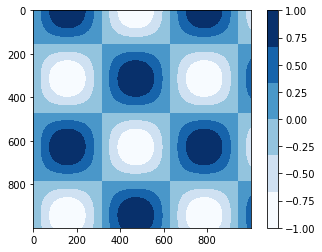

In [40]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

plt.imshow(I)
plt.imshow(I, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar()
plt.clim(-1, 1);

## splitting into color ranges

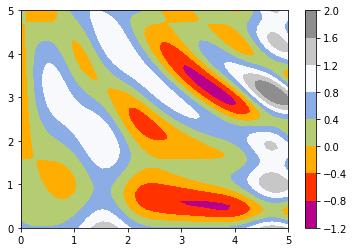

In [41]:
# range is 30 --> -70 : 10 segments 
# 30 - 20 : grey 
# 20 - 10 : dark grey
# 10 - 0 : light grey 
# 0 - -10 : white 
# -10 - -20 : light blue 
# -20 - -30 : 
# -30 - -40 : 
# -40 - -50 : 
# -50 - -60 : 
# -60 - -70 : 
colormap = LinearSegmentedColormap.from_list('custom', 
                                       [(0, 'grey'),
                                        (0.1, 'darkgrey'), 
                                        (0.2, 'lightgrey'), 
                                        (0.3, 'white'),
                                        (0.4,   'lightsteelblue'),
                                        (0.5, 'cornflowerblue'),
                                        (0.6, "yellow"), 
                                        (0.7, "orange"), 
                                        (0.8, "orangered"), 
                                        (0.9, "red"), 
                                        (1.0, "darkviolet") 
                                        ], N=256)



colormap = LinearSegmentedColormap.from_list('custom', 
                                       [(0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "orangered"), 
                                        (0.3, "orange"),
                                        (0.4, "yellow"), 
                                        (0.5, 'cornflowerblue'),
                                        (0.6,   'lightsteelblue'),
                                        (0.7, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (0.9, 'darkgrey'), 
                                        (1.0, 'grey')
                                        ], N=30)


def f(x, y):
    return np.sin(x) ** 8 + np.cos(20 + y * x) * np.cos(y)
 
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
 
fig, ax = plt.subplots()
 
plt.contourf(X, Y, Z, cmap=colormap)
plt.colorbar()
plt.show()


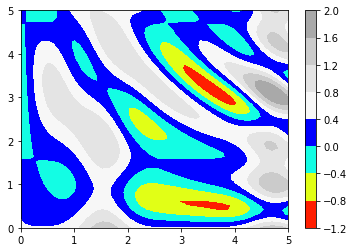

In [42]:
colors_top = cm.get_cmap('jet_r', 256)
colors_bot = cm.get_cmap('Greys', 256)
cmap_grey_red = ListedColormap(
    np.vstack((
        colors_top(np.linspace(0, 1, 256)),
        colors_bot(np.linspace(0, 0.5, 256))
    )), name='GreyRed'
)

def f(x, y):
    return np.sin(x) ** 8 + np.cos(20 + y * x) * np.cos(y)
 
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
 
fig, ax = plt.subplots()
 
plt.contourf(X, Y, Z, cmap=cmap_grey_red)
plt.colorbar()
plt.show()

# NO SMOKE 

## colorbar maps

### map with simple colorbar

In [43]:
def tstorm_subregion_box(ax, subregion):
    geom1 = geometry.box(minx=-110,maxx=-117,miny=53,maxy=60)
    ax.add_geometries([geom1], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='black', linewidth = 4)
    return ax

/tmp/ipykernel_186682/444504536.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


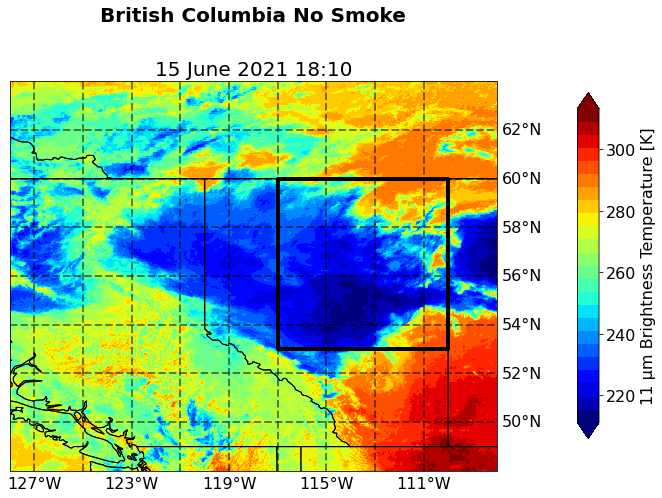

In [44]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-128, -108, 48, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 

        im = ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap=plt.cm.get_cmap("jet", 24))  #, ax = axcax = plt.axes([0.8, 0.15, 0.03, 0.75])
        # , cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.95, 0.1, 0.03, 0.8])
        cbar = plt.colorbar(im, extend='both', cax=cax) #  cax = cax,

        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature [K]', fontsize = 16)
        #plt.clim(190, 330) 

        tstorm_subregion_box(ax, im)

        plt.tight_layout()

        plt.suptitle('British Columbia No Smoke', fontweight='bold', fontsize=20, y = 1.1)
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


### map with split colorbar 

/tmp/ipykernel_186682/482434197.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


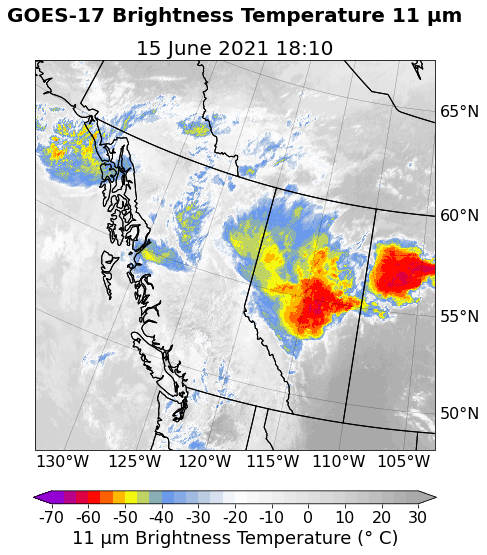

In [45]:
fig = plt.figure(figsize=(8, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        #pc = ccrs.PlateCarree()
        pc = ccrs.LambertConformal()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
       # ax.set_extent([-128, -108, 48, 64], crs=pc)
        #ax.set_extent([-135, -105, 48, 64], ccrs.Geodetic())
        ax.set_extent([-135, -105, 48, 64], ccrs.PlateCarree())

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'


       ## gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)
        gl = ax.gridlines(draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)

#         gl.xlines = True
#       #  gl.xlocator = mticker.FixedLocator([ -127, -125, -123, -121, -119, -117, -115, -113, -111, -109, -107, -105])
        gl.xlocator = mticker.FixedLocator([ -130,  -125,  -120,  -115,  -110, -105])

        gl.ylocator = mticker.FixedLocator([50,  55, 60, 65])
        gl.left_labels = gl.top_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'rotation': 0, 'size': 16, 'color': 'black'}
        gl.ylabel_style = {'rotation': 0, 'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
#         colors_top = cm.get_cmap('plasma', 30)
#         colors_bot = cm.get_cmap('Greys', 30)
#         cmap_grey_rainbow = ListedColormap(np.vstack((colors_top(np.linspace(0,0.8, 30)), 
#                                            colors_bot(np.linspace(0, 0.7, 30)))), name='GreyRainbow')
        
        colormap = LinearSegmentedColormap.from_list('custom', 
                                       [#(0, "darkviolet"), 
                                        (0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "yellow"),
                                        (0.3, "cornflowerblue"),
                                        (0.4, "lightsteelblue"), 
#                                         (0.5, 'cornflowerblue'),
#                                         (0.6,   'lightsteelblue'),
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey'), 
                                        #(1.0, 'grey')
                                        ], N=30)
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-40', '-30','-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_nosmoke_MAP_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## select lightning within BT and grid selection
- this was a slow attempt

### attempt 1

In [46]:
"""# steps: 
# use the celsius conversion on dataset 
# filter dataset to be just thunderstorm region 
# find the edges of the box to define a polygon 
# find a point where brightness temp <-50 C 
# see if polygon contains that point 
# add point to a list? 

# you have the grid, want to loop over the grid and make polygons for each box in the grid 
#b t point is box center, can find edges of box with calculate grid cell corners 
# turn grid cell corners into polygon 
# see if any lightning is in that polygon 

coords_array = []
lightning_array = []
df_lightning = pd.DataFrame()


for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        
        # load in data 
        path= '/data2/edworak/data/BT_nosmoke/'+ folder_names[i] + '/'
        FILE = path + file_names[i][j]
        ds_xy = xarray.open_dataset(FILE)
        
        #change x/y into lat/lon 
        ds_latlon = calc_latlon(ds_xy)
        
        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110

        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data = selected_region['CMI_C14'][:] - 273.15
        goes_data.attrs["units"] = "celsius"

        #select where brightness temp is below -50 C
        bt_condition = (goes_data <= -50)
        ds_selected = goes_data.where(bt_condition, drop = True)

        # create polygon from edges of box 
        grid_lat, grid_lon = calculate_grid_cell_corners(ds_selected["lat"][:], ds_selected["lon"][:])
        # ds_selected data is 2 dimensional so have to make two for loops for desked data 
        
        for k in range(0, len(grid_lat),1): 
            for m in range(0, len(grid_lat[k]) - 1,1): 
                # Create a Polygon 
                # polygon: top left, top right, bottom right, bottom left 
                coords = [(grid_lat[k][m], grid_lon[k][m]), 
                          (grid_lat[k][m], grid_lon[k][m+1]), 
                          (grid_lat[k][m+1], grid_lon[k][m+1]),
                          (grid_lat[k][m+1], grid_lon[k][m])]
                
                #print(coords)
                poly = Polygon(coords)
                coords_array.append(poly)
            
        multipolygon = shapely.geometry.MultiPolygon(coords_array)
        
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        hour = int(scan_start.strftime('%H'))
        minute = int(scan_start.strftime('%M'))

        lightning_selected = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) & (data_nosmoke.hour == hour) & (data_nosmoke.minute >= minute) & (data_nosmoke.minute <= minute + 9)]
        
        lightning_lats = np.array(lightning_selected.lat)
        lightning_lons = np.array(lightning_selected.lon)
       
        for h in range(0, len(lightning_lats),1): 
            # turn lightning point into shapely point 
            p = Point(lightning_lats[h], lightning_lons[h])
            if p.within(multipolygon) == True: 
                lightning_array.append(p)       
        
        
            # have the loaded in lightning data set selected by same time and region as goes data set 
            # select lightning by testing if within polygon for each iteration through the length of ds_selected
            # p1.within(poly1)
            # if lightning is within the polygon, add it to array and make it nested to involve time per file
lightning_array"""

'# steps: \n# use the celsius conversion on dataset \n# filter dataset to be just thunderstorm region \n# find the edges of the box to define a polygon \n# find a point where brightness temp <-50 C \n# see if polygon contains that point \n# add point to a list? \n\n# you have the grid, want to loop over the grid and make polygons for each box in the grid \n#b t point is box center, can find edges of box with calculate grid cell corners \n# turn grid cell corners into polygon \n# see if any lightning is in that polygon \n\ncoords_array = []\nlightning_array = []\ndf_lightning = pd.DataFrame()\n\n\nfor i in range(0, 1, 1):\n    for j in range(0, 1, 1):\n        \n        # load in data \n        path= \'/data2/edworak/data/BT_nosmoke/\'+ folder_names[i] + \'/\'\n        FILE = path + file_names[i][j]\n        ds_xy = xarray.open_dataset(FILE)\n        \n        #change x/y into lat/lon \n        ds_latlon = calc_latlon(ds_xy)\n        \n        #select by lat/lon region\n        lat_min,

In [47]:
"""lightning_array
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# Make figure larger
plt.xlim([-130, -110])
plt.ylim([49, 60])

xs = [point.x for point in lightning_array]
ys = [point.y for point in lightning_array]
plt.scatter(ys, xs)
plt.title("No Smoke lightning BT <-50 C (June 15 18:00 - 18:20 UTC)")

plt.show()"""

'lightning_array\nfig = plt.figure(figsize=(10,10))\n\nax = plt.axes(projection=ccrs.PlateCarree())\nax.add_feature(cartopy.feature.BORDERS, linestyle = \'-\', alpha = 0.5)\nax.add_feature(cartopy.feature.COASTLINE, linestyle = \'-\', alpha = 0.5)\nax.add_feature(cartopy.feature.STATES, linestyle = \'-\', alpha = 0.5, edgecolor="black")\n\n# Make figure larger\nplt.xlim([-130, -110])\nplt.ylim([49, 60])\n\nxs = [point.x for point in lightning_array]\nys = [point.y for point in lightning_array]\nplt.scatter(ys, xs)\nplt.title("No Smoke lightning BT <-50 C (June 15 18:00 - 18:20 UTC)")\n\nplt.show()'

In [48]:
"""lightning_selected = data_nosmoke.loc[(data_nosmoke.lat > 51) & (data_nosmoke.lat < 60) & 
                                              (data_nosmoke.lon > -117) & (data_nosmoke.lat < -110)]
data_nosmoke.loc[(data_nosmoke.lat > 51) & (data_nosmoke.lat < 60)& (data_nosmoke.lon >= -117)]

data_test = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) & (data_nosmoke.hour == 18) & (data_nosmoke.minute >= 10)& (data_nosmoke.minute < 20)]
lats = np.array(data_test.lat)
data_test
#112391
data_test"""

'lightning_selected = data_nosmoke.loc[(data_nosmoke.lat > 51) & (data_nosmoke.lat < 60) & \n                                              (data_nosmoke.lon > -117) & (data_nosmoke.lat < -110)]\ndata_nosmoke.loc[(data_nosmoke.lat > 51) & (data_nosmoke.lat < 60)& (data_nosmoke.lon >= -117)]\n\ndata_test = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) & (data_nosmoke.hour == 18) & (data_nosmoke.minute >= 10)& (data_nosmoke.minute < 20)]\nlats = np.array(data_test.lat)\ndata_test\n#112391\ndata_test'

In [49]:
"""data_test = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60)]
data_test
data_test.drop(data_test.index[0:10])
np.array(data_test.lat)"""

'data_test = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60)]\ndata_test\ndata_test.drop(data_test.index[0:10])\nnp.array(data_test.lat)'

### map with brightness temperature and selected lightning

In [50]:
"""fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-128, -108, 48, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colors_top = cm.get_cmap('jet_r', 30)
        colors_bot = cm.get_cmap('Greys', 30)
        cmap_grey_rainbow = ListedColormap(np.vstack((colors_top(np.linspace(0,1, 30)), 
                                           colors_bot(np.linspace(0, 0.7, 30)))), name='GreyRainbow')
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = cmap_grey_rainbow) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        ###### lightning ########
        xs = [point.x for point in lightning_array]
        ys = [point.y for point in lightning_array]
        plt.scatter(ys, xs, s = 30, color = "black", marker = "o")
        
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = cmap_grey_rainbow, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()
"""

'fig = plt.figure(figsize=(10, 6))\n    \n# i in range(0, len(folder_names), 1):\n   # for j in range(0, 6, 1):\nfor i in range(0, 1, 1):\n    for j in range(0, 1, 1):\n        path = \'/data2/edworak/data/BT_nosmoke/\' + folder_names[i] + \'/\'\n        FILE = path + file_names[i][j]\n        data = xarray.open_dataset(FILE)\n        goes_string = str(data)\n        goes_data = data[\'CMI_C14\'][:]\n        \n        #plot with celsius \n        data_celsius = goes_data - 273.15\n        data_celsius.attrs["units"] = "kelvin"\n\n        dat = data.metpy.parse_cf(\'CMI_C14\')\n        geos = dat.metpy.cartopy_crs    \n        x = dat.x\n        y = dat.y\n        # ------------------------------------------------------------------------------------------------------\n\n        pc = ccrs.PlateCarree()\n\n        #ax = plt.axes(projection=ccrs.PlateCarree())\n        ax = fig.add_subplot(1, 1, 1, projection=pc)\n        ax.set_extent([-128, -108, 48, 64], crs=pc)\n\n        ax.coastlines

### new attempt


In [51]:
"""# you have the grid, want to loop over the grid and make polygons for each box in the grid 
# bt point is box center, can find edges of box with calculate grid cell corners 
# turn grid cell corners into polygon 
# see if any lightning is in that polygon 

# Could just add bt value to dataset once then filter when needed 
# Just add all BT values to the lightning data frame and save it 
# Filter through after 

# have the loaded in lightning data set selected by same time and region as goes data set 
# select lightning by testing if within polygon for each iteration through the length of ds_selected
# if lightning is within the polygon, add it to array and make it nested to involve time per file

coords_array = []
lightning_array = []
df_lightning = pd.DataFrame()
lightning_lats_array = []
lightning_lons_array = []
lightning_hour_array = []
lightning_minute_array = []
lightning_peak_current_array = []
lightning_C_CG_array = []
lightning_bt_array = []

for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        
        # load in data and change x/y into lat/lon
        path= '/data/edworak/BT_nosmoke/'+ folder_names[i] + '/'
        FILE = path + file_names[i][j]
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))
        
        #select CMI_C14 channel and convert into celsius
        goes_data = selected_region['CMI_C14'][:] - 273.15
        goes_data.attrs["units"] = "celsius"
        
        #select where brightness temp is below -50 C
        bt_condition = (goes_data <= -50)
        ds_selected = goes_data.where(bt_condition, drop = True)
        
        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        # datetime 
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        hour = int(scan_start.strftime('%H'))
        minute = int(scan_start.strftime('%M'))
        
        # create polygon from edges of box 
        grid_lat, grid_lon = calculate_grid_cell_corners(ds_selected["lat"][:], ds_selected["lon"][:])
        
        for k in range(0, len(grid_lat),1): 
            for m in range(0, len(grid_lat[k]) - 1,1): 
                # Create a Polygon 
                coords = [(grid_lat[k][m], grid_lon[k][m]), 
                          (grid_lat[k][m], grid_lon[k][m+1]), 
                          (grid_lat[k][m+1], grid_lon[k][m+1]),
                          (grid_lat[k][m+1], grid_lon[k][m])]
                poly = Polygon(coords)
                coords_array.append(poly)   
        multipolygon = shapely.geometry.MultiPolygon(coords_array)
        
        #lightning
        lightning_selected = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) & (data_nosmoke.hour == hour) & (data_nosmoke.minute >= minute) & (data_nosmoke.minute <= minute + 9)]
        
        lightning_lats = np.array(lightning_selected.lat)
        lightning_lons = np.array(lightning_selected.lon)
        hour_array = np.array(lightning_selected.hour)
        minute_array = np.array(lightning_selected.minute)
        peak_current_array = np.array(lightning_selected["peak-current"])
        C_CG_array = np.array(lightning_selected["C or G"])

        ## based on lat lon of each lightning point, find the BT of that spot, add that to dataframe 
                
        for h in range(0, len(lightning_lats),1): 
            # turn lightning point into shapely point 
            p = Point(lightning_lats[h], lightning_lons[h])
            if p.within(multipolygon) == True: 
                lightning_array.append(p)
                lightning_lats_array.append(lightning_lats[h])
                lightning_lons_array.append(lightning_lons[h])
                lightning_hour_array.append(hour_array[h])
                lightning_minute_array.append(minute_array[h])
                lightning_peak_current_array.append(peak_current_array[h])
                lightning_C_CG_array.append(C_CG_array[h])
                
#                 bt_dataset = ds_latlon.where(np.any(ds_latlon.lat == round(lightning_lats[h],3)), 
#                              np.any(ds_latlon.lon == round(lightning_lons[h],3)), bt_condition)   
#                 condition1 = np.any(ds_latlon.lat == round(lightning_lats[h],3), axis=1)
#                 condition2 = np.any(ds_latlon.lon == round(lightning_lons[h],3), axis=1)
#                 bt_dataset = ds_latlon.where(condition1 & condition2, bt_condition)
                
                bt_lat_dataset = ds_latlon.where((ds_latlon.lat == round(lightning_lats[h],3)))               
                bt_dataset = bt_lat_dataset.where((ds_latlon.lon == round(lightning_lons[h],3)))               

                bt_array = bt_dataset['CMI_C14'].value
                lightning_bt_array.append(bt_array)

        
        df_lightning = pd.DataFrame({"hour": lightning_hour_array, "minute": lightning_minute_array, 
                                     'lat': lightning_lats_array,"lon": lightning_lons_array,
                                     "peak-current": lightning_peak_current_array, "C-G": lightning_C_CG_array, 
                                    "bt": lightning_bt_array})
        df_lightning.dropna(inplace=True)

         
df_lightning"""

'# you have the grid, want to loop over the grid and make polygons for each box in the grid \n# bt point is box center, can find edges of box with calculate grid cell corners \n# turn grid cell corners into polygon \n# see if any lightning is in that polygon \n\n# Could just add bt value to dataset once then filter when needed \n# Just add all BT values to the lightning data frame and save it \n# Filter through after \n\n# have the loaded in lightning data set selected by same time and region as goes data set \n# select lightning by testing if within polygon for each iteration through the length of ds_selected\n# if lightning is within the polygon, add it to array and make it nested to involve time per file\n\ncoords_array = []\nlightning_array = []\ndf_lightning = pd.DataFrame()\nlightning_lats_array = []\nlightning_lons_array = []\nlightning_hour_array = []\nlightning_minute_array = []\nlightning_peak_current_array = []\nlightning_C_CG_array = []\nlightning_bt_array = []\n\nfor i in 

### I will try and make it work faster ugh 
- working faster

In [52]:
"""coords_array = []
df_lightning = pd.DataFrame()
lightning_bt_array = []

for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        
        # load in data and change x/y into lat/lon
        path= '/data2/edworak/data/BT_nosmoke/'+ folder_names[i] + '/'
        FILE = path + file_names[i][j]
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))
        
        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

         #select CMI_C14 channel and convert into celsius
        goes_data = selected_region['CMI_C14'][:] - 273.15
        
        #select where brightness temp is below -50 C
        bt_condition = (goes_data <= -50)
        ds_selected = goes_data.where(bt_condition, drop = True)
        
        # datetime 
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        hour = int(scan_start.strftime('%H'))
        minute = int(scan_start.strftime('%M'))
        
        # create polygon from edges of box 
        grid_lat, grid_lon = calculate_grid_cell_corners(ds_selected["lat"], ds_selected["lon"])
        
        for k in range(0, len(grid_lat),1): 
            print(k)
            for m in range(0, len(grid_lat[k]) - 1,1): 
                # Create a Polygon 
                coords = [(grid_lat[k][m], grid_lon[k][m]), 
                          (grid_lat[k][m], grid_lon[k][m+1]), 
                          (grid_lat[k][m+1], grid_lon[k][m+1]),
                          (grid_lat[k][m+1], grid_lon[k][m])]
                #poly = Polygon(coords)
                coords_array.append(Polygon(coords))     
                
        multipolygon = shapely.geometry.MultiPolygon(coords_array)
        
        
        #lightning
        lightning_selected = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) 
                                              & (data_nosmoke.hour == hour) & (data_nosmoke.minute >= minute) & (data_nosmoke.minute <= minute + 9)]

        ## based on lat lon of each lightning point, find the BT of that spot, add that to dataframe 

        for h in range(0, len(lightning_lats),1): 
            print(h)
            # turn lightning point into shapely point 
            p = Point(lightning_lats[h], lightning_lons[h])
            if p.within(multipolygon) == False: 
                lightning_selected.drop(lightning_selected.index[h])
                bt_latlon = ds_selected.where((ds_selected.lat == lightning_lats[h]) & 
                                              (ds_selected.lon == lightning_lons[h]))
                #theres more bt values than lightning values? 
                #lightning_bt_array.append(bt_latlon.values)
                
        #lightning_selected["BT"] = lightning_bt_array        

lightning_selected"""

'coords_array = []\ndf_lightning = pd.DataFrame()\nlightning_bt_array = []\n\nfor i in range(0, 1, 1):\n    for j in range(0, 1, 1):\n        \n        # load in data and change x/y into lat/lon\n        path= \'/data2/edworak/data/BT_nosmoke/\'+ folder_names[i] + \'/\'\n        FILE = path + file_names[i][j]\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n        \n        #select by lat/lon region\n        lat_min, lat_max = 53, 60\n        lon_min, lon_max = -117, -110\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n         #select CMI_C14 channel and convert into celsius\n        goes_data = selected_region[\'CMI_C14\'][:] - 273.15\n        \n        #select where brightness temp is below -50 C\n        bt_condition = (goes_data <= -50)\n        ds_selected = goes_d

In [53]:
"""#lightning_bt_array.dropna(inplace=True)
cleanedList = [x for x in lightning_bt_array if str(x) != 'nan']
np.unique(lightning_bt_array)"""

"#lightning_bt_array.dropna(inplace=True)\ncleanedList = [x for x in lightning_bt_array if str(x) != 'nan']\nnp.unique(lightning_bt_array)"

## comparing lat lon of two csv files

### testing sample

In [54]:
# hotel = brightness temperatures

br_temp = pd.read_csv('/data2/edworak/data/bt_df.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
br_temp_select = br_temp.loc[(br_temp.hour== 18) & (br_temp.minute <= 5)]
br_temp_select
#print(len(br_temp))
# cold_bt_df = bt_df.loc[(bt_df.CMI_C14 < -50)]
# cold_bt_df

year  month  day  hour  minute        lat         lon    CMI_C14
0      2021      6   15    18       5  59.977394 -116.979700  -2.854157
1      2021      6   15    18       5  59.980545 -116.934790   0.677033
2      2021      6   15    18       5  59.983234 -116.890240  -1.776855
3      2021      6   15    18       5  59.986390 -116.845310  -6.026276
4      2021      6   15    18       5  59.989048 -116.800740  -6.804291
...     ...    ...  ...   ...     ...        ...         ...        ...
26526  2021      6   15    18       5  53.046143 -110.047745  22.522552
26527  2021      6   15    18       5  53.048496 -110.008575  22.043732
26528  2021      6   15    18       5  53.001804 -110.118774  22.342987
26529  2021      6   15    18       5  53.004604 -110.079216  22.283173
26530  2021      6   15    18       5  53.007412 -110.039610  22.402863

[26531 rows x 8 columns]

In [55]:
#members = lightning 

data_nosmoke_select = data_nosmoke.loc[(data_nosmoke.hour == 18) & (data_nosmoke.minute <= 5)]
data_nosmoke_select

year  month  day  hour  minute        second      lat       lon  \
112391  2021      6   15    18       0  01.838311680  54.3720 -114.9640   
112392  2021      6   15    18       0  02.672797952  54.9954 -114.5772   
112393  2021      6   15    18       0  02.675810560  54.9930 -114.5842   
112394  2021      6   15    18       0  02.701090304  54.9968 -114.5735   
112395  2021      6   15    18       0  02.706437888  54.9714 -114.5681   
...      ...    ...  ...   ...     ...           ...      ...       ...   
113031  2021      6   15    18       2            12  54.3530 -115.0390   
113032  2021      6   15    18       2            12  54.4060 -115.1010   
113033  2021      6   15    18       2            12  54.4150 -115.0910   
113034  2021      6   15    18       2            12  54.4110 -115.0710   
113035  2021      6   15    18       5            23  54.3540 -115.0140   

        peak-current C or G  
112391         -12.4      G  
112392          23.1      G  
112393         -87.3      G  
112394         -15.6      C  
112395         -15.6      G  
...              ...    ...  
113031          -8.3      G  
113032           7.7      C  
113033           7.2      C  
113034          10.5      C  
113035         -12.4      G  

[182 rows x 10 columns]

In [56]:
# bt_df.info() 
# print('\n XXXXXXXXXXXXXXXXXXXXXXX\n')
# data_nosmoke.info()

In [57]:
# def dist(lat1, long1, lat2, long2):

# find closest brightness temp point 
def find_nearest_nosmoke(lat, long):

    distances = br_temp_select.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return br_temp_select.loc[distances.idxmin(), "CMI_C14"]
# get the bt from the bt_df

#then apply it to lightning 

In [58]:
data_nosmoke_select['CMI_C14'] = data_nosmoke_select.apply(
    lambda row: find_nearest_nosmoke((row['lat']), (row['lon'])), 
    axis=1)
#np.asscalar(np.array([24]))
# To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
data_nosmoke_select.head()

/tmp/ipykernel_186682/1945916626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nosmoke_select['CMI_C14'] = data_nosmoke_select.apply(


year  month  day  hour  minute        second      lat       lon  \
112391  2021      6   15    18       0  01.838311680  54.3720 -114.9640   
112392  2021      6   15    18       0  02.672797952  54.9954 -114.5772   
112393  2021      6   15    18       0  02.675810560  54.9930 -114.5842   
112394  2021      6   15    18       0  02.701090304  54.9968 -114.5735   
112395  2021      6   15    18       0  02.706437888  54.9714 -114.5681   

        peak-current C or G    CMI_C14  
112391         -12.4      G -56.899384  
112392          23.1      G -56.659990  
112393         -87.3      G -56.659990  
112394         -15.6      C -56.659990  
112395         -15.6      G -55.941772

In [59]:
# find distance between lightning location to closest brightness temperature 

data_nosmoke_select = pd.merge(data_nosmoke_select, br_temp_select[["CMI_C14",'lat','lon']],on="CMI_C14", how='left')
# Rename the new columns as both the columns has same name, and python gets confused 
data_nosmoke_select = data_nosmoke_select.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon','lat_y':'bt_lat','lon_y':'bt_lon'})
data_nosmoke_select.head()



year  month  day  hour  minute        second   l_lat    l_lon  \
0  2021      6   15    18       0  01.838311680  54.372 -114.964   
1  2021      6   15    18       0  01.838311680  54.372 -114.964   
2  2021      6   15    18       0  01.838311680  54.372 -114.964   
3  2021      6   15    18       0  01.838311680  54.372 -114.964   
4  2021      6   15    18       0  01.838311680  54.372 -114.964   

   peak-current C or G    CMI_C14     bt_lat      bt_lon  
0         -12.4      G -56.899384  55.796400 -114.336266  
1         -12.4      G -56.899384  55.801750 -114.255470  
2         -12.4      G -56.899384  55.804050 -114.215370  
3         -12.4      G -56.899384  55.743587 -114.487410  
4         -12.4      G -56.899384  55.748955 -114.406845

In [60]:
data_nosmoke_select['distance(km)'] = [haversine(data_nosmoke_select.l_lon[i],data_nosmoke_select.l_lat[i],
                                             data_nosmoke_select.bt_lon[i],data_nosmoke_select.bt_lat[i]) 
                                   for i in range(len(data_nosmoke_select))]
data_nosmoke_select['distance(km)'] = data_nosmoke_select['distance(km)'].round(decimals=3)
# Printing the data table 
data_nosmoke_close = data_nosmoke_select.loc[data_nosmoke_select["distance(km)"] < 10]
data_nosmoke_close

year  month  day  hour  minute        second   l_lat    l_lon  \
47     2021      6   15    18       0  01.838311680  54.372 -114.964   
53     2021      6   15    18       0  01.838311680  54.372 -114.964   
54     2021      6   15    18       0  01.838311680  54.372 -114.964   
56     2021      6   15    18       0  01.838311680  54.372 -114.964   
58     2021      6   15    18       0  01.838311680  54.372 -114.964   
...     ...    ...  ...   ...     ...           ...     ...      ...   
11771  2021      6   15    18       2            12  54.415 -115.091   
11828  2021      6   15    18       2            12  54.411 -115.071   
11831  2021      6   15    18       2            12  54.411 -115.071   
11832  2021      6   15    18       2            12  54.411 -115.071   
11909  2021      6   15    18       5            23  54.354 -115.014   

       peak-current C or G    CMI_C14     bt_lat      bt_lon  distance(km)  
47            -12.4      G -56.899384  54.445270 -114.992250         8.350  
53            -12.4      G -56.899384  54.364500 -114.969050         0.896  
54            -12.4      G -56.899384  54.367130 -114.930460         2.239  
56            -12.4      G -56.899384  54.324290 -114.957344         5.323  
58            -12.4      G -56.899384  54.283670 -114.946020         9.891  
...             ...    ...        ...        ...         ...           ...  
11771           7.2      C -56.420593  54.360054 -115.045494         6.783  
11828          10.5      C -55.462982  54.476738 -115.157180         9.191  
11831          10.5      C -55.462982  54.391090 -115.210400         9.291  
11832          10.5      C -55.462982  54.399900 -115.057610         1.508  
11909         -12.4      G -56.659990  54.362328 -115.007250         1.024  

[384 rows x 14 columns]

### for loop to find closest lightning and brightness temp

In [61]:
"""# selecting in 5 minute intervals
br_temp = pd.read_csv('/data2/edworak/data/bt_df.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
lightning_df_nosmoke = []

# get it all into one 
# then limit it by time 
hours = [18, 19, 20, 21, 22, 23]
mins = range(0, 60, 5)

def find_nearest_nosmoke(lat, long):
    distances = br_temp_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return br_temp_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    for j in range(len(mins)): 
        data_nosmoke_time = data_nosmoke.loc[(data_nosmoke.hour == hours[i]) & (data_nosmoke.minute >= mins[j]) & (data_nosmoke.minute <= mins[j] + 4)]
        br_temp_time = br_temp.loc[(br_temp.hour == hours[i])& (br_temp.minute >= mins[j]) & (br_temp.minute <= mins[j] + 4)] 
        
        if (len(data_nosmoke_time) >0) & (len(br_temp_time) >0): 
            
            data_nosmoke_time['CMI_C14'] = data_nosmoke_time.apply(
                lambda row: find_nearest(row['lat'], row['lon']), axis=1)

            data_nosmoke_time = pd.merge(data_nosmoke_time, br_temp_time[['CMI_C14','lat','lon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_nosmoke_time = data_nosmoke_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'bt_lat','lon_y':'bt_lon'})

            # "hour_x": "l_hour", "minute_x": "l_minute", "hour_y": "bt_hour", "minute_y": "bt_minute", 

            data_nosmoke_time['distance(km)'] = [haversine(data_nosmoke_time.l_lon[i],data_nosmoke_time.l_lat[i],
                                                 data_nosmoke_time.bt_lon[i],data_nosmoke_time.bt_lat[i]) 
                                                 for i in range(len(data_nosmoke_time))]
            data_nosmoke_time['distance(km)'] = data_nosmoke_time['distance(km)'].round(decimals=3)
            data_nosmoke_close = data_nosmoke_time.loc[data_nosmoke_time["distance(km)"] < 10]

            if len(lightning_df_nosmoke) == 0: 
                lightning_df_nosmoke = data_nosmoke_close
            else: 
                lightning_df_nosmoke = pd.concat([lightning_df_nosmoke, data_nosmoke_close], axis =0)
            lightning_df_nosmoke"""

'# selecting in 5 minute intervals\nbr_temp = pd.read_csv(\'/data2/edworak/data/bt_df.nc\', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])\nlightning_df_nosmoke = []\n\n# get it all into one \n# then limit it by time \nhours = [18, 19, 20, 21, 22, 23]\nmins = range(0, 60, 5)\n\ndef find_nearest_nosmoke(lat, long):\n    distances = br_temp_time.apply(lambda row: dist(lat, long, row[\'lat\'], row[\'lon\']), axis=1)\n    return br_temp_time.loc[distances.idxmin(), "CMI_C14"]\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        data_nosmoke_time = data_nosmoke.loc[(data_nosmoke.hour == hours[i]) & (data_nosmoke.minute >= mins[j]) & (data_nosmoke.minute <= mins[j] + 4)]\n        br_temp_time = br_temp.loc[(br_temp.hour == hours[i])& (br_temp.minute >= mins[j]) & (br_temp.minute <= mins[j] + 4)] \n        \n        if (len(data_nosmoke_time) >0) & (len(br_temp_time) >0): \n            \n            data_nosmoke_time[\'CMI_C14\'] = data_no

In [62]:
#lightning_df_nosmoke.to_csv("/data2/edworak/data/lightning_df_nosmoke.csv", sep='\t', encoding='utf-8')
#lightning_df_nosmoke

In [63]:
lt_bt_full = pd.read_csv("/data2/edworak/data/lightning_df_nosmoke.csv", sep='\t')
lt_bt_full = lt_bt_full.drop_duplicates(subset=["l_lat", "l_lon"], keep='first')
lt_bt_full


Unnamed: 0  year  month  day  hour  minute     second    l_lat  \
0              48  2021      6   15    18       5   1.924783  53.5947   
1             126  2021      6   15    18       5   2.096512  53.6018   
3             176  2021      6   15    18       5   2.429782  53.6571   
4             252  2021      6   15    18       5   2.486228  53.6266   
6             327  2021      6   15    18       5   5.382116  53.9393   
...           ...   ...    ...  ...   ...     ...        ...      ...   
20853       14838  2021      6   15    23      59  48.000000  59.2990   
20854       14887  2021      6   15    23      59  49.000000  59.3110   
20855       14927  2021      6   15    23      59  54.000000  59.3270   
20857       14945  2021      6   15    23      59  55.000000  53.6360   
20858       14946  2021      6   15    23      59  56.000000  59.9540   

          l_lon  peak-current C or G    CMI_C14     bt_lat      bt_lon  \
0     -114.0116         125.2      G -55.103867  53.612045 -114.015620   
1     -113.9254         -10.0      G -58.036560  53.617190 -113.939210   
3     -114.0325         -39.8      G -54.146255  53.651413 -114.026870   
4     -114.2350         -22.1      G -56.360733  53.683445 -114.152504   
6     -113.5184         -13.6      G -56.659990  53.924763 -113.517880   
...         ...           ...    ...        ...        ...         ...   
20853 -115.3530         -15.8      G -57.019090  59.314545 -115.367620   
20854 -115.2900           7.0      C -58.694916  59.320705 -115.278336   
20855 -115.1040           6.1      C -60.251038  59.332714 -115.099770   
20857 -115.8750          11.8      C -36.071335  53.622547 -115.854290   
20858 -115.5400         -17.3      G -56.181183  59.967537 -115.527650   

       distance(km)  
0             1.947  
1             1.939  
3             0.733  
4             8.337  
6             1.617  
...             ...  
20853         1.917  
20854         1.266  
20855         0.679  
20857         2.025  
20858         1.655  

[13167 rows x 15 columns]

In [64]:
lt_bt_full["l_lat"] = lt_bt_full["l_lat"] + 0.0175
lt_bt_full["l_lon"] = lt_bt_full["l_lon"] +  0.0175


### checking with plot

/tmp/ipykernel_186682/4268346919.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


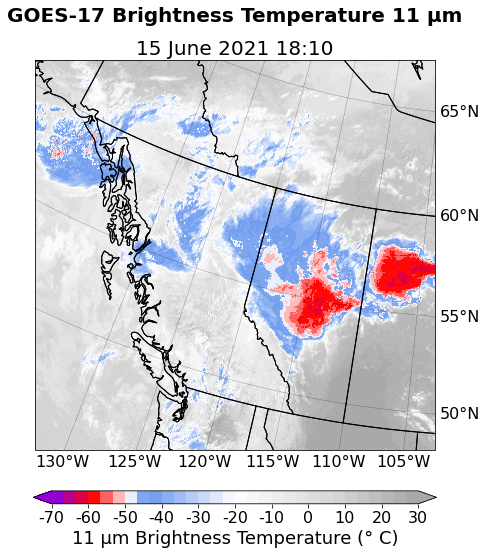

In [65]:
fig = plt.figure(figsize=(8, 6))

for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

       #pc = ccrs.PlateCarree()
        pc = ccrs.LambertConformal()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
       # ax.set_extent([-128, -108, 48, 64], crs=pc)
        #ax.set_extent([-135, -105, 48, 64], ccrs.Geodetic())
        ax.set_extent([-135, -105, 48, 64], ccrs.PlateCarree())

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'
                
       ## gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)
        gl = ax.gridlines(draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)
 
        gl.xlocator = mticker.FixedLocator([ -130,  -125,  -120,  -115,  -110, -105])
        gl.ylocator = mticker.FixedLocator([50,  55, 60, 65])
        gl.left_labels = gl.top_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'rotation': 0, 'size': 16, 'color': 'black'}
        gl.ylabel_style = {'rotation': 0, 'size': 16, 'color': 'black'} #, 'weight': 'bold'
        
         
        colormap = LinearSegmentedColormap.from_list('custom', 
                                       [#(0, "darkviolet"), 
                                        (0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                       # (0.25, "lightsteelblue"),
                                        (0.25, "cornflowerblue"), 
#                                         (0.5, 'cornflowerblue'),
#                                         (0.6,   'lightsteelblue'),
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        #(1.0, 'grey')
                                        ], N=30)
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) 
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30]) 
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-40', '-30','-20', '-10', '0', '10', '20', '30']) 
        
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_nosmoke_MAP_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


### no smoke plot with lightning

In [66]:
lt_bt_full

Unnamed: 0  year  month  day  hour  minute     second    l_lat  \
0              48  2021      6   15    18       5   1.924783  53.6122   
1             126  2021      6   15    18       5   2.096512  53.6193   
3             176  2021      6   15    18       5   2.429782  53.6746   
4             252  2021      6   15    18       5   2.486228  53.6441   
6             327  2021      6   15    18       5   5.382116  53.9568   
...           ...   ...    ...  ...   ...     ...        ...      ...   
20853       14838  2021      6   15    23      59  48.000000  59.3165   
20854       14887  2021      6   15    23      59  49.000000  59.3285   
20855       14927  2021      6   15    23      59  54.000000  59.3445   
20857       14945  2021      6   15    23      59  55.000000  53.6535   
20858       14946  2021      6   15    23      59  56.000000  59.9715   

          l_lon  peak-current C or G    CMI_C14     bt_lat      bt_lon  \
0     -113.9941         125.2      G -55.103867  53.612045 -114.015620   
1     -113.9079         -10.0      G -58.036560  53.617190 -113.939210   
3     -114.0150         -39.8      G -54.146255  53.651413 -114.026870   
4     -114.2175         -22.1      G -56.360733  53.683445 -114.152504   
6     -113.5009         -13.6      G -56.659990  53.924763 -113.517880   
...         ...           ...    ...        ...        ...         ...   
20853 -115.3355         -15.8      G -57.019090  59.314545 -115.367620   
20854 -115.2725           7.0      C -58.694916  59.320705 -115.278336   
20855 -115.0865           6.1      C -60.251038  59.332714 -115.099770   
20857 -115.8575          11.8      C -36.071335  53.622547 -115.854290   
20858 -115.5225         -17.3      G -56.181183  59.967537 -115.527650   

       distance(km)  
0             1.947  
1             1.939  
3             0.733  
4             8.337  
6             1.617  
...             ...  
20853         1.917  
20854         1.266  
20855         0.679  
20857         2.025  
20858         1.655  

[13167 rows x 15 columns]

/tmp/ipykernel_186682/636550738.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


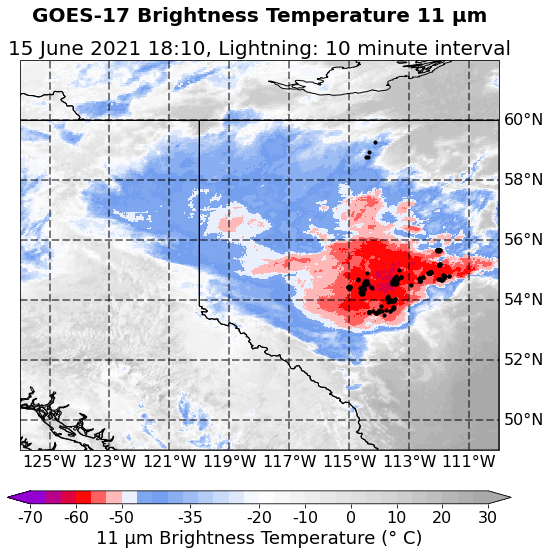

In [67]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):

        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-126, -110, 49, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}, Lightning: 10 minute interval'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

        points = lt_bt_full.loc[(lt_bt_full.hour == 18) & (lt_bt_full.minute <= 10)]

        plt.scatter(x = points["l_lon"], y = points["l_lat"], s = 10, color = "black", marker = "o")

        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## trying to change the projection 

/tmp/ipykernel_186682/1590735129.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


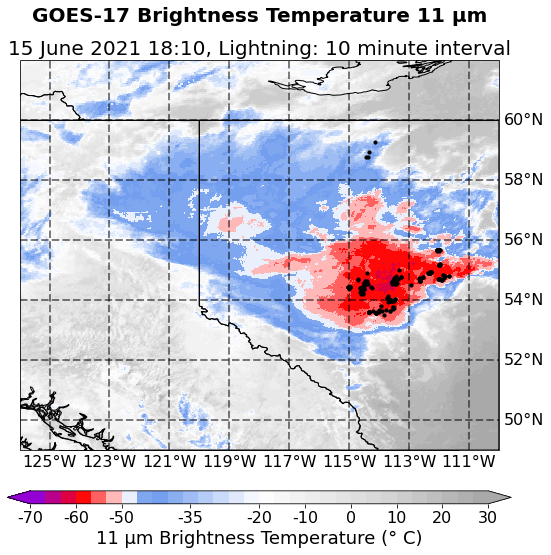

In [68]:
fig = plt.figure(figsize=(10, 6))
    
for i in range(0, 1, 1):
    for j in range(0, 1, 1):

        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        projection = ccrs.LambertConformal()
        data_crs = ccrs.PlateCarree()

        ax = fig.add_subplot(1, 1, 1, projection=projection)
        ax.set_extent([-135, -105, 48, 64], ccrs.PlateCarree()) # , ccrs.PlateCarree()
        
        
        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-126, -110, 49, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}, Lightning: 10 minute interval'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # transform = data_crs
        
        points = lt_bt_full.loc[(lt_bt_full.hour == 18) & (lt_bt_full.minute <= 10)]

        plt.scatter(x = points["l_lon"], y = points["l_lat"], s = 10, color = "black", marker = "o")

        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
        # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
        
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## No smoke map BT final

In [69]:
# Latitude
# 54.872 °
# Longitude
# -106.672 

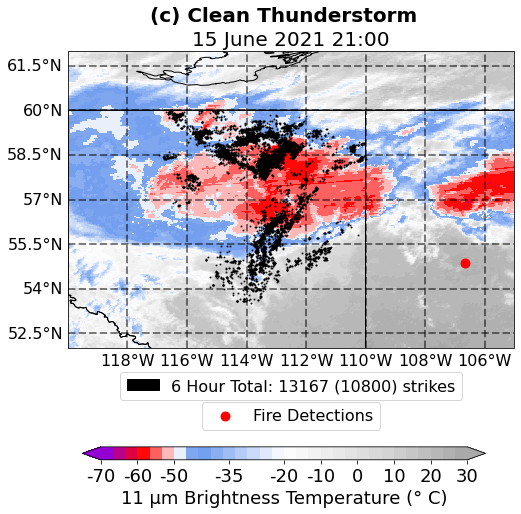

In [70]:
fig = plt.figure(figsize=(8, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(3, 4, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-120, -105, 52, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([-118,  -116,  -114,  -112,  -110, -108, -106])
        gl.ylocator = mticker.FixedLocator([52.5, 54, 55.5, 57, 58.5, 60, 61.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

        points = lt_bt_full.loc[(lt_bt_full.CMI_C14 <= -50) & (lt_bt_full.hour >= 18) & (lt_bt_full.hour <= 23)]
        points_all = lt_bt_full.loc[(lt_bt_full.hour >= 18) & (lt_bt_full.hour <= 23)]

        ax.scatter(x = points["l_lon"], y = points["l_lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        

        patch = mpatches.Patch(facecolor='black', edgecolor = "black", label="6 Hour Total: {} ({}) strikes".format(str(len(points_all)), str(len(points))))
      
        firstlegend =  ax.legend(handles=[patch], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)
        ax.add_artist(firstlegend)
        
        
        fire_lat = [54.872]
        fire_lon = [-106.672]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        ax.legend(fontsize = 16, loc='lower center', 
                    bbox_to_anchor=(0.5, -0.3),)

    
       # tstorm_subregion_box(ax, im)
       # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        #plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle('(c) Clean Thunderstorm', fontweight='bold', fontsize=20, y = 0.95)
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


# no smoke analysis and statistics for BT < -50 C

### no smoke for loop

In [71]:
lt_bt_full = pd.read_csv("/data2/edworak/data/nosmoke_lightning_bt_full.csv", sep='\t')
lt_bt_full = lt_bt_full.drop_duplicates(subset=["l_lat", "l_lon"], keep='first')

hours15 = [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
mins15 = range(0, 60, 10)

num_strikes_nosmoke = np.zeros((len(hours15), len(mins15)))
mean_current_nosmoke = np.zeros((len(hours15), len(mins15)))
mean_pos_current_nosmoke = np.zeros((len(hours15), len(mins15)))
mean_neg_current_nosmoke = np.zeros((len(hours15), len(mins15)))
percent_pos_current_nosmoke = np.zeros((len(hours15), len(mins15)))
num_pos_current_nosmoke =  np.zeros((len(hours15), len(mins15)))
num_neg_current_nosmoke =  np.zeros((len(hours15), len(mins15)))
cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))
cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
pos_cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
neg_cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
pos_cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))
neg_cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))
percent_pos_current_cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
percent_pos_current_cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))

def nosmoke_function(lt_bt_full):
        for i in range(len(hours15)): 
            for j in range(len(mins15)): 
                
                    time = lt_bt_full.loc[(lt_bt_full.CMI_C14 <= -50) & (lt_bt_full.hour == hours15[i]) & (lt_bt_full.minute >= mins15[j]) & (lt_bt_full.minute <= mins15[j] + 9)]
                
                    
                    strikes_nosmoke = (time.loc[(time["l_lon"] >= -120)& (time["l_lon"] <= -110) & 
                                                (time["l_lat"] >= 52) & (time["l_lat"] <= 60)])
                    

                    if len(strikes_nosmoke) >= 1: 
                    
                        num_strikes_nosmoke[i,j] = len(strikes_nosmoke)
                        mean_current_nosmoke[i,j] = np.mean(abs(strikes_nosmoke["peak-current"]))

                        pos_current_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["peak-current"] > 0)]
                        num_pos_current_nosmoke[i,j]= len(pos_current_nosmoke)
                        mean_pos_current_nosmoke[i,j] = np.mean(pos_current_nosmoke["peak-current"])

                        neg_current_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["peak-current"] < 0)]
                        num_neg_current_nosmoke[i,j] = len(neg_current_nosmoke)
                        mean_neg_current_nosmoke[i,j] = np.mean(neg_current_nosmoke["peak-current"])
                        
                        cloud_count_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["C or G"] == "C")]
                        cloud_nosmoke[i,j] = len(cloud_count_nosmoke)
                        pos_cloud_count_nosmoke = cloud_count_nosmoke.loc[(cloud_count_nosmoke["peak-current"] > 0)]
                        pos_cloud_nosmoke[i,j] = len(pos_cloud_count_nosmoke)
                        neg_cloud_count_nosmoke = cloud_count_nosmoke.loc[(cloud_count_nosmoke["peak-current"] < 0)]
                        neg_cloud_nosmoke[i,j] = len(neg_cloud_count_nosmoke)
                        
                        ground_count_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["C or G"] == "G")]
                        cloud_ground_nosmoke[i, j] = len(ground_count_nosmoke)
                        pos_cloud_ground_count_nosmoke = ground_count_nosmoke.loc[(ground_count_nosmoke["peak-current"] > 0)]
                        pos_cloud_ground_nosmoke[i,j] = len(pos_cloud_ground_count_nosmoke)
                        neg_cloud_ground_count_nosmoke= ground_count_nosmoke.loc[(ground_count_nosmoke["peak-current"] < 0)]
                        neg_cloud_ground_nosmoke[i,j] = len(neg_cloud_ground_count_nosmoke)
                        
                        if len(strikes_nosmoke) > 2: 
                            percent_pos_current_nosmoke[i,j] = (len(pos_current_nosmoke["peak-current"]) / len(strikes_nosmoke)) * 100
                        
                        if len(cloud_count_nosmoke) > 2:    
                            percent_pos_current_cloud_nosmoke[i,j] = (len(pos_cloud_count_nosmoke["peak-current"]) / len(cloud_count_nosmoke)) * 100
                        
                        if len(ground_count_nosmoke) > 2:  
                            percent_pos_current_cloud_ground_nosmoke[i,j] = (len(pos_cloud_ground_count_nosmoke["peak-current"]) / len(ground_count_nosmoke)) * 100

        return(num_strikes_nosmoke, percent_pos_current_nosmoke, num_pos_current_nosmoke, num_neg_current_nosmoke, 
            mean_current_nosmoke, mean_pos_current_nosmoke, mean_neg_current_nosmoke, cloud_nosmoke, 
            cloud_ground_nosmoke, pos_cloud_nosmoke,  neg_cloud_nosmoke, pos_cloud_ground_nosmoke,  neg_cloud_ground_nosmoke, 
             percent_pos_current_cloud_nosmoke, percent_pos_current_cloud_ground_nosmoke)


In [72]:
d15 = {}

names15 = ["num_strikes_nosmoke", "percent_pos_current_nosmoke", "num_pos_current_nosmoke", "num_neg_current_nosmoke", 
           "mean_current_nosmoke", "mean_pos_current_nosmoke", "mean_neg_current_nosmoke", "cloud_nosmoke",
         "cloud_ground_nosmoke", "pos_cloud_nosmoke",  "neg_cloud_nosmoke", "pos_cloud_ground_nosmoke",  "neg_cloud_ground_nosmoke", 
        "percent_pos_current_cloud_nosmoke", "percent_pos_current_cloud_ground_nosmoke"]


for i in range(0, len(names15)):
    a15 = nosmoke_function(lt_bt_full)[i]
    b15 = [item for sublist in a15 for item in sublist]
    d15[names15[i]] = b15

print(np.mean(d15["percent_pos_current_nosmoke"]))   

print(np.mean(d15["percent_pos_current_cloud_ground_nosmoke"]))   

37.75704709694177
30.555673524811183


### nested 

In [73]:
hours15 = [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
mins15 = range(0, 60, 10)

nosmoke_cloud_array = []
nosmoke_ground_array = []
nosmoke_neg_cloud_array = []
nosmoke_pos_cloud_array = []
nosmoke_neg_ground_array = []
nosmoke_pos_ground_array = []

for i in range(len(hours15)): 
    for j in range(len(mins15)):   

#nested_data = data_smoke[(data_smoke["hour"] == hours[i]) & (data_smoke["minute"] >= mins[j]) & (data_smoke["minute"] <= mins[j] + 9)]

        time = lt_bt_full.loc[(lt_bt_full.CMI_C14 <= -50) & (lt_bt_full.hour == hours15[i]) & (lt_bt_full.minute >= mins15[j]) & (lt_bt_full.minute <= mins15[j] + 9)]
                
                    
        strikes_nosmoke = (time.loc[(time["l_lon"] >= -120)& (time["l_lon"] <= -110) & 
                                    (time["l_lat"] >= 52) & (time["l_lat"] <= 60)])
        
        if len(strikes_nosmoke) >= 1: 
            nosmoke_cloud_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            nosmoke_ground_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["C or G"] == "G")]["peak-current"]))
            
            nosmoke_pos_cloud_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] > 0) & (strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            nosmoke_neg_cloud_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] < 0) & (strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            
            nosmoke_pos_ground_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] > 0) & (strikes_nosmoke["C or G"] == "G")]["peak-current"]))
            nosmoke_neg_ground_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] < 0) & (strikes_nosmoke["C or G"] == "G")]["peak-current"]))

nosmoke_cloud_flat = [item for sublist in nosmoke_cloud_array for item in sublist]
nosmoke_ground_flat = [item for sublist in nosmoke_ground_array for item in sublist]
nosmoke_neg_cloud_flat = [item for sublist in nosmoke_neg_cloud_array for item in sublist]
nosmoke_pos_cloud_flat = [item for sublist in nosmoke_pos_cloud_array for item in sublist]
nosmoke_neg_ground_flat = [item for sublist in nosmoke_neg_ground_array for item in sublist]
nosmoke_pos_ground_flat = [item for sublist in nosmoke_pos_ground_array for item in sublist]


In [74]:
print(np.mean(nosmoke_neg_ground_flat))
print(np.mean(nosmoke_pos_ground_flat))

-21.71771478088636
14.501828681424445


## no smoke statistics 

### map by energy

/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


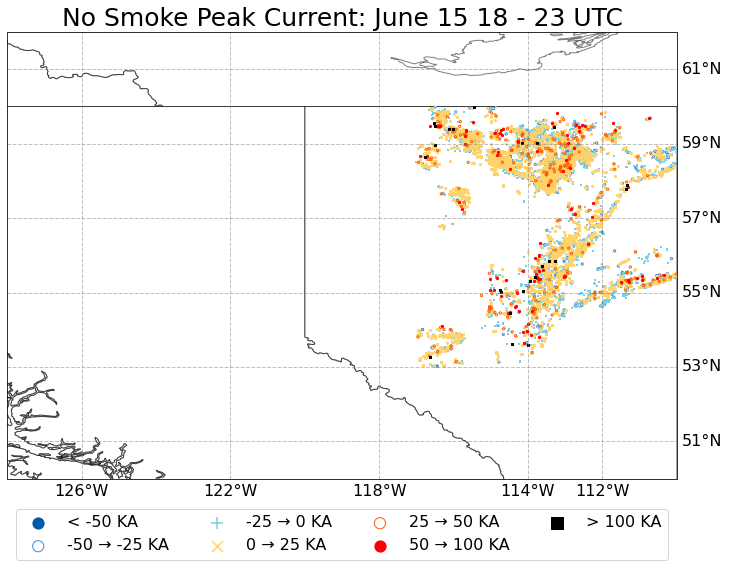

In [75]:
lightning_bt = pd.read_csv("/data2/edworak/data/nosmoke_lightning_bt_sample.csv", sep='\t')

fig = plt.figure(figsize=(12,12))

#entire region
ax = plt.subplot(1,1,1 ,projection=ccrs.PlateCarree())
ax.set_extent([-128,-110,50,62])

ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)

whole_points = lt_bt_full.loc[(lt_bt_full.hour >= 18) & (lt_bt_full.hour <= 23)] # june15.l_lon >= -128) & (june15.l_lon <= -110) & (june15.lat >= 50) & (june15.lat <= 65) &
whole_darkblue = (whole_points.loc[(whole_points["peak-current"] <= -50) & (whole_points.hour == 0)])
whole_medblue = (whole_points.loc[ (whole_points["peak-current"] > -50 ) & (whole_points["peak-current"] <=-25 )])
whole_lightblue = (whole_points.loc[ (whole_points["peak-current"] > -25 ) & (whole_points["peak-current"] <=0 )])
whole_lightorange = (whole_points.loc[(whole_points["peak-current"] > 0 ) & (whole_points["peak-current"] <=25 )])
whole_darkorange = (whole_points.loc[ (whole_points["peak-current"] > 25 ) & (whole_points["peak-current"] <=50 ) ])
whole_red = (whole_points.loc[ (whole_points["peak-current"] > 50 ) & (whole_points["peak-current"] <=100 )])
whole_black = (whole_points.loc[(whole_points["peak-current"] > 100 ) ])

plt.scatter(x = whole_darkblue["l_lon"], y = whole_darkblue["l_lat"], facecolors='#005AAB', edgecolors='#005AAB', marker = "o", s = 5,  alpha=1, label = '< -50 KA')
plt.scatter(x = whole_medblue["l_lon"], y = whole_medblue["l_lat"], facecolors='none', s = 5, edgecolors='#418DD0', marker = "o",  alpha=1, label='-50 → -25 KA')
plt.scatter(x = whole_lightblue["l_lon"], y = whole_lightblue["l_lat"], c = "#7BCDE5", marker = "+", s = 5,  alpha=1, label='-25 → 0 KA')
plt.scatter(x = whole_lightorange["l_lon"], y = whole_lightorange["l_lat"], c = "#FFD26A", marker = "x", s = 5,  alpha=1, label = "0 → 25 KA")
plt.scatter(x = whole_darkorange["l_lon"], y = whole_darkorange["l_lat"], facecolors = "none", edgecolors = '#FF5D00', marker = "o", s = 5,  alpha=1, label ="25 → 50 KA" )
plt.scatter(x = whole_red["l_lon"], y = whole_red["l_lat"], facecolors = "r", edgecolors = 'r', marker = "o", s = 5,  alpha=1, label = "50 → 100 KA")
plt.scatter(x = whole_black["l_lon"], y = whole_black["l_lat"], c = "black", marker = "s", s = 5,  alpha=1, label = "> 100 KA")

#nosmoke_subregion_box(ax, points_pos)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-126, -122,  -118, -114, -112])
gl.ylocator = mticker.FixedLocator([ 51,  53,  55,  57,  59, 61])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

plt.legend(loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=4, fancybox=True, shadow=False, fontsize = 16, markerscale=5.)

tight_layout = True
plt.title("Peak Current June 15 18 - 23 UTC", fontsize = 25)
plt.title("No Smoke Peak Current: June 15 18 - 23 UTC", fontsize =25)
plt.savefig("lightning_strength_nosmoke_bt", bbox_inches = "tight", dpi = 400)
plt.show()


### stats 

In [76]:
positive = (lt_bt_full[(lt_bt_full["peak-current"] > 0) & lt_bt_full["C or G"] == "G"])["peak-current"]
print(np.mean(positive))

negative = (lt_bt_full[(lt_bt_full["peak-current"] < 0) & lt_bt_full["C or G"] == "G"])["peak-current"]
print(np.mean(negative))

nan
nan


### no smoke histogram

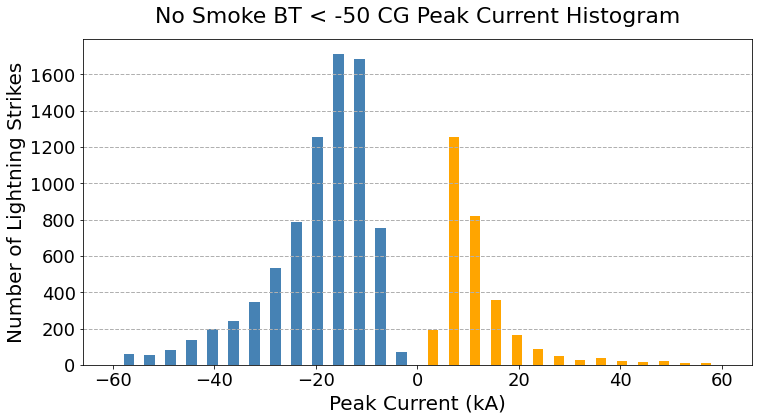

In [77]:

fig = plt.figure(figsize=(12,6))

# points = lt_bt_pyrocb.loc[(lt_bt_pyrocb["C or G"] == "G") & (lt_bt_pyrocb["CMI_C14"] <= -50)]
# weights = np.ones_like(points["peak-current"]) / len(points["peak-current"])


weights1 = np.ones_like(nosmoke_pos_ground_flat) / len(nosmoke_pos_ground_flat)
weights2= np.ones_like(nosmoke_neg_ground_flat) / len(nosmoke_neg_ground_flat)

colors = ["orange", "steelblue"]

bins = np.linspace(-60, 60, 30)

plt.hist([nosmoke_pos_ground_flat, nosmoke_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Cloud", "Negative Cloud to Cloud"]) 
order = [1,0]

#plt.hist([points["peak-current"]], bins, alpha = 1, histtype='bar', color=colors, rwidth=0.6) 

plt.grid(axis='y', linestyle='--', linewidth=1)
plt.title("No Smoke BT < -50 CG Peak Current Histogram", fontsize = 22, y = 1.03)
plt.xlabel("Peak Current (kA)", fontsize = 20)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.annotate("Mean: {:.0f} kA".format(np.mean(nosmoke_neg_ground_flat)), xy =(-40, 2000), fontsize = 22, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(nosmoke_pos_ground_flat)), xy =(40, 2000), fontsize = 22, color = "darkorange", ha='center')

#plt.ylim(0, 4500)
plt.savefig("nosmoke_histogram_bt", dpi = 200)
dpi = 400
plt.show()

### timeseries

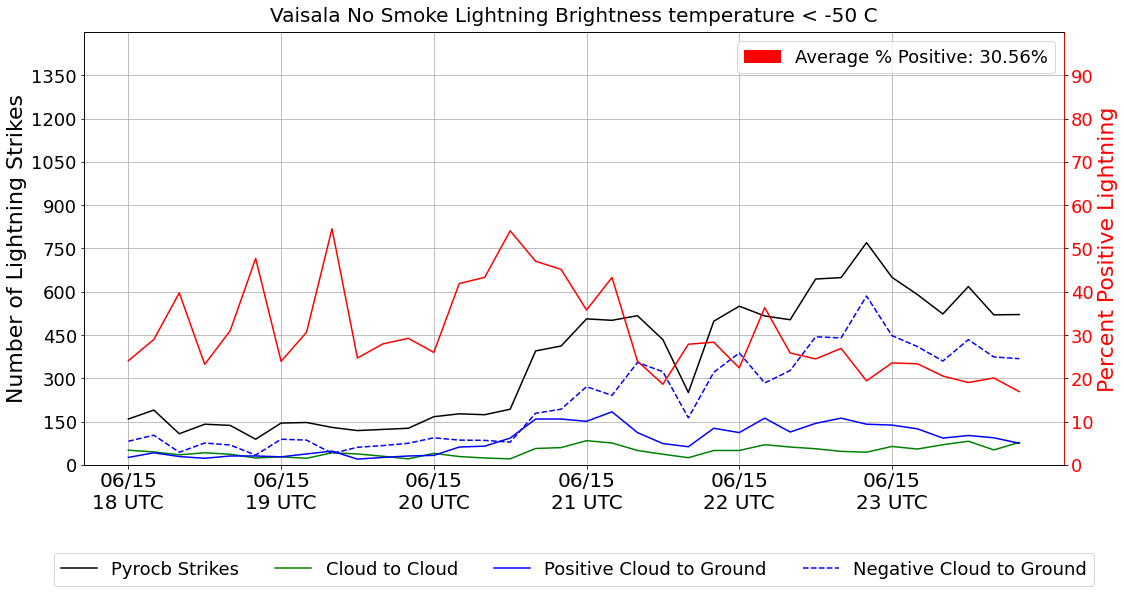

In [78]:

fig,ax = plt.subplots(figsize=(16,8))

xValues = np.arange(0, 36, 1)
xticks = np.arange(0, 36, 6)
yticks = np.arange(0, 1500, 150)
# plt.plot(time (x axis), number of lightning strikes (y axis) , color and line style, label = "label")

ax.plot(xValues, d15["num_strikes_nosmoke"], "k-", label = "Pyrocb Strikes")
ax.plot(xValues, d15["cloud_nosmoke"], "g", label = "Cloud to Cloud")
ax.plot(xValues, d15["pos_cloud_ground_nosmoke"], "b", label = "Positive Cloud to Ground")
ax.plot(xValues, d15["neg_cloud_ground_nosmoke"], "b--", label = "Negative Cloud to Ground")

ax.set_ylim((0,1500))
#ax.set_xlabel("Date and Time", fontsize = 18)
ax.set_ylabel("Number of Lightning Strikes", fontsize = 22)
# ax.legend(loc = "upper left", fontsize = 18)
plt.legend( loc='lower center', 
    bbox_to_anchor=(0.5, -0.3),
    ncol=4, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
labels = ["06/15 18 UTC","06/15 19 UTC", "06/15 20 UTC", "06/15 21 UTC", "06/15 22 UTC", "06/15 23 UTC"]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 20)
ax.set_yticklabels(yticks, fontsize = 18)
plt.grid()

yticks2 = np.arange(0, 100, 10)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(xValues, d15["percent_pos_current_cloud_ground_nosmoke"], color="red")
ax2.set_ylabel("Percent Positive Lightning", color="red",fontsize=22)
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2, fontsize = 18,  color="red")
ax2.set_ylim((0,100))
ax2.spines['right'].set_color('red')

red_patch = mpatches.Patch(color='red', label='Average % Positive: {:.2f}%'.format(np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])))
plt.legend(handles=[red_patch], fontsize = 18)

#plt.grid()
plt.tight_layout()
plt.title("Vaisala No Smoke Lightning Brightness temperature < -50 C", y=1.01, fontsize = 20) 

plt.savefig("nosmoke_timeseries_bt.png", bbox_inches = "tight", dpi = 500)


### box and whisker 

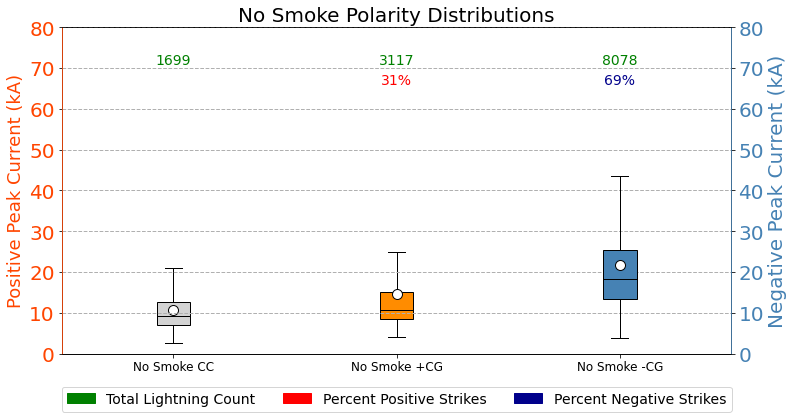

In [79]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title('No Smoke Polarity Distributions', fontsize = 20)
ax.set_ylabel("Positive Peak Current (kA)", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 20, color = "orangered")

data = [ list(map(abs,nosmoke_cloud_flat)), nosmoke_pos_ground_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1]) # , positions = [0, 2, 4, 6]

yticks2 = np.arange(0, 80, 8)
ax2=ax.twinx()

data2 = [list(map(abs,nosmoke_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2]) # 

ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 80)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["No Smoke CC", "No Smoke +CG", "No Smoke -CG"]  
ax.set_xticklabels(labels, fontsize = 12)


# nosmoke length count 
plt.annotate("{:.0f}".format(len(nosmoke_cloud_flat)), xy =(0, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_pos_ground_flat)), xy =(1, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_neg_ground_flat)), xy =(2, 71), fontsize = 14, color = "green", ha='center')

# nosmoke percentage 
plt.annotate("{:.0f}%".format(np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])), xy =(1, 66), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])), xy =(2, 66), fontsize = 14, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.savefig("boxplot_posneg_nosmoke_bt.png",bbox_inches = "tight", dpi = 800)
plt.show()


# PYROCB

## colorbar maps 

### map with split colorbar 

/tmp/ipykernel_186682/449775298.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


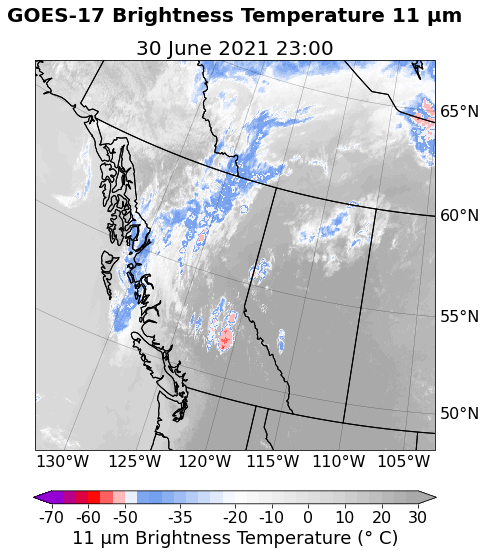

In [80]:
fig = plt.figure(figsize=(8, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(12, 13, 1):
        FILE = '/data2/edworak/data/PyroCb/MCMIPF1/' + file_names_pyrocb[i] 
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        #pc = ccrs.PlateCarree()
        pc = ccrs.LambertConformal()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
       # ax.set_extent([-128, -108, 48, 64], crs=pc)
        #ax.set_extent([-135, -105, 48, 64], ccrs.Geodetic())
        ax.set_extent([-135, -105, 48, 64], ccrs.PlateCarree())

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

       ## gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)
        gl = ax.gridlines(draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)

#         gl.xlines = True
#       #  gl.xlocator = mticker.FixedLocator([ -127, -125, -123, -121, -119, -117, -115, -113, -111, -109, -107, -105])
        gl.xlocator = mticker.FixedLocator([ -130,  -125,  -120,  -115,  -110, -105])

        gl.ylocator = mticker.FixedLocator([50,  55, 60, 65])
        gl.left_labels = gl.top_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'rotation': 0, 'size': 16, 'color': 'black'}
        gl.ylabel_style = {'rotation': 0, 'size': 16, 'color': 'black'} #, 'weight': 'bold'

        colormap = LinearSegmentedColormap.from_list('custom', 
                                        [#(0, "darkviolet"), 
                                        (0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                       # (0.25, "lightsteelblue"),
                                        (0.25, "cornflowerblue"), 
#                                         (0.5, 'cornflowerblue'),
#                                         (0.6,   'lightsteelblue'),
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        #(1.0, 'grey')
                                        ], N=30)
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_pyrocb_MAP_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


### zoom in 

/tmp/ipykernel_186682/823377856.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


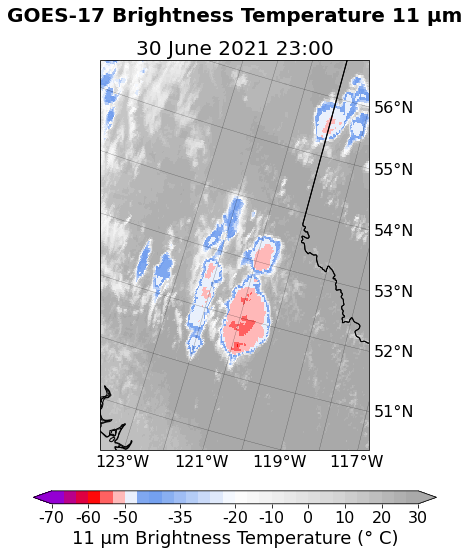

In [81]:
fig = plt.figure(figsize=(8, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(12, 13, 1):
        FILE = '/data2/edworak/data/PyroCb/MCMIPF1/' + file_names_pyrocb[i] 
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        #pc = ccrs.PlateCarree()
        pc = ccrs.LambertConformal()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
       # ax.set_extent([-128, -108, 48, 64], crs=pc)
        #ax.set_extent([-135, -105, 48, 64], ccrs.Geodetic())
        ax.set_extent([-124, -119, 50, 56], ccrs.PlateCarree())

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

       ## gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)
        gl = ax.gridlines(draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)

#         gl.xlines = True
#       #  gl.xlocator = mticker.FixedLocator([ -127, -125, -123, -121, -119, -117, -115, -113, -111, -109, -107, -105])
        gl.xlocator = mticker.FixedLocator([ -123, -122,  -121,  -120,  -119, -118, -117])

        gl.ylocator = mticker.FixedLocator([50, 51,  52, 53, 54, 55, 56])
        gl.left_labels = gl.top_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'rotation': 0, 'size': 16, 'color': 'black'}
        gl.ylabel_style = {'rotation': 0, 'size': 16, 'color': 'black'} #, 'weight': 'bold'

        colormap = LinearSegmentedColormap.from_list('custom', 
                                        [#(0, "darkviolet"), 
                                        (0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                        (0.25, "cornflowerblue"), 
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        ], N=30)
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_pyrocb_MAP_zoom_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## comparing lat lon of two csv files

### testing sample

In [82]:
# hotel = brightness temperatures

br_temp_pyrocb = pd.read_csv('/data2/edworak/data/bt_df_pyrocb.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
br_temp_select_pyrocb = br_temp_pyrocb.loc[(br_temp_pyrocb.hour== 23) & (br_temp_pyrocb.minute <= 5)]
br_temp_select_pyrocb
#print(len(br_temp))
# cold_bt_df = bt_df.loc[(bt_df.CMI_C14 < -50)]
# cold_bt_df

year  month  day  hour  minute        lat         lon    CMI_C14
0     2021      6   30    23       5  52.983370 -121.493970  21.145966
1     2021      6   30    23       5  52.984740 -121.459590   8.876587
2     2021      6   30    23       5  52.986404 -121.425026  -8.779388
3     2021      6   30    23       5  52.987580 -121.390740 -15.602386
4     2021      6   30    23       5  52.989246 -121.356155 -27.632370
...    ...    ...  ...   ...     ...        ...         ...        ...
3873  2021      6   30    23       5  51.041077 -119.029610  30.841827
3874  2021      6   30    23       5  51.000580 -119.113260  31.679718
3875  2021      6   30    23       5  51.002155 -119.079790  30.841827
3876  2021      6   30    23       5  51.003777 -119.046265  29.225830
3877  2021      6   30    23       5  51.005413 -119.012726  30.003876

[3878 rows x 8 columns]

In [83]:
#members = lightning 

data_pyrocb_select = data_pyrocb.loc[(data_pyrocb.hour == 23) & (data_pyrocb.minute <= 5)]
data_pyrocb_select

year  month  day  hour  minute second     lat      lon  peak-current  \
278250  2021      6   30    23       0     04  51.369 -120.967           5.7   
278253  2021      6   30    23       0     26  51.445 -120.868          -2.7   
278254  2021      6   30    23       0     28  51.363 -120.958          10.6   
278255  2021      6   30    23       0     28  51.360 -120.975           7.7   
278256  2021      6   30    23       0     43  51.407 -121.011           7.4   
278257  2021      6   30    23       0     44  51.377 -121.021           5.4   
278258  2021      6   30    23       0     46  51.363 -120.997           2.7   
278259  2021      6   30    23       1     02  51.406 -120.807          -4.3   
278260  2021      6   30    23       1     07  51.362 -120.961           4.6   
278261  2021      6   30    23       1     20  51.367 -120.975         -24.1   
278262  2021      6   30    23       1     20  51.356 -120.970         -18.0   
278263  2021      6   30    23       1     29  51.385 -120.984           4.7   
278264  2021      6   30    23       1     38  51.511 -120.854           3.2   
278275  2021      6   30    23       1     43  51.532 -121.106           9.9   
278276  2021      6   30    23       1     43  51.370 -121.030           4.4   
278277  2021      6   30    23       2     25  51.417 -120.812          -4.3   
278278  2021      6   30    23       2     27  51.468 -120.705           3.4   
278279  2021      6   30    23       2     30  51.349 -120.991           5.6   
278280  2021      6   30    23       2     37  51.347 -120.960           4.9   
278281  2021      6   30    23       2     42  51.387 -121.010          -5.1   
278282  2021      6   30    23       2     42  51.382 -121.000           7.0   
278283  2021      6   30    23       2     42  51.549 -120.974          -4.3   
278284  2021      6   30    23       2     55  51.386 -121.001           3.0   
278285  2021      6   30    23       3     01  51.349 -120.921           6.8   
278286  2021      6   30    23       3     01  51.393 -121.075           3.2   
278287  2021      6   30    23       3     08  51.745 -121.038          -6.5   
278294  2021      6   30    23       3     22  51.346 -120.961           2.5   
278295  2021      6   30    23       3     22  51.361 -120.990           2.7   
278296  2021      6   30    23       3     30  51.354 -120.985           2.9   
278298  2021      6   30    23       3     34  51.375 -120.980         -14.7   
278299  2021      6   30    23       3     34  51.373 -120.982         -17.8   
278303  2021      6   30    23       3     40  51.316 -120.925           2.2   
278304  2021      6   30    23       3     58  51.407 -121.029           9.4   
278305  2021      6   30    23       3     59  51.360 -120.982           6.6   
278306  2021      6   30    23       4     03  51.312 -121.116           2.4   
278307  2021      6   30    23       4     05  51.378 -120.992          -8.2   
278314  2021      6   30    23       4     11  51.476 -120.914           5.9   
278315  2021      6   30    23       4     19  51.393 -121.035          -4.8   
278322  2021      6   30    23       4     24  51.409 -120.992           5.3   
278323  2021      6   30    23       4     26  51.384 -121.026           4.5   
278324  2021      6   30    23       4     38  51.400 -120.930           4.3   
278325  2021      6   30    23       4     44  51.368 -120.980           5.6   
278326  2021      6   30    23       4     44  51.360 -120.974           4.1   
278327  2021      6   30    23       4     44  51.393 -120.996         -11.8   
278328  2021      6   30    23       4     44  51.398 -121.001          -6.3   
278329  2021      6   30    23       4     44  51.393 -120.996         -10.9   
278330  2021      6   30    23       5     03  51.374 -121.048          13.1   
278331  2021      6   30    23       5     08  51.368 -120.982           2.6   
278332  2021      6   30    23       5     10  51.388 -120.923           2.5   
278333  

In [84]:
# def dist(lat1, long1, lat2, long2):

# find closest brightness temp point 
def find_nearest_pyrocb(lat, long):

    distances = br_temp_select_pyrocb.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return br_temp_select_pyrocb.loc[distances.idxmin(), "CMI_C14"]
# get the bt from the bt_df

#then apply it to lightning 

In [85]:
# data_pyrocb_select['CMI_C14'] = data_pyrocb_select.apply(
#     lambda row: find_nearest_pyrocb(row['lat'], row['lon']), 
#     axis=1)
# # # To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
# data_pyrocb_select.head()


#data_pyrocb_select['CMI_C14'] = [find_nearest_pyrocb(lat, lon) for lat, lon in zip(data_pyrocb_select['lat'], data_pyrocb_select['lon'])]


# data_pyrocb_select['CMI_C14'] = data_pyrocb_select.apply(
#      find_nearest_pyrocb.loc[data_pyrocb_select['lat'], data_pyrocb_select['lon']], 
#      axis=1)


for index, row in data_pyrocb_select.iterrows():
    data_pyrocb_select.loc[index, 'CMI_C14'] = find_nearest_pyrocb(row['lat'], row['lon'])

# # To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
data_pyrocb_select.head()

/tmp/ipykernel_186682/1957510275.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pyrocb_select.loc[index, 'CMI_C14'] = find_nearest_pyrocb(row['lat'], row['lon'])


year  month  day  hour  minute second     lat      lon  peak-current  \
278250  2021      6   30    23       0     04  51.369 -120.967           5.7   
278253  2021      6   30    23       0     26  51.445 -120.868          -2.7   
278254  2021      6   30    23       0     28  51.363 -120.958          10.6   
278255  2021      6   30    23       0     28  51.360 -120.975           7.7   
278256  2021      6   30    23       0     43  51.407 -121.011           7.4   

       C or G  multi polarity     range    CMI_C14  
278250      C      0        +  12154.35 -39.303270  
278253      C      0        -  12150.69 -52.111330  
278254      C      0        +  12154.65 -39.303270  
278255      C      0        +  12154.81 -31.462814  
278256      C      0        +  12152.54 -43.313263

In [86]:
# find distance between lightning location to closest brightness temperature 

data_pyrocb_select = pd.merge(data_pyrocb_select, br_temp_select_pyrocb[["CMI_C14",'lat','lon']],on="CMI_C14", how='left')
# Rename the new columns as both the columns has same name, and python gets confused 
data_pyrocb_select = data_pyrocb_select.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon','lat_y':'bt_lat','lon_y':'bt_lon'})
data_pyrocb_select.head()



year  month  day  hour  minute second   l_lat    l_lon  peak-current  \
0  2021      6   30    23       0     04  51.369 -120.967           5.7   
1  2021      6   30    23       0     26  51.445 -120.868          -2.7   
2  2021      6   30    23       0     26  51.445 -120.868          -2.7   
3  2021      6   30    23       0     26  51.445 -120.868          -2.7   
4  2021      6   30    23       0     26  51.445 -120.868          -2.7   

  C or G  multi polarity     range   CMI_C14     bt_lat     bt_lon  
0      C      0        +  12154.35 -39.30327  51.362072 -120.95452  
1      C      0        -  12150.69 -52.11133  52.979195 -120.68167  
2      C      0        -  12150.69 -52.11133  52.431458 -120.74627  
3      C      0        -  12150.69 -52.11133  52.297565 -121.16955  
4      C      0        -  12150.69 -52.11133  52.299137 -121.13555

In [87]:
data_pyrocb_select['distance(km)'] = [haversine(data_pyrocb_select.l_lon[i],data_pyrocb_select.l_lat[i],
                                             data_pyrocb_select.bt_lon[i],data_pyrocb_select.bt_lat[i]) 
                                   for i in range(len(data_pyrocb_select))]
data_pyrocb_select['distance(km)'] = data_pyrocb_select['distance(km)'].round(decimals=3)
# Printing the data table 
data_pyrocb_close = data_pyrocb_select.loc[data_pyrocb_select["distance(km)"] < 10]
data_pyrocb_select

year  month  day  hour  minute second   l_lat    l_lon  peak-current  \
0    2021      6   30    23       0     04  51.369 -120.967           5.7   
1    2021      6   30    23       0     26  51.445 -120.868          -2.7   
2    2021      6   30    23       0     26  51.445 -120.868          -2.7   
3    2021      6   30    23       0     26  51.445 -120.868          -2.7   
4    2021      6   30    23       0     26  51.445 -120.868          -2.7   
..    ...    ...  ...   ...     ...    ...     ...      ...           ...   
266  2021      6   30    23       5     54  51.391 -120.935           3.2   
267  2021      6   30    23       5     54  51.391 -120.935           3.2   
268  2021      6   30    23       5     59  51.390 -120.994           3.5   
269  2021      6   30    23       5     59  51.390 -120.994           3.5   
270  2021      6   30    23       5     59  51.390 -120.994           3.5   

    C or G  multi polarity     range    CMI_C14     bt_lat     bt_lon  \
0        C      0        +  12154.35 -39.303270  51.362072 -120.95452   
1        C      0        -  12150.69 -52.111330  52.979195 -120.68167   
2        C      0        -  12150.69 -52.111330  52.431458 -120.74627   
3        C      0        -  12150.69 -52.111330  52.297565 -121.16955   
4        C      0        -  12150.69 -52.111330  52.299137 -121.13555   
..     ...    ...      ...       ...        ...        ...        ...   
266      C      0        +  12153.29 -49.178650  51.531464 -120.49236   
267      C      0        +  12153.29 -49.178650  51.400112 -120.93921   
268      C      0        +  12153.36 -43.313263  52.664970 -120.71466   
269      C      0        +  12153.36 -43.313263  52.585957 -120.74820   
270      C      0        +  12153.36 -43.313263  51.397118 -121.00575   

     distance(km)  
0           1.159  
1         171.066  
2         110.006  
3          97.035  
4          96.735  
..            ...  
266        34.414  
267         1.054  
268       143.052  
269       134.045  
270         1.136  

[271 rows x 17 columns]

### for loop 

In [88]:
"""br_temp_pyrocb = pd.read_csv('/data2/edworak/data/bt_df_pyrocb.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])

lightning_df_pyrocb = []
# get it all into one 
# then limit it by time 
hours = [22, 23, 0, 1, 2, 3, 4]
mins = range(0, 60, 5)

def find_nearest_pyrocb(lat, long):
    distances = br_temp_pyrocb_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return br_temp_pyrocb_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        data_pyrocb_time = data_pyrocb.loc[(data_pyrocb.hour == hours[i]) & (data_pyrocb.minute >= mins[j]) & (data_pyrocb.minute <= mins[j] + 4)]
        br_temp_pyrocb_time = br_temp_pyrocb.loc[(br_temp_pyrocb.hour == hours[i])& (br_temp_pyrocb.minute >= mins[j]) & (br_temp_pyrocb.minute <= mins[j] + 4)] 
        
        if (len(data_pyrocb_time) >0) & (len(br_temp_pyrocb_time) >0): 
            
            data_pyrocb_time['CMI_C14'] = data_pyrocb_time.apply(
                lambda row: find_nearest_pyrocb(row['lat'], row['lon']), axis=1)

            data_pyrocb_time = pd.merge(data_pyrocb_time, br_temp_pyrocb_time[['CMI_C14','lat','lon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_pyrocb_time = data_pyrocb_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'bt_lat','lon_y':'bt_lon'})

            data_pyrocb_time['distance(km)'] = [haversine(data_pyrocb_time.l_lon[i],data_pyrocb_time.l_lat[i],
                                                 data_pyrocb_time.bt_lon[i],data_pyrocb_time.bt_lat[i]) 
                                                 for i in range(len(data_pyrocb_time))]
            data_pyrocb_time['distance(km)'] = data_pyrocb_time['distance(km)'].round(decimals=3)
            data_pyrocb_close = data_pyrocb_time.loc[data_pyrocb_time["distance(km)"] < 10]

            if len(lightning_df_pyrocb) == 0: 
                lightning_df_pyrocb = data_pyrocb_close
            else: 
                lightning_df_pyrocb = pd.concat([lightning_df_pyrocb, data_pyrocb_close], axis =0)
            lightning_df_pyrocb
      """

'br_temp_pyrocb = pd.read_csv(\'/data2/edworak/data/bt_df_pyrocb.nc\', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])\n\nlightning_df_pyrocb = []\n# get it all into one \n# then limit it by time \nhours = [22, 23, 0, 1, 2, 3, 4]\nmins = range(0, 60, 5)\n\ndef find_nearest_pyrocb(lat, long):\n    distances = br_temp_pyrocb_time.apply(lambda row: dist(lat, long, row[\'lat\'], row[\'lon\']), axis=1)\n    return br_temp_pyrocb_time.loc[distances.idxmin(), "CMI_C14"]\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        print(i)\n        data_pyrocb_time = data_pyrocb.loc[(data_pyrocb.hour == hours[i]) & (data_pyrocb.minute >= mins[j]) & (data_pyrocb.minute <= mins[j] + 4)]\n        br_temp_pyrocb_time = br_temp_pyrocb.loc[(br_temp_pyrocb.hour == hours[i])& (br_temp_pyrocb.minute >= mins[j]) & (br_temp_pyrocb.minute <= mins[j] + 4)] \n        \n        if (len(data_pyrocb_time) >0) & (len(br_temp_pyrocb_time) >0): \n            \n        

In [89]:
lt_bt_pyrocb = pd.read_csv("/data2/edworak/data/pyrocb_lightning_bt.csv", sep='\t')
# lt_bt_pyrocb = lt_bt_pyrocb.drop_duplicates(subset=["l_lat", "l_lon", "peak-current"], keep='first')
lt_bt_pyrocb = lt_bt_pyrocb.drop_duplicates(keep='first')

lt_bt_pyrocb

Unnamed: 0  year  month  day  hour  minute  second   l_lat    l_lon  \
0              0  2021      6   30    23       0       4  51.369 -120.967   
1             23  2021      6   30    23       0      26  51.445 -120.868   
2             24  2021      6   30    23       0      28  51.363 -120.958   
3             25  2021      6   30    23       0      28  51.360 -120.975   
4             28  2021      6   30    23       0      43  51.407 -121.011   
...          ...   ...    ...  ...   ...     ...     ...     ...      ...   
6055         295  2021      7    1     3      55       4  52.481 -120.703   
6056         296  2021      7    1     3      55       4  52.481 -120.703   
6057         316  2021      7    1     3      55       5  51.262 -120.877   
6058         328  2021      7    1     3      55      17  52.519 -120.684   
6059         330  2021      7    1     3      55      17  52.519 -120.684   

      peak-current C or G  multi polarity     range    CMI_C14     bt_lat  \
0              5.7      C      0        +  12154.35 -39.303270  51.362072   
1             -2.7      C      0        -  12150.69 -52.111330  51.440840   
2             10.6      C      0        +  12154.65 -39.303270  51.362072   
3              7.7      C      0        +  12154.81 -31.462814  51.360744   
4              7.4      C      0        +  12152.54 -43.313263  51.397118   
...            ...    ...    ...      ...       ...        ...        ...   
6055         -26.5      G      0        -  12100.14 -56.061478  52.471943   
6056         -26.5      G      0        -  12100.14 -56.061478  52.431458   
6057           2.3      C      0        +  12159.56  13.245697  51.254420   
6058           3.0      C      0        +  12098.28 -56.420593  52.511597   
6059           3.0      C      0        +  12098.28 -56.420593  52.434116   

          bt_lon  distance(km)  
0    -120.954520         1.159  
1    -120.857414         0.867  
2    -120.954520         0.263  
3    -120.987660         0.883  
4    -121.005750         1.158  
...          ...           ...  
6055 -120.695670         1.123  
6056 -120.746270         6.240  
6057 -120.867386         1.076  
6058 -120.678820         0.895  
6059 -120.678130         9.447  

[6060 rows x 18 columns]

### changing lightning for parallax

In [90]:
lt_bt_pyrocb["l_lat"] = lt_bt_pyrocb["l_lat"] + 0.280070
lt_bt_pyrocb["l_lon"] = lt_bt_pyrocb["l_lon"] + 0.124172
# lt_bt_pyrocb["l_lat"] = lt_bt_pyrocb["l_lat"] + 0.381
# lt_bt_pyrocb["l_lon"] = lt_bt_pyrocb["l_lon"] + 0.225



### checking with map

#### full range

/tmp/ipykernel_186682/3504711381.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


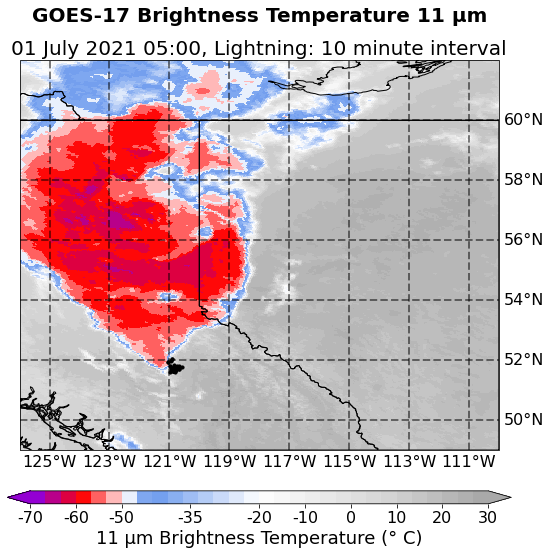

In [91]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(6, 7, 1):
        path = '/data2/edworak/data/PyroCb/MCMIPF1/'
        FILE = path + file_names_pyrocb[i]

        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-126, -110, 49, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}, Lightning: 10 minute interval'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        ###### lightning ########
#         xs = [point.x for point in lightning_array]
#         ys = [point.y for point in lightning_array]
#         plt.scatter(ys, xs, s = 30, color = "black", marker = "o")
        points = lt_bt_pyrocb.loc[(lt_bt_pyrocb.hour == 23) & (lt_bt_pyrocb.minute <= 10)]

        plt.scatter(x = points["l_lon"], y = points["l_lat"], s = 10, color = "black", marker = "o")

        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_pyrocb_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


#### zoomed in

/tmp/ipykernel_186682/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186682/2273462775.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


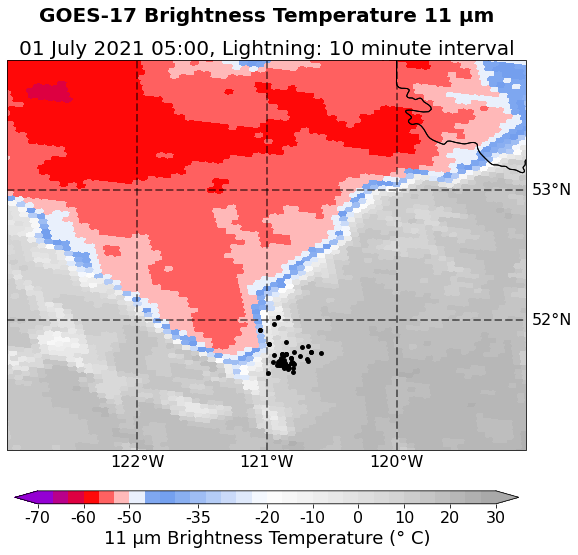

In [92]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(6, 7, 1):
        path = '/data2/edworak/data/PyroCb/MCMIPF1/'
        FILE = path + file_names_pyrocb[i]

        data = xarray.open_dataset(FILE)
        data = calc_latlon(data)
        goes_string = str(data)
        goes_data = calc_latlon(data)
        goes_data = goes_data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"
#         data_celsius["lat"] = data_celsius['lat'][:] - 0.381084
#         data_celsius["lon"] = data_celsius['lon'][:] - 0.225186
        
        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x 
        y = dat.y
        
        
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-123, -119, 51, 54], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}, Lightning: 10 minute interval'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-122, -121, -120])
        gl.ylocator = mticker.FixedLocator([51, 52, 53])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        ###### lightning ########
#         xs = [point.x for point in lightning_array]
#         ys = [point.y for point in lightning_array]
#         plt.scatter(ys, xs, s = 30, color = "black", marker = "o")
        points = lt_bt_pyrocb.loc[(lt_bt_pyrocb.hour == 23) & (lt_bt_pyrocb.minute <= 10)]

        plt.scatter(x = points["l_lon"], y = points["l_lat"], s = 15, color = "black", marker = "o")
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_pyrocb_zoom_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


### individual pyrocb cases 

In [93]:
# these strike counts are for the whole region not selected by anything 
def pyrocb_subregion_box(ax, subregion):
    geom1 = geometry.box(minx=-121.5,maxx=-120,miny=51,maxy=53)
    point1 = Point(-120.8,  51)
    ax.add_geometries([point1], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='red', linewidth = 5)
    ax.add_geometries([geom1], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='green', linewidth = 4)
    return ax
# pyrocb_count = len(data_june30.loc[(data_june30.lon > -121.5) & (data_june30.lon < -120) & (data_june30.lat > 51) & (data_june30.lat < 53)])
# print(pyrocb_count)

def mckay_subregion_box(ax, subregion):
    geom2 = geometry.box(minx=-122.5,maxx=-121.7,miny=51,maxy=52.1)
    ax.add_geometries([geom2], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='brown', linewidth = 4)
    point2 = Point(-121.9, 51)
    ax.add_geometries([point2], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='red', linewidth = 5)
    return ax

# mckay_count = len(data_june30.loc[(data_june30.lon >= -122.5) & (data_june30.lon <= -121.7) & (data_june30.lat >= 51) & (data_june30.lat <= 52.1)])
# print(mckay_count)

def lytton_subregion_box(ax, subregion):
    geom3 = geometry.box(minx=-122,maxx=-121,miny=50.3,maxy=51)
    ax.add_geometries([geom3], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='darkorange', linewidth = 4)
    point3 = Point(-121.5, 50.3)
    ax.add_geometries([point3], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='red',linewidth = 5)
    return ax
# lytton_count = len(data_july1.loc[(data_july1.lon > -122) & (data_july1.lon < -121) & (data_july1.lat > 50.3) & (data_july1.lat < 50.8)])
# print(lytton_count)


### time frame 1

In [94]:
data_june29["lon"] = data_june29["lon"] - 0.25


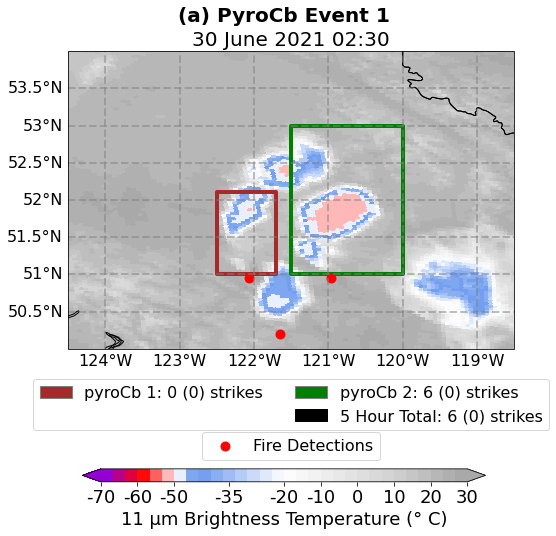

In [95]:
fig = plt.figure(figsize=(8, 6))


# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
# for i in range(22, 23, 1):

# for i in range(0, 1, 1):

#         path = '/data2/edworak/data/BT'
#         FILE = path + file_names_pyrocb[i]

#         data = xarray.open_dataset(FILE)


for i in range(1, 2, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_pyrocb_early/' + folder_names_pyrocbearly[i] + '/'
        FILE = path + file_names_pyrocbearly[i][j]
        data = xarray.open_dataset(FILE)
        
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123, -122, -121, -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

#        plt.scatter(x = data_june29["lon"], y = data_june29["lat"], s = 10, color = "black", marker = "o", alpha = 0.8)

        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        
        lightning_count = len(data_june29.loc[(data_june29.lat >= 50) & (data_june29.lat <= 54) & (data_june29.lon >= -123) & (data_june29.lon <= -119.5)])
        patch1_count = len(data_june29.loc[(data_june29.lat >= 51) & (data_june29.lat <= 52.1) & (data_june29.lon >= -122.5) & (data_june29.lon <= -121.7)])
        patch2_count = len(data_june29.loc[(data_june29.lat >= 51) & (data_june29.lat <= 53) & (data_june29.lon >= -121.5) & (data_june29.lon <= -120.0)])
        
        patch = mpatches.Patch(facecolor='black', edgecolor = "black", label="5 Hour Total: {} (0) strikes".format(str(lightning_count)))
        patch1 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("pyroCb 1: {} (0) strikes".format(str(patch1_count))))
        patch2 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("pyroCb 2: {} (0) strikes".format(str(patch2_count))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        #plt.legend(handles=[green_patch], fontsize = 14)
        

# McKay Creek Latitude 50.953 ° Longitude -121.971 °
# Lytton  Latitude 50.202 ° Longitude -121.549 °
# Sparks  Latitude 50.951 ° Longitude -120.864 °
        firstlegend = ax.legend(handles=[patch1, blank, patch2, patch], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.3),
                    ncol=2, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)      
        ax.add_artist(firstlegend)
        
        
        fire_lat = [50.953, 50.202, 50.951]
        fire_lon = [-122.071, -121.649, -120.964]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        ax.legend(fontsize = 16, loc='lower center', 
                    bbox_to_anchor=(0.5, -0.4),)
        


       # [left, bottom, width, height]
       # cax = plt.axes([0.83, 0.12, 0.02, 0.8])
        cax = plt.axes([0.15, -0.15, 0.7, 0.03])
#         #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5,  cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        #plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle('(a) PyroCb Event 1', fontweight='bold', fontsize=20, y = 0.95)
plt.savefig("BT_pyrocbearly_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


### time frame 2

In [96]:
data_split2


year  month  day  hour  minute second     lat      lon  peak-current  \
0        2021      6    2    22      15     39  58.073 -119.732          14.7   
1        2021      6    2    22      15     40  58.043 -119.737          12.2   
2        2021      6    2    22      19     23  58.060 -118.448         -40.3   
3        2021      6    2    22      19     23  58.060 -118.449         -22.4   
4        2021      6    2    22      19     23  58.059 -118.448          -9.5   
...       ...    ...  ...   ...     ...    ...     ...      ...           ...   
1308797  2021      7   31    23      55     54  52.396 -123.137         -12.6   
1308798  2021      7   31    23      55     54  52.397 -123.148         -17.5   
1308799  2021      7   31    23      55     54  52.334 -123.095          -6.7   
1308800  2021      7   31    23      56     39  52.323 -122.974           2.4   
1308801  2021      7   31    23      59     57  52.412 -123.141           8.0   

        C or G  multi polarity     range  
0            C      0        +  11817.95  
1            C      0        +  11819.49  
2            G      0        -  11818.65  
3            G      0        -  11818.65  
4            G      0        -  11818.68  
...        ...    ...      ...       ...  
1308797      G      0        -  12104.32  
1308798      G      0        -  12104.26  
1308799      G      0        -  12107.33  
1308800      C      0        +  12107.86  
1308801      C      0        +  12103.51  

[1308802 rows x 13 columns]

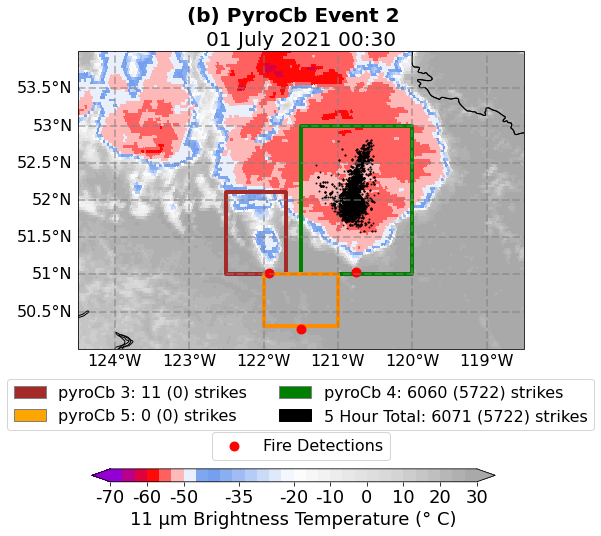

In [97]:
fig= plt.figure(figsize=(8, 6))

# for i in range(22, 23, 1):
for i in range(21, 22, 1):

        path = '/data2/edworak/data/PyroCb/MCMIPF1/'
        FILE = path + file_names_pyrocb[i]

        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)
        ax.set_xlabel("Lightning Strike Totals", fontsize = 16)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        ax.set_axisbelow(True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123,  -122,  -121,  -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'
        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        points = lt_bt_pyrocb.loc[(lt_bt_pyrocb.CMI_C14 <= -50)]

        #plt.scatter(x = points["l_lon"], y = points["l_lat"], s = 1, color = "black", marker = "o", alpha = 0.8)

        ax.scatter(x = points["l_lon"], y = points["l_lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        lytton_subregion_box(ax, points)


       
        patch3_count1 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch3_count2 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch3_count = patch3_count1 + patch3_count2
        patch4_count = len(lt_bt_pyrocb)
        patch4_bt_count = len(points)
        patch5_count1 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121)& (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch5_count2 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch5_count = patch5_count1 + patch5_count2
        lightning_count = patch3_count + patch4_count + patch5_count
        lightning_bt_count =  patch4_bt_count  
        patch = mpatches.Patch(facecolor='black', edgecolor = "black", label="5 Hour Total: {} ({}) strikes".format(str(lightning_count), str(lightning_bt_count)))
        patch3 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("pyroCb 3: {} (0) strikes".format(str(patch3_count))))
        patch4 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("pyroCb 4: {} ({}) strikes".format(str(patch4_count), str(patch4_bt_count))))
        patch5 = mpatches.Patch(facecolor='orange', edgecolor = "grey", label=("pyroCb 5: {} (0) strikes".format(str(patch5_count))))
        
        
        firstlegend = ax.legend(handles=[patch3,  patch5, patch4, patch], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.3),
                    ncol=2, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)
        ax.add_artist(firstlegend)
        
# McKay Latitude 51.012 ° Longitude -121.982 °
# Lytton Latitude 50.262 ° Longitude -121.552 °
# Sparks Latitude 51.026 ° Longitude -120.854 °

        fire_lat = [51.012, 50.262, 51.026]
        fire_lon = [-121.932, -121.502, -120.754]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        ax.legend(fontsize = 16, loc='lower center', 
                    bbox_to_anchor=(0.5, -0.4),)
        
        
        plt.suptitle('(b) PyroCb Event 2', fontweight='bold', fontsize=20, y = 0.95)
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        # tstorm_subregion_box(ax, im)
       # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.15, 0.7, 0.03])
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
        
        #plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        

plt.savefig("BT_pyrocb_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


# pyrocb analysis and statistics for BT < -50 C

### pyrocb for loop 

In [98]:
lt_bt_pyrocb = pd.read_csv("/data2/edworak/data/pyrocb_lightning_bt.csv", sep='\t')

hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

num_strikes_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_current_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_pos_current_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_neg_current_pyrocb = np.zeros((len(hours1), len(mins1)))
percent_pos_current_pyrocb = np.zeros((len(hours1), len(mins1)))
num_pos_current_pyrocb =  np.zeros((len(hours1), len(mins1)))
num_neg_current_pyrocb =  np.zeros((len(hours1), len(mins1)))
cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
pos_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
neg_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))

def pyrocb_function(lt_bt_pyrocb):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_bt_pyrocb.loc[(lt_bt_pyrocb.CMI_C14 <= -50) & (lt_bt_pyrocb.hour == hours1[i]) & (lt_bt_pyrocb.minute >= mins1[j]) & (lt_bt_pyrocb.minute <= mins1[j] + 9)]
                
                    
                    strikes_pyrocb = (time.loc[(time["l_lon"] >= -121.5)& (time["l_lon"] <= -119) & 
                                                (time["l_lat"] >= 51) & (time["l_lat"] <= 53)])
                    

                    if len(strikes_pyrocb) >= 1: 
                    
                        num_strikes_pyrocb[i,j] = len(strikes_pyrocb)
                        mean_current_pyrocb[i,j] = np.mean(abs(strikes_pyrocb["peak-current"]))

                        pos_current_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["peak-current"] > 0)]
                        num_pos_current_pyrocb[i,j]= len(pos_current_pyrocb)
                        mean_pos_current_pyrocb[i,j] = np.mean(pos_current_pyrocb["peak-current"])

                        neg_current_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["peak-current"] < 0)]
                        num_neg_current_pyrocb[i,j] = len(neg_current_pyrocb)
                        mean_neg_current_pyrocb[i,j] = np.mean(neg_current_pyrocb["peak-current"])
                        
                        cloud_count_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["C or G"] == "C")]
                        cloud_pyrocb[i,j] = len(cloud_count_pyrocb)
                        pos_cloud_count_pyrocb = cloud_count_pyrocb.loc[(cloud_count_pyrocb["peak-current"] > 0)]
                        pos_cloud_pyrocb[i,j] = len(pos_cloud_count_pyrocb)
                        neg_cloud_count_pyrocb = cloud_count_pyrocb.loc[(cloud_count_pyrocb["peak-current"] < 0)]
                        neg_cloud_pyrocb[i,j] = len(neg_cloud_count_pyrocb)
                        
                        ground_count_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["C or G"] == "G")]
                        cloud_ground_pyrocb[i, j] = len(ground_count_pyrocb)
                        pos_cloud_ground_count_pyrocb = ground_count_pyrocb.loc[(ground_count_pyrocb["peak-current"] > 0)]
                        pos_cloud_ground_pyrocb[i,j] = len(pos_cloud_ground_count_pyrocb)
                        neg_cloud_ground_count_pyrocb= ground_count_pyrocb.loc[(ground_count_pyrocb["peak-current"] < 0)]
                        neg_cloud_ground_pyrocb[i,j] = len(neg_cloud_ground_count_pyrocb)
                        
                        if len(strikes_pyrocb) > 2: 
                            percent_pos_current_pyrocb[i,j] = (len(pos_current_pyrocb["peak-current"]) / len(strikes_pyrocb)) * 100
                        
                        if len(cloud_count_pyrocb) > 2:    
                            percent_pos_current_cloud_pyrocb[i,j] = (len(pos_cloud_count_pyrocb["peak-current"]) / len(cloud_count_pyrocb)) * 100
                            percent_cloud_pyrocb[i,j] = (len(cloud_count_pyrocb["peak-current"]) / len(strikes_pyrocb)) * 100

                        if len(ground_count_pyrocb) > 2:  
                            percent_pos_current_cloud_ground_pyrocb[i,j] = (len(pos_cloud_ground_count_pyrocb["peak-current"]) / len(ground_count_pyrocb)) * 100

        return(num_strikes_pyrocb, percent_pos_current_pyrocb, num_pos_current_pyrocb, num_neg_current_pyrocb, 
            mean_current_pyrocb, mean_pos_current_pyrocb, mean_neg_current_pyrocb, cloud_pyrocb, 
            cloud_ground_pyrocb, pos_cloud_pyrocb,  neg_cloud_pyrocb, pos_cloud_ground_pyrocb,  neg_cloud_ground_pyrocb, 
             percent_pos_current_cloud_pyrocb, percent_pos_current_cloud_ground_pyrocb, percent_cloud_pyrocb)


In [99]:
d1 = {}

names1 = ["num_strikes_pyrocb", "percent_pos_current_pyrocb", "num_pos_current_pyrocb", "num_neg_current_pyrocb", 
           "mean_current_pyrocb", "mean_pos_current_pyrocb", "mean_neg_current_pyrocb", "cloud_pyrocb",
         "cloud_ground_pyrocb", "pos_cloud_pyrocb",  "neg_cloud_pyrocb", "pos_cloud_ground_pyrocb",  "neg_cloud_ground_pyrocb", 
        "percent_pos_current_cloud_pyrocb", "percent_pos_current_cloud_ground_pyrocb", "percent_cloud_pyrocb"]


for i in range(0, len(names1)):
    a1 = pyrocb_function(lt_bt_pyrocb)[i]
    b1 = [item for sublist in a1 for item in sublist]
    d1[names1[i]] = b1

print(np.mean(d1["percent_pos_current_pyrocb"]))   

print(np.mean(d1["percent_pos_current_cloud_ground_pyrocb"]))   
#d1["num_strikes_pyrocb"]

72.94636949141469
2.4653369979456934


### nested

In [100]:
hours1 = [23.0, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

pyrocb_cloud_array = []
pyrocb_ground_array = []
pyrocb_neg_cloud_array = []
pyrocb_pos_cloud_array = []
pyrocb_neg_ground_array = []
pyrocb_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_bt_pyrocb.loc[(lt_bt_pyrocb.CMI_C14 <= -50) & (lt_bt_pyrocb.hour == hours1[i]) & (lt_bt_pyrocb.minute >= mins1[j]) & (lt_bt_pyrocb.minute <= mins1[j] + 9)]
                
                    
        strikes_pyrocb = (time.loc[(time["l_lon"] >= -121.5)& (time["l_lon"] <= -119) & 
                                    (time["l_lat"] >= 51) & (time["l_lat"] <= 53)])
        
        if len(strikes_pyrocb) >= 1: 
            pyrocb_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            pyrocb_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))
            
            pyrocb_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            pyrocb_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            
            pyrocb_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
            pyrocb_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

pyrocb_cloud_flat = [item for sublist in pyrocb_cloud_array for item in sublist]
pyrocb_ground_flat = [item for sublist in pyrocb_ground_array for item in sublist]
pyrocb_neg_cloud_flat = [item for sublist in pyrocb_neg_cloud_array for item in sublist]
pyrocb_pos_cloud_flat = [item for sublist in pyrocb_pos_cloud_array for item in sublist]
pyrocb_neg_ground_flat = [item for sublist in pyrocb_neg_ground_array for item in sublist]
pyrocb_pos_ground_flat = [item for sublist in pyrocb_pos_ground_array for item in sublist]


In [101]:
print(np.mean(pyrocb_neg_ground_flat))
print(np.mean(pyrocb_pos_ground_flat))

-18.011309523809523
9.760000000000002


## pyrocb statistics

### pyrocb histogram

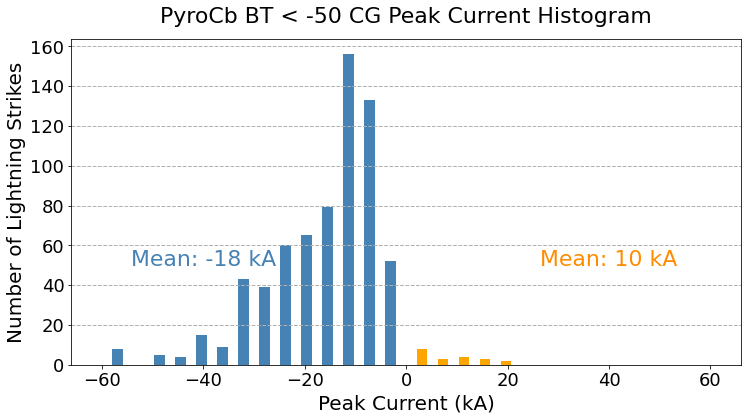

In [102]:
fig = plt.figure(figsize=(12,6))

# points = lt_bt_pyrocb.loc[(lt_bt_pyrocb["C or G"] == "G") & (lt_bt_pyrocb["CMI_C14"] <= -50)]
# weights = np.ones_like(points["peak-current"]) / len(points["peak-current"])


weights1 = np.ones_like(pyrocb_pos_ground_flat) / len(pyrocb_pos_ground_flat)
weights2= np.ones_like(pyrocb_neg_ground_flat) / len(pyrocb_neg_ground_flat)

colors = ["orange", "steelblue"]

bins = np.linspace(-60, 60, 30)

plt.hist([pyrocb_pos_ground_flat, pyrocb_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Cloud", "Negative Cloud to Cloud"]) 
order = [1,0]

#plt.hist([points["peak-current"]], bins, alpha = 1, histtype='bar', color=colors, rwidth=0.6) 

plt.grid(axis='y', linestyle='--', linewidth=1)
plt.title("PyroCb BT < -50 CG Peak Current Histogram", fontsize = 22, y = 1.03)
plt.xlabel("Peak Current (kA)", fontsize = 20)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_neg_ground_flat)), xy =(-40, 50), fontsize = 22, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_pos_ground_flat)), xy =(40, 50), fontsize = 22, color = "darkorange", ha='center')

#plt.ylim(0, 4500)
plt.savefig("pyrocb_histogram_bt", dpi = 200)
dpi = 400
plt.show()

### timeseries

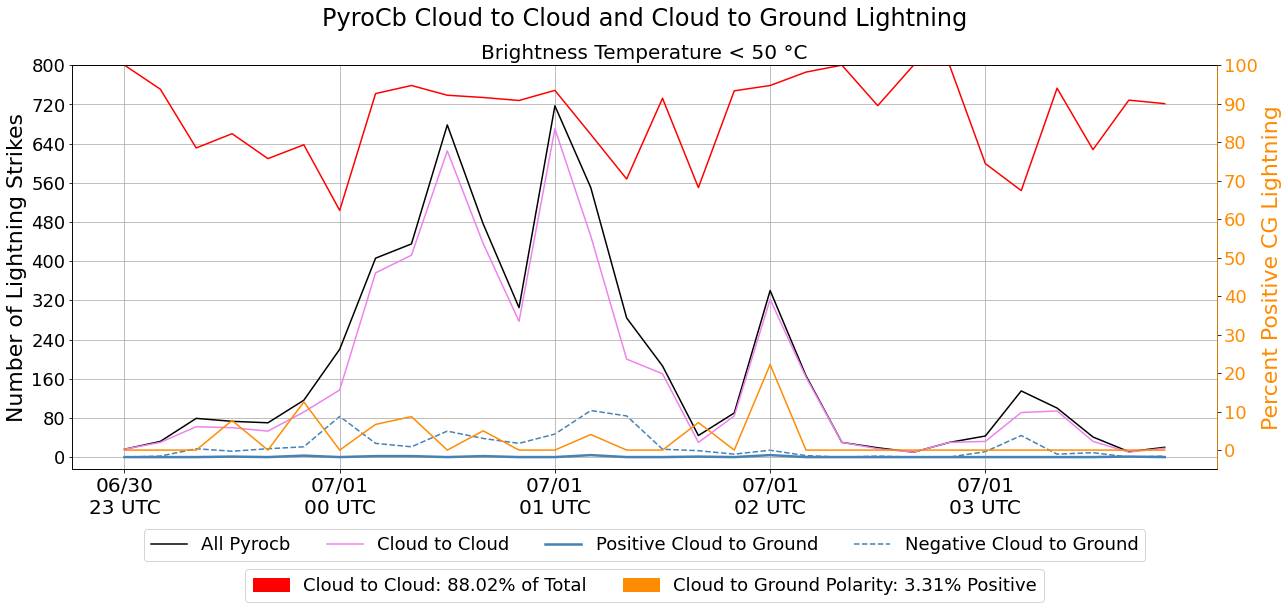

In [103]:
fig,ax = plt.subplots(figsize=(18,8))

xValues = np.arange(0, 30, 1)
xticks = np.arange(0, 30, 6)
yticks = np.arange(0, 801, 80)

ax.plot(xValues, d1["num_strikes_pyrocb"], "k-", linewidth = 1.5, label = "All Pyrocb")
ax.plot(xValues, d1["cloud_pyrocb"], color = "violet", linewidth = 1.5, linestyle = "solid", label = "Cloud to Cloud")
ax.plot(xValues, d1["pos_cloud_ground_pyrocb"], color = "steelblue", linewidth = 2.5, linestyle = "solid", label = "Positive Cloud to Ground", zorder = 2)
ax.plot(xValues, d1["neg_cloud_ground_pyrocb"], color = "steelblue", linewidth = 1.5, linestyle = "dashed", label = "Negative Cloud to Ground", zorder = 1)

ax.set_ylim((-25,800))
ax.set_ylabel("Number of Lightning Strikes", fontsize = 22)

plt.legend(loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=4, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
labels = ["06/30 23 UTC", "07/01 00 UTC", 
          "07/01 01 UTC", "07/01 02 UTC", "07/01 03 UTC"]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 20)
ax.set_yticklabels(yticks, fontsize = 18)
plt.grid()

yticks2 = np.arange(0, 101, 10)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(xValues, d1["percent_cloud_pyrocb"], color="red", linewidth = 1.5)
ax2.plot(xValues, d1["percent_pos_current_cloud_ground_pyrocb"], color="darkorange", linewidth = 1.5)
ax2.set_ylabel("Percent Positive CG Lightning", color="darkorange",fontsize=22)
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2, fontsize = 18,  color="darkorange")
ax2.set_ylim((-5,100))
ax2.spines['right'].set_color('darkorange')

red_patch = mpatches.Patch(color='red', label='Cloud to Cloud: {:.2f}% of Total'.format(np.mean(d1["percent_cloud_pyrocb"][4:-6])))
orange_patch = mpatches.Patch(color='darkorange', label='Cloud to Ground Polarity: {:.2f}% Positive'.format(np.mean(d1["percent_pos_current_cloud_ground_pyrocb"][4:-6])))
plt.legend(handles=[red_patch, orange_patch],loc='lower center', 
    bbox_to_anchor=(0.5, -0.35),
    ncol=4, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

#plt.grid()
plt.tight_layout()
plt.suptitle("PyroCb Cloud to Cloud and Cloud to Ground Lightning", y=1.07, fontsize = 24) 
degree_sign = u'\N{DEGREE SIGN}'

plt.title("Brightness Temperature < 50 {}C".format(degree_sign),  fontsize = 20) 

# plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'
# plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)

plt.savefig("pyrocb_timeseries_bt_all.png", bbox_inches = "tight", dpi = 500)


### box and whisker 

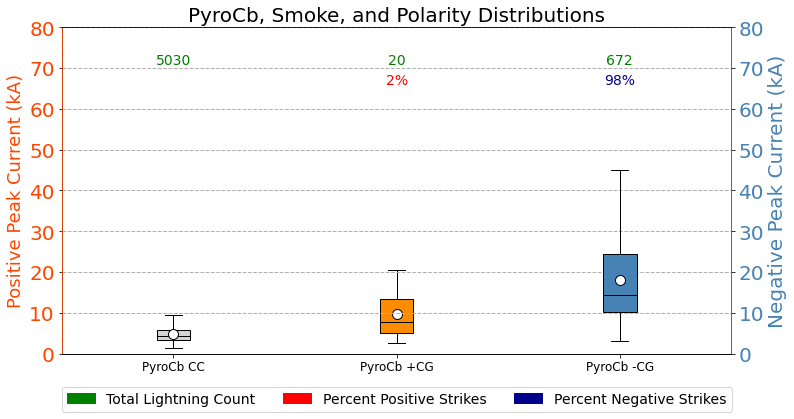

In [104]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title('PyroCb, Smoke, and Polarity Distributions', fontsize = 20)
ax.set_ylabel("Positive Peak Current (kA)", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 20, color = "orangered")

data = [np.abs(pyrocb_cloud_flat), pyrocb_pos_ground_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1]) # , positions = [0, 2, 4, 6]

yticks2 = np.arange(0, 80, 8)
ax2=ax.twinx()

data2 = [np.abs(pyrocb_neg_ground_flat)] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2]) # 

ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 80)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["PyroCb CC", "PyroCb +CG", "PyroCb -CG"]  
ax.set_xticklabels(labels, fontsize = 12)


# pyrocb length count 
plt.annotate("{:.0f}".format(len(pyrocb_cloud_flat)), xy =(0, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_pos_ground_flat)), xy =(1, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_neg_ground_flat)), xy =(2, 71), fontsize = 14, color = "green", ha='center')

# pyrocb percentage 
plt.annotate("{:.0f}%".format(np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(1, 66), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(2, 66), fontsize = 14, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.savefig("boxplot_posneg_bt_pyrocb.png",bbox_inches = "tight", dpi = 800)
plt.show()


### combo histogram and box and whisker 

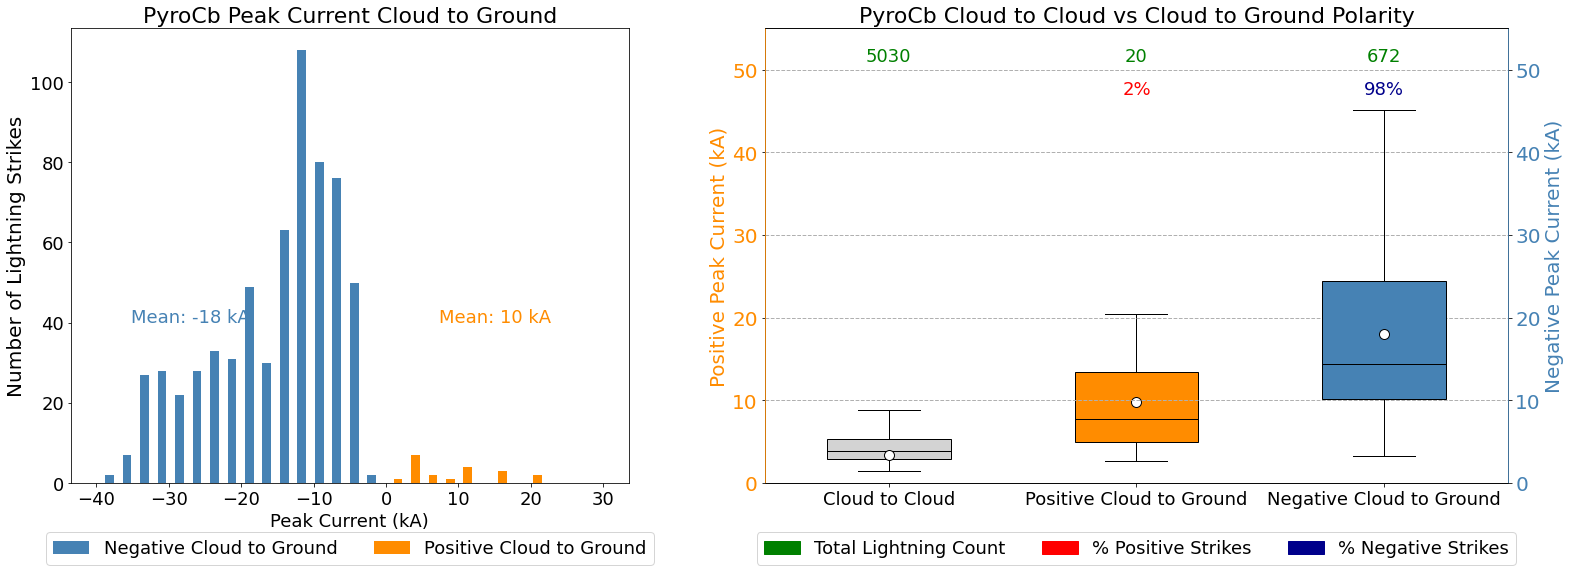

In [105]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-40, 30, 30)

ax0.hist([pyrocb_pos_ground_flat, pyrocb_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("PyroCb Peak Current Cloud to Ground", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.2),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_neg_ground_flat)), xy =(-27, 40), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_pos_ground_flat)), xy =(15, 40), fontsize = 18, color = "darkorange", ha='center')


ax1 = plt.subplot(gs[1])

ax1.set_title('PyroCb Cloud to Cloud vs Cloud to Ground Polarity', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 55)
plt.yticks(fontsize = 20, color = "darkorange")

data = [pyrocb_cloud_flat, pyrocb_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 90, 10)
ax2=ax1.twinx()
data2 = [np.abs(pyrocb_neg_ground_flat)] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 55)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(pyrocb_cloud_flat)), xy =(0, 51), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_pos_ground_flat)), xy =(1, 51), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_neg_ground_flat)), xy =(2, 51), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(1, 47), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(2, 47), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.tight_layout()

plt.savefig("histogram_boxplot_vaisala.png",bbox_inches = "tight", dpi = 800)
plt.show()


# SMOKE

## colorbar map

/tmp/ipykernel_186682/3832293618.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


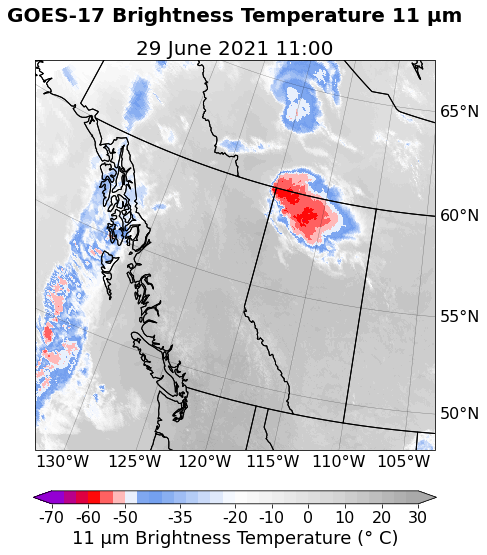

In [106]:
fig = plt.figure(figsize=(8, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(3, 4, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_smoke/' + folder_names_smoke[i] + '/'
        FILE = path + file_names_smoke[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        #pc = ccrs.PlateCarree()
        pc = ccrs.LambertConformal()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
       # ax.set_extent([-128, -108, 48, 64], crs=pc)
        #ax.set_extent([-135, -105, 48, 64], ccrs.Geodetic())
        ax.set_extent([-135, -105, 48, 64], ccrs.PlateCarree())

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

       ## gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)
        gl = ax.gridlines(draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)

#         gl.xlines = True
#       #  gl.xlocator = mticker.FixedLocator([ -127, -125, -123, -121, -119, -117, -115, -113, -111, -109, -107, -105])
        gl.xlocator = mticker.FixedLocator([ -130,  -125,  -120,  -115,  -110, -105])

        gl.ylocator = mticker.FixedLocator([50,  55, 60, 65])
        gl.left_labels = gl.top_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'rotation': 0, 'size': 16, 'color': 'black'}
        gl.ylabel_style = {'rotation': 0, 'size': 16, 'color': 'black'} #, 'weight': 'bold'

        colormap = LinearSegmentedColormap.from_list('custom', 
                               [#(0, "darkviolet"), 
                                        (0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                       # (0.25, "lightsteelblue"),
                                        (0.25, "cornflowerblue"), 
#                                         (0.5, 'cornflowerblue'),
#                                         (0.6,   'lightsteelblue'),
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        #(1.0, 'grey')
                                        ], N=30)
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_smoke_MAP_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## comparing lat lon two csv files

### testing

In [107]:
"""br_temp_smoke = pd.read_csv('/data2/edworak/data/bt_df_smoke.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])

lightning_df_smoke = []
# get it all into one 
# then limit it by time 
hours = [8, 9, 10, 11]
# can't do hour 12 becasue no birghness temperature 
mins = range(0, 60, 5)

def find_nearest_smoke(lat, long):
    distances = br_temp_smoke_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return br_temp_smoke_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        data_smoke_time = data_smoke.loc[(data_smoke.hour == hours[i]) & (data_smoke.minute >= mins[j]) & (data_smoke.minute <= mins[j] + 4)]
        br_temp_smoke_time = br_temp_smoke.loc[(br_temp_smoke.hour == hours[i])& (br_temp_smoke.minute >= mins[j]) & (br_temp_smoke.minute <= mins[j] + 4)] 
        
        if (len(data_smoke_time) >0) & (len(br_temp_smoke_time) >0): 
            
            data_smoke_time['CMI_C14'] = data_smoke_time.apply(
                lambda row: find_nearest_smoke(row['lat'], row['lon']), axis=1)

            data_smoke_time = pd.merge(data_smoke_time, br_temp_smoke_time[['CMI_C14','lat','lon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_smoke_time = data_smoke_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'bt_lat','lon_y':'bt_lon'})

            data_smoke_time['distance(km)'] = [haversine(data_smoke_time.l_lon[i],data_smoke_time.l_lat[i],
                                                 data_smoke_time.bt_lon[i],data_smoke_time.bt_lat[i]) 
                                                 for i in range(len(data_smoke_time))]
            data_smoke_time['distance(km)'] = data_smoke_time['distance(km)'].round(decimals=3)
            data_smoke_close = data_smoke_time.loc[data_smoke_time["distance(km)"] < 10]

            if len(lightning_df_smoke) == 0: 
                lightning_df_smoke = data_smoke_close
            else: 
                lightning_df_smoke = pd.concat([lightning_df_smoke, data_smoke_close], axis =0)
            lightning_df_smoke
         """

'br_temp_smoke = pd.read_csv(\'/data2/edworak/data/bt_df_smoke.nc\', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])\n\nlightning_df_smoke = []\n# get it all into one \n# then limit it by time \nhours = [8, 9, 10, 11]\n# can\'t do hour 12 becasue no birghness temperature \nmins = range(0, 60, 5)\n\ndef find_nearest_smoke(lat, long):\n    distances = br_temp_smoke_time.apply(lambda row: dist(lat, long, row[\'lat\'], row[\'lon\']), axis=1)\n    return br_temp_smoke_time.loc[distances.idxmin(), "CMI_C14"]\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        print(i)\n        data_smoke_time = data_smoke.loc[(data_smoke.hour == hours[i]) & (data_smoke.minute >= mins[j]) & (data_smoke.minute <= mins[j] + 4)]\n        br_temp_smoke_time = br_temp_smoke.loc[(br_temp_smoke.hour == hours[i])& (br_temp_smoke.minute >= mins[j]) & (br_temp_smoke.minute <= mins[j] + 4)] \n        \n        if (len(data_smoke_time) >0) & (len(br_temp_smoke_time) >

In [108]:
#lightning_df_smoke.to_csv("/data2/edworak/data/lightning_df_smoke.csv", sep='\t', encoding='utf-8')
#lightning_df_smoke

lt_bt_smoke = pd.read_csv("/data2/edworak/data/lightning_df_smoke.csv", sep='\t')
lt_bt_smoke = lt_bt_smoke.drop_duplicates(subset=["l_lat", "l_lon"], keep='first')
lt_bt_smoke

Unnamed: 0  year  month  day  hour  minute  second   l_lat    l_lon  \
0              32  2021      6   29     8      15       0  58.900 -119.250   
3              75  2021      6   29     8      15       0  58.473 -117.835   
4             100  2021      6   29     8      15       0  58.437 -117.829   
7             130  2021      6   29     8      15       0  58.442 -117.811   
9             165  2021      6   29     8      15       1  58.571 -118.584   
...           ...   ...    ...  ...   ...     ...     ...     ...      ...   
18206       36837  2021      6   29    11      39      58  59.180 -118.846   
18207       36888  2021      6   29    11      39      58  58.397 -115.482   
18208       36891  2021      6   29    11      39      59  59.333 -119.397   
18209       36898  2021      6   29    11      39      59  59.349 -119.377   
18210       36901  2021      6   29    11      39      59  59.357 -119.384   

       peak-current C or G  multi polarity     range    CMI_C14     bt_lat  \
0               4.2      C      0        +  11775.00 -52.111330  58.924843   
3               5.4      C      0        +  11797.18 -53.966705  58.469370   
4               5.7      C      0        +  11799.07 -53.667450  58.473780   
7              15.6      C      0        +  11798.83 -54.086395  58.466385   
9               5.1      C      0        +  11792.10 -51.452972  58.573180   
...             ...    ...    ...      ...       ...        ...        ...   
18206           3.9      C      0        +  11760.39 -19.013870  59.202140   
18207         -92.2      G      0        -  11376.84 -55.163727  58.420780   
18208          39.7      G      0        +  11752.34  -5.248200  59.323765   
18209           8.5      C      0        +  11751.56  -7.283112  59.325370   
18210           3.7      C      0        +  11751.10  -8.659698  59.375950   

           bt_lon  distance(km)  
0     -119.348460         6.292  
3     -117.839960         0.496  
4     -117.756390         5.879  
7     -117.882300         4.956  
9     -118.584280         0.243  
...           ...           ...  
18206 -118.858860         2.568  
18207 -115.466210         2.800  
18208 -119.402390         1.071  
18209 -119.360504         2.789  
18210 -119.371900         2.216  

[12086 rows x 18 columns]

In [109]:
lt_bt_smoke["l_lat"] = lt_bt_smoke["l_lat"] + 0.383768
lt_bt_smoke["l_lon"] = lt_bt_smoke["l_lon"] + 0.279104

### checking with a map

/tmp/ipykernel_186682/3600250990.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


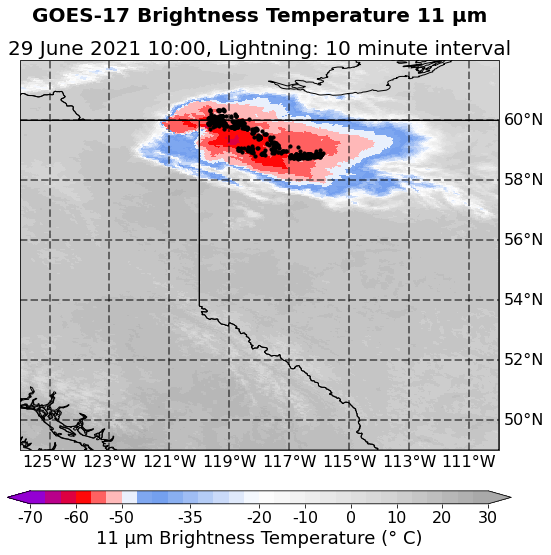

In [110]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(2, 3, 1):
    for j in range(0,1,1):
        path = '/data2/edworak/data/BT_smoke/' + folder_names_smoke[i] + '/'
        FILE = path + file_names_smoke[i][j]
        
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-126, -110, 49, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}, Lightning: 10 minute interval'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'
    
        colormap = LinearSegmentedColormap.from_list('custom', 
                                            [#(0, "darkviolet"), 
                                            (0, "darkviolet"), 
                                            (0.1, "red"), 
                                            (0.2, "white"),
                                            (0.25, "cornflowerblue"), 
                                            (0.5, 'white'),
                                            (0.8, 'lightgrey'), 
                                            (1.0, 'darkgrey')
                                            ], N=30)
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        

        points = lt_bt_smoke.loc[(lt_bt_smoke.hour == 10) & (lt_bt_smoke.minute <= 10)] # & (lt_bt_smoke.minute <= 10)

        plt.scatter(x = points["l_lon"], y = points["l_lat"], s = 10, color = "black", marker = "o")

        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_smoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## smoke analysis for BT < -50 C

### smoke for loop

In [111]:
lt_bt_smoke = pd.read_csv("/data2/edworak/data/lightning_df_smoke.csv", sep='\t')
lt_bt_smoke = lt_bt_smoke.drop_duplicates(subset=["l_lat", "l_lon"], keep='first')

hours29 = [8, 9, 10, 11]
# can't do hour 12 becasue no birghness temperature 
mins29 = range(0, 60, 10)

num_strikes_smoke = np.zeros((len(hours29), len(mins29)))
mean_current_smoke = np.zeros((len(hours29), len(mins29)))
mean_pos_current_smoke = np.zeros((len(hours29), len(mins29)))
mean_neg_current_smoke = np.zeros((len(hours29), len(mins29)))
percent_pos_current_smoke = np.zeros((len(hours29), len(mins29)))
num_pos_current_smoke =  np.zeros((len(hours29), len(mins29)))
num_neg_current_smoke =  np.zeros((len(hours29), len(mins29)))
cloud_smoke =  np.zeros((len(hours29), len(mins29)))
cloud_ground_smoke =  np.zeros((len(hours29), len(mins29)))
pos_cloud_ground_smoke =  np.zeros((len(hours29), len(mins29)))
neg_cloud_ground_smoke =  np.zeros((len(hours29), len(mins29)))
pos_cloud_smoke =  np.zeros((len(hours29), len(mins29)))
neg_cloud_smoke =  np.zeros((len(hours29), len(mins29)))
percent_pos_current_cloud_ground_smoke =  np.zeros((len(hours29), len(mins29)))
percent_pos_current_cloud_smoke =  np.zeros((len(hours29), len(mins29)))

def smoke_function(lt_bt_smoke):
        for i in range(len(hours29)): 
            for j in range(len(mins29)): 
                
                    time = lt_bt_smoke.loc[(lt_bt_smoke.CMI_C14 <= -50) & (lt_bt_smoke.hour == hours29[i]) & (lt_bt_smoke.minute >= mins29[j]) & (lt_bt_smoke.minute <= mins29[j] + 9)]
                
                    
                    strikes_smoke = (time.loc[(time["l_lon"] >= -122)& (time["l_lon"] <= -114) & 
                                                (time["l_lat"] >= 58) & (time["l_lat"] <= 60.5)])
                    

                    if len(strikes_smoke) >= 1: 
                    
                        num_strikes_smoke[i,j] = len(strikes_smoke)
                        mean_current_smoke[i,j] = np.mean(abs(strikes_smoke["peak-current"]))

                        pos_current_smoke = strikes_smoke.loc[(strikes_smoke["peak-current"] > 0)]
                        num_pos_current_smoke[i,j]= len(pos_current_smoke)
                        mean_pos_current_smoke[i,j] = np.mean(pos_current_smoke["peak-current"])

                        neg_current_smoke = strikes_smoke.loc[(strikes_smoke["peak-current"] < 0)]
                        num_neg_current_smoke[i,j] = len(neg_current_smoke)
                        mean_neg_current_smoke[i,j] = np.mean(neg_current_smoke["peak-current"])
                        
                        cloud_count_smoke = strikes_smoke.loc[(strikes_smoke["C or G"] == "C")]
                        cloud_smoke[i,j] = len(cloud_count_smoke)
                        pos_cloud_count_smoke = cloud_count_smoke.loc[(cloud_count_smoke["peak-current"] > 0)]
                        pos_cloud_smoke[i,j] = len(pos_cloud_count_smoke)
                        neg_cloud_count_smoke = cloud_count_smoke.loc[(cloud_count_smoke["peak-current"] < 0)]
                        neg_cloud_smoke[i,j] = len(neg_cloud_count_smoke)
                        
                        ground_count_smoke = strikes_smoke.loc[(strikes_smoke["C or G"] == "G")]
                        cloud_ground_smoke[i, j] = len(ground_count_smoke)
                        pos_cloud_ground_count_smoke = ground_count_smoke.loc[(ground_count_smoke["peak-current"] > 0)]
                        pos_cloud_ground_smoke[i,j] = len(pos_cloud_ground_count_smoke)
                        neg_cloud_ground_count_smoke= ground_count_smoke.loc[(ground_count_smoke["peak-current"] < 0)]
                        neg_cloud_ground_smoke[i,j] = len(neg_cloud_ground_count_smoke)
                        
                        if len(strikes_smoke) > 2: 
                            percent_pos_current_smoke[i,j] = (len(pos_current_smoke["peak-current"]) / len(strikes_smoke)) * 100
                        
                        if len(cloud_count_smoke) > 2:    
                            percent_pos_current_cloud_smoke[i,j] = (len(pos_cloud_count_smoke["peak-current"]) / len(cloud_count_smoke)) * 100
                        
                        if len(ground_count_smoke) > 2:  
                            percent_pos_current_cloud_ground_smoke[i,j] = (len(pos_cloud_ground_count_smoke["peak-current"]) / len(ground_count_smoke)) * 100

        return(num_strikes_smoke, percent_pos_current_smoke, num_pos_current_smoke, num_neg_current_smoke, 
            mean_current_smoke, mean_pos_current_smoke, mean_neg_current_smoke, cloud_smoke, 
            cloud_ground_smoke, pos_cloud_smoke,  neg_cloud_smoke, pos_cloud_ground_smoke,  neg_cloud_ground_smoke, 
             percent_pos_current_cloud_smoke, percent_pos_current_cloud_ground_smoke)


In [112]:
d29 = {}

names29 = ["num_strikes_smoke", "percent_pos_current_smoke", "num_pos_current_smoke", "num_neg_current_smoke", 
           "mean_current_smoke", "mean_pos_current_smoke", "mean_neg_current_smoke", "cloud_smoke",
         "cloud_ground_smoke", "pos_cloud_smoke",  "neg_cloud_smoke", "pos_cloud_ground_smoke",  "neg_cloud_ground_smoke", 
        "percent_pos_current_cloud_smoke", "percent_pos_current_cloud_ground_smoke"]


for i in range(0, len(names29)):
    a29 = smoke_function(lt_bt_smoke)[i]
    b29 = [item for sublist in a29 for item in sublist]
    d29[names29[i]] = b29

print(np.mean(d29["percent_pos_current_smoke"]))   

print(np.mean(d29["percent_pos_current_cloud_ground_smoke"]))   

27.444690685171267
3.778234969603163


### nested 

In [113]:
hours29 = [8, 9, 10, 11]
# can't do hour 12 becasue no birghness temperature 
mins29 = range(0, 60, 10)

smoke_cloud_array = []
smoke_ground_array = []
smoke_neg_cloud_array = []
smoke_pos_cloud_array = []
smoke_neg_ground_array = []
smoke_pos_ground_array = []

for i in range(len(hours29)): 
    for j in range(len(mins29)):   


        time = lt_bt_smoke.loc[(lt_bt_smoke.CMI_C14 <= -50) & (lt_bt_smoke.hour == hours29[i]) & (lt_bt_smoke.minute >= mins29[j]) & (lt_bt_smoke.minute <= mins29[j] + 9)]
                
                    
        strikes_smoke = (time.loc[(time["l_lon"] >= -122)& (time["l_lon"] <= -114) & 
                                    (time["l_lat"] >= 58) & (time["l_lat"] <= 60.5)])
        
        if len(strikes_smoke) >= 1: 
            smoke_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "C")]["peak-current"]))
            smoke_ground_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "G")]["peak-current"]))
            
            smoke_pos_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] > 0) & (strikes_smoke["C or G"] == "C")]["peak-current"]))
            smoke_neg_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] < 0) & (strikes_smoke["C or G"] == "C")]["peak-current"]))
            
            smoke_pos_ground_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] > 0) & (strikes_smoke["C or G"] == "G")]["peak-current"]))
            smoke_neg_ground_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] < 0) & (strikes_smoke["C or G"] == "G")]["peak-current"]))

smoke_cloud_flat = [item for sublist in smoke_cloud_array for item in sublist]
smoke_ground_flat = [item for sublist in smoke_ground_array for item in sublist]
smoke_neg_cloud_flat = [item for sublist in smoke_neg_cloud_array for item in sublist]
smoke_pos_cloud_flat = [item for sublist in smoke_pos_cloud_array for item in sublist]
smoke_neg_ground_flat = [item for sublist in smoke_neg_ground_array for item in sublist]
smoke_pos_ground_flat = [item for sublist in smoke_pos_ground_array for item in sublist]


In [114]:
print(np.mean(smoke_neg_ground_flat))
print(np.mean(smoke_pos_ground_flat))

-24.88975975975976
28.974999999999998


## Final BT map with lightning

In [115]:
"""Latitude
61.715 °
Longitude
-123.694 °

Latitude
60.709 °
Longitude
-125.289 °

Latitude
57.514 °
Longitude
-123.021 °

Latitude
59.581 °
Longitude
-120.533 °

[61.715,  60.709, 57.514, 59.581]
[-123.694, -125.289, -123.021, -120.533]"""

'Latitude\n61.715 °\nLongitude\n-123.694 °\n\nLatitude\n60.709 °\nLongitude\n-125.289 °\n\nLatitude\n57.514 °\nLongitude\n-123.021 °\n\nLatitude\n59.581 °\nLongitude\n-120.533 °\n\n[61.715,  60.709, 57.514, 59.581]\n[-123.694, -125.289, -123.021, -120.533]'

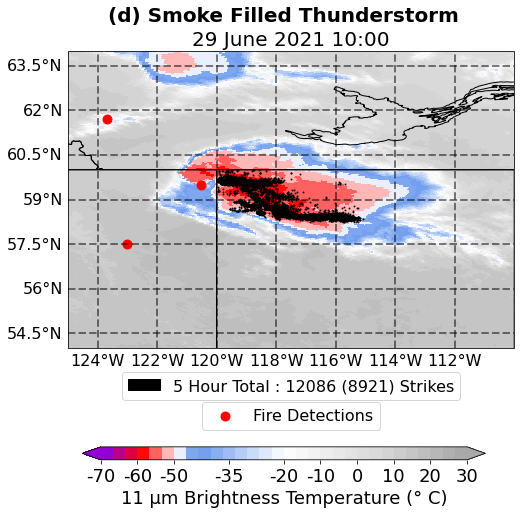

In [116]:
fig = plt.figure(figsize=(8, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(2, 3, 1):
    for j in range(0,1,1):
        path = '/data2/edworak/data/BT_smoke/' + folder_names_smoke[i] + '/'
        FILE = path + file_names_smoke[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-125, -110, 54, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([ -124,  -122,  -120,  -118, -116, -114, -112])

        gl.ylocator = mticker.FixedLocator([54.5, 56, 57.5, 59, 60.5, 62, 63.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'
        ax.tick_params(axis='both', which='major', pad=50)
        
        
        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colormap = LinearSegmentedColormap.from_list('custom', 
                                                [#(0, "darkviolet"), 
                                                (0, "darkviolet"), 
                                                (0.1, "red"), 
                                                (0.2, "white"),
                                                (0.25, "cornflowerblue"), 
                                                (0.5, 'white'),
                                                (0.8, 'lightgrey'), 
                                                (1.0, 'darkgrey')
                                                ], N=30)
        
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        points = lt_bt_smoke.loc[(lt_bt_smoke.CMI_C14 <= -50) & (lt_bt_smoke.hour >= 8) & (lt_bt_smoke.hour <= 12)]
        points_all = lt_bt_smoke.loc[(lt_bt_smoke.hour >= 8) & (lt_bt_smoke.hour <= 12)]

        ax.scatter(x = points["l_lon"], y = points["l_lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        

        patch = mpatches.Patch(facecolor='black', edgecolor = "black", label="5 Hour Total : {} ({}) Strikes".format(str(len(points_all)), str(len(points))))

#         #plt.legend(handles=[green_patch], fontsize = 14)
        firstlegend =  ax.legend(handles=[patch], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)
        ax.add_artist(firstlegend)
        
        
        fire_lat = [61.715,  60.709, 57.514, 59.481]
        fire_lon = [-123.694, -125.289, -123.021, -120.533]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        ax.legend(fontsize = 16, loc='lower center', 
                    bbox_to_anchor=(0.5, -0.3),)
        
        
       # tstorm_subregion_box(ax, im)
       # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        #plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle('(d) Smoke Filled Thunderstorm', fontweight='bold', fontsize=20, y = 0.95)
plt.savefig("BT_smoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## smoke analysis

### smoke histogram

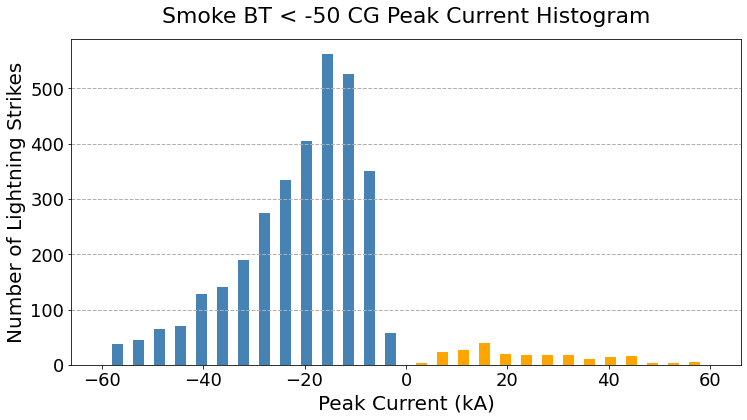

In [117]:


fig = plt.figure(figsize=(12,6))

# points = lt_bt_smoke.loc[(lt_bt_smoke["C or G"] == "G") & (lt_bt_smoke["CMI_C14"] <= -50)]
# weights = np.ones_like(points["peak-current"]) / len(points["peak-current"])


weights1 = np.ones_like(smoke_pos_ground_flat) / len(smoke_pos_ground_flat)
weights2= np.ones_like(smoke_neg_ground_flat) / len(smoke_neg_ground_flat)

colors = ["orange", "steelblue"]

bins = np.linspace(-60, 60, 30)

plt.hist([smoke_pos_ground_flat, smoke_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Cloud", "Negative Cloud to Cloud"]) 
order = [1,0]

#plt.hist([points["peak-current"]], bins, alpha = 1, histtype='bar', color=colors, rwidth=0.6) 

plt.grid(axis='y', linestyle='--', linewidth=1)
plt.title("Smoke BT < -50 CG Peak Current Histogram", fontsize = 22, y = 1.03)
plt.xlabel("Peak Current (kA)", fontsize = 20)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_neg_ground_flat)), xy =(-40, 800), fontsize = 22, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_pos_ground_flat)), xy =(40, 800), fontsize = 22, color = "darkorange", ha='center')

#plt.ylim(0, 4500)
plt.savefig("smoke_histogram_bt", dpi = 200)
dpi = 400
plt.show()

### smoke timeseries

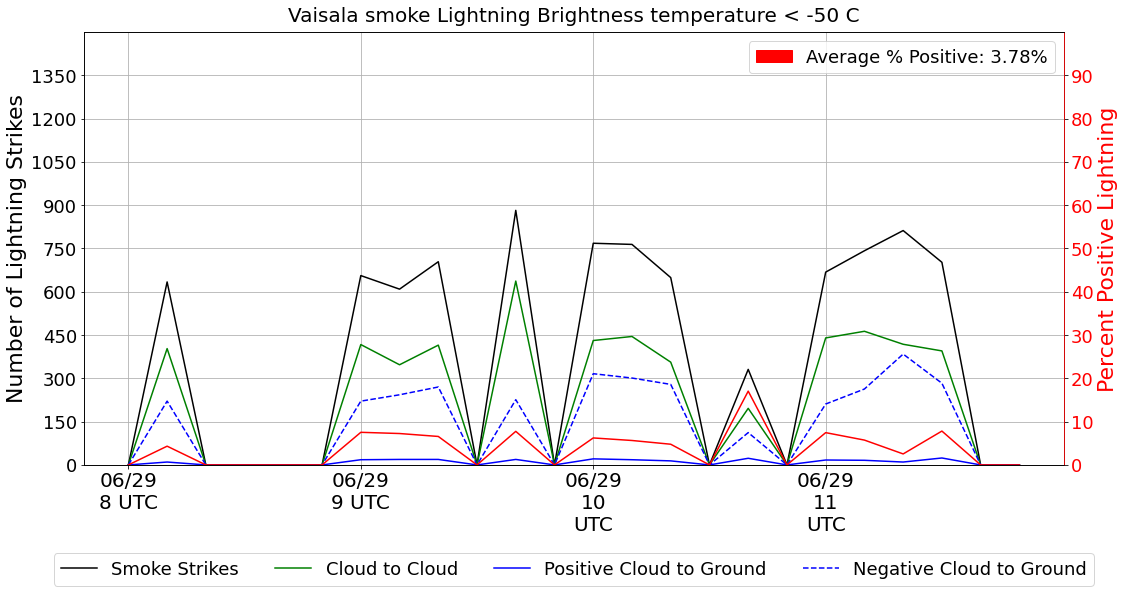

In [118]:

fig,ax = plt.subplots(figsize=(16,8))

xValues = np.arange(0, 24, 1)
xticks = np.arange(0, 24, 6)
yticks = np.arange(0, 1500, 150)
# plt.plot(time (x axis), number of lightning strikes (y axis) , color and line style, label = "label")

ax.plot(xValues, d29["num_strikes_smoke"], "k-", label = "Smoke Strikes")
ax.plot(xValues, d29["cloud_smoke"], "g", label = "Cloud to Cloud")
ax.plot(xValues, d29["pos_cloud_ground_smoke"], "b", label = "Positive Cloud to Ground")
ax.plot(xValues, d29["neg_cloud_ground_smoke"], "b--", label = "Negative Cloud to Ground")

ax.set_ylim((0,1500))
#ax.set_xlabel("Date and Time", fontsize = 18)
ax.set_ylabel("Number of Lightning Strikes", fontsize = 22)
# ax.legend(loc = "upper left", fontsize = 18)
plt.legend( loc='lower center', 
    bbox_to_anchor=(0.5, -0.3),
    ncol=4, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
labels = ["06/29 8 UTC", "06/29 9 UTC", "06/29 10 UTC", "06/29 11 UTC"]
labels = ['\n'.join(wrap(l, 5)) for l in labels]
ax.set_xticklabels(labels, fontsize = 20)
ax.set_yticklabels(yticks, fontsize = 18)
plt.grid()

yticks2 = np.arange(0, 100, 10)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(xValues, d29["percent_pos_current_cloud_ground_smoke"], color="red")
ax2.set_ylabel("Percent Positive Lightning", color="red",fontsize=22)
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2, fontsize = 18,  color="red")
ax2.set_ylim((0,100))
ax2.spines['right'].set_color('red')

red_patch = mpatches.Patch(color='red', label='Average % Positive: {:.2f}%'.format(np.mean(d29["percent_pos_current_cloud_ground_smoke"])))
plt.legend(handles=[red_patch], fontsize = 18)

#plt.grid()
plt.tight_layout()
plt.title("Vaisala smoke Lightning Brightness temperature < -50 C", y=1.01, fontsize = 20) 

plt.savefig("smoke_timeseries_bt.png", bbox_inches = "tight", dpi = 500)


### box and whisker

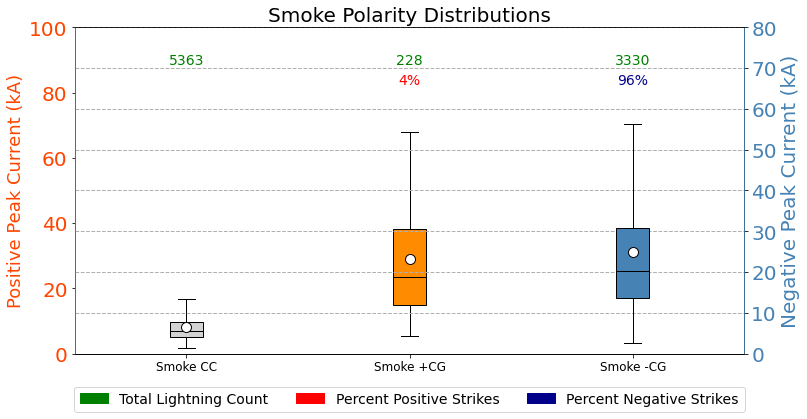

In [119]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title('Smoke Polarity Distributions', fontsize = 20)
ax.set_ylabel("Positive Peak Current (kA)", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 100)
plt.yticks(fontsize = 20, color = "orangered")

data = [ list(map(abs,smoke_cloud_flat)), smoke_pos_ground_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1]) # , positions = [0, 2, 4, 6]

yticks2 = np.arange(0, 100, 10)
ax2=ax.twinx()

data2 = [list(map(abs, smoke_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2]) # 

ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 80)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Smoke CC", "Smoke +CG", "Smoke -CG"]  
ax.set_xticklabels(labels, fontsize = 12)


# smoke length count 
plt.annotate("{:.0f}".format(len(smoke_cloud_flat)), xy =(0, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_pos_ground_flat)), xy =(1, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_neg_ground_flat)), xy =(2, 71), fontsize = 14, color = "green", ha='center')

# smoke percentage 
plt.annotate("{:.0f}%".format(np.mean(d29["percent_pos_current_cloud_ground_smoke"])), xy =(1, 66), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d29["percent_pos_current_cloud_ground_smoke"])), xy =(2, 66), fontsize = 14, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.savefig("boxplot_posneg_bt_smoke.png",bbox_inches = "tight", dpi = 800)
plt.show()


# combined three cases

### combined histograms

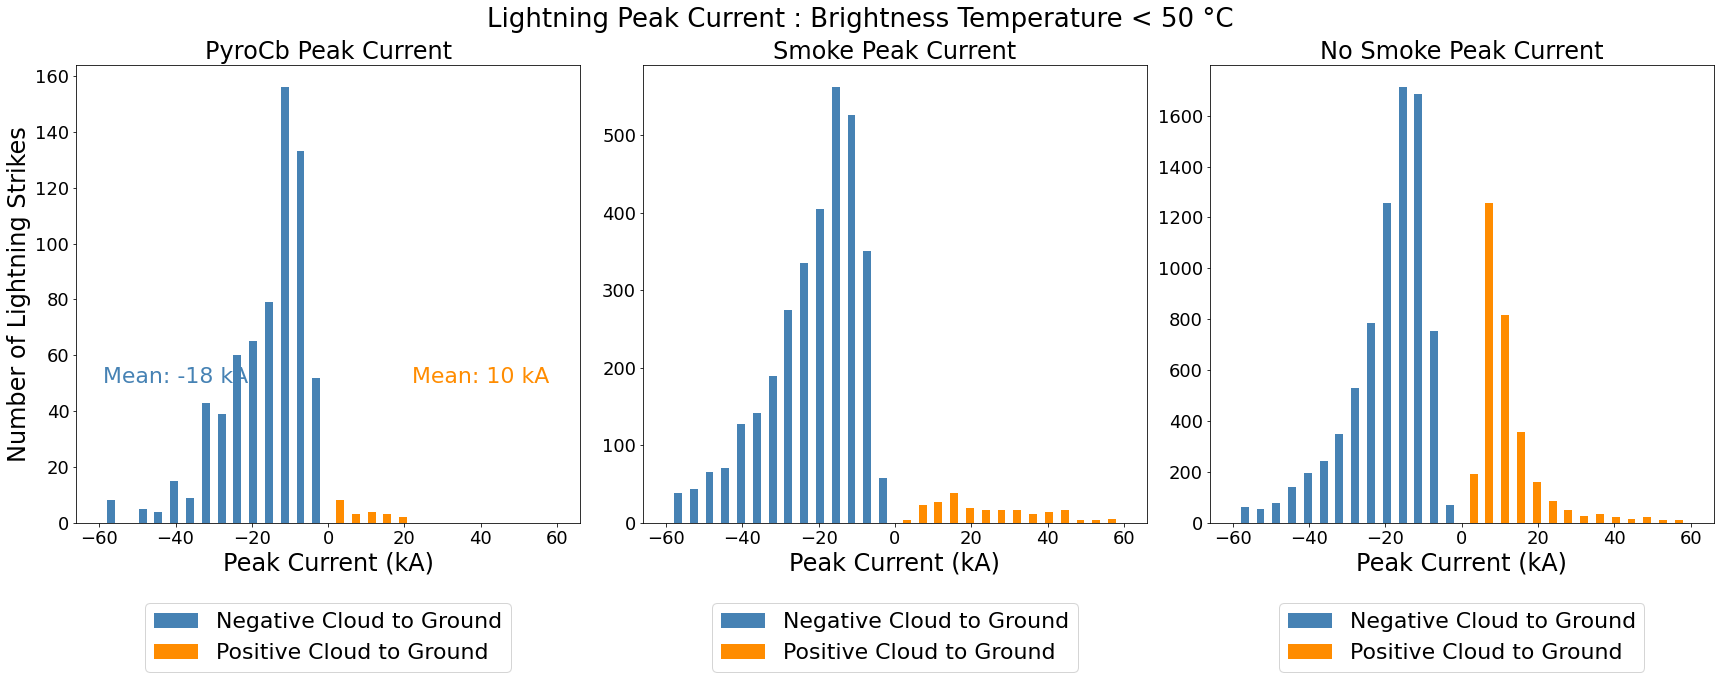

In [120]:
fig = plt.figure(figsize=(24,10))

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 30)

ax = plt.subplot(1,3,1)

ax.hist([pyrocb_pos_ground_flat, pyrocb_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 
plt.title("PyroCb Peak Current", fontsize = 24)
degree_sign = u'\N{DEGREE SIGN}'
plt.suptitle("Lightning Peak Current : Brightness Temperature < 50 {}C".format(degree_sign),  fontsize = 26) 


plt.xlabel("Peak Current (kA)", fontsize = 24)
plt.ylabel("Number of Lightning Strikes", fontsize = 24)
plt.legend(loc = "upper left", fontsize = 16)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#plt.ylim(0,3000)

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

#add legend to plot
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.35),
    ncol=1, fancybox=True, shadow=False, fontsize = 22, markerscale=3.)

plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_neg_ground_flat)), xy =(-40, 50), fontsize = 22, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_pos_ground_flat)), xy =(40, 50), fontsize = 22, color = "darkorange", ha='center')

##################

ax = plt.subplot(1,3,2)

ax.hist([smoke_pos_ground_flat, smoke_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Smoke Peak Current", fontsize = 24)

plt.xlabel("Peak Current (kA)", fontsize = 24)
#plt.ylabel("Number of Lightning Strikes", fontsize = 20)

plt.legend(loc = "upper right", fontsize = 16)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.35),
    ncol=1, fancybox=True, shadow=False, fontsize = 22, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_neg_ground_flat)), xy =(-40, 670), fontsize = 22, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_pos_ground_flat)), xy =(40, 670), fontsize = 22, color = "darkorange", ha='center')

###############

ax = plt.subplot(1,3,3)

ax.hist([nosmoke_pos_ground_flat, nosmoke_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("No Smoke Peak Current", fontsize = 24)

plt.xlabel("Peak Current (kA)", fontsize = 24)

plt.legend(loc = "upper right", fontsize = 16)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.35),
    ncol=1, fancybox=True, shadow=False, fontsize = 22, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(nosmoke_neg_ground_flat)), xy =(-40, 2000), fontsize = 22, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(nosmoke_pos_ground_flat)), xy =(40, 2000), fontsize = 22, color = "darkorange", ha='center')

plt.tight_layout()

plt.savefig("cloud_ground_split_histogram", dpi = 200)
plt.show()


### box and whisker all cases

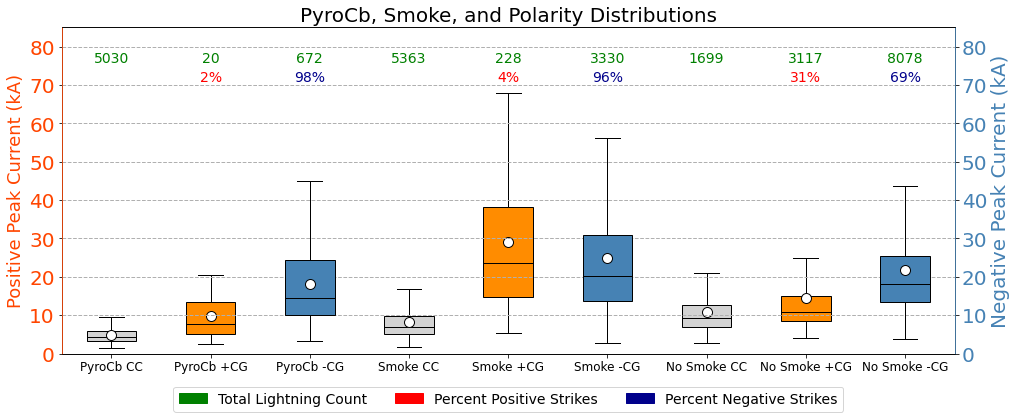

In [121]:

fig, ax = plt.subplots(figsize = (16,6))

ax.set_title('PyroCb, Smoke, and Polarity Distributions', fontsize = 20)
ax.set_ylabel("Positive Peak Current (kA)", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 85)
plt.yticks(fontsize = 20, color = "orangered")

data = [np.abs(pyrocb_cloud_flat), pyrocb_pos_ground_flat, np.abs(smoke_cloud_flat), 
        smoke_pos_ground_flat, np.abs(nosmoke_cloud_flat), nosmoke_pos_ground_flat]


# data = [pyrocb_cloud_flat, pyrocb_pos_ground_flat]
# data2 = [list(map(abs,pyrocb_neg_ground_flat))] 


box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 3, 4, 6, 7]) # , positions = [0, 2, 4, 6]

yticks2 = np.arange(0, 85, 8.5)
ax2=ax.twinx()

data2 = [np.abs(pyrocb_neg_ground_flat), np.abs(smoke_neg_ground_flat),  
         np.abs(nosmoke_neg_ground_flat)] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2, 5, 8]) # 

ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 85)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue', 'steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["PyroCb CC",  "PyroCb +CG", "Smoke CC", "Smoke +CG", "No Smoke CC", "No Smoke +CG", "PyroCb -CG","Smoke -CG", "No Smoke -CG"]  
ax.set_xticklabels(labels, fontsize = 12)

#pyrocb length count 
plt.annotate("{:.0f}".format(len(pyrocb_cloud_flat)), xy =(0, 76), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_pos_ground_flat)), xy =(1, 76), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_neg_ground_flat)), xy =(2, 76), fontsize = 14, color = "green", ha='center')

# smoke length count 
plt.annotate("{:.0f}".format(len(smoke_cloud_flat)), xy =(3, 76), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_pos_ground_flat)), xy =(4, 76), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_neg_ground_flat)), xy =(5, 76), fontsize = 14, color = "green", ha='center')

# nosmoke length count 
plt.annotate("{:.0f}".format(len(nosmoke_cloud_flat)), xy =(6, 76), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_pos_ground_flat)), xy =(7, 76), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_neg_ground_flat)), xy =(8, 76), fontsize = 14, color = "green", ha='center')

# pyrocb percentage 
plt.annotate("{:.0f}%".format(np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(1, 71), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(2, 71), fontsize = 14, color = "darkblue", ha='center')

# smoke percentage 
plt.annotate("{:.0f}%".format(np.mean(d29["percent_pos_current_cloud_ground_smoke"])), xy =(4, 71), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d29["percent_pos_current_cloud_ground_smoke"])), xy =(5, 71), fontsize = 14, color = "darkblue", ha='center')

# nosmoke percentage 
plt.annotate("{:.0f}%".format(np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])), xy =(7, 71), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])), xy =(8, 71), fontsize = 14, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.savefig("boxplot_posneg_vaisala.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Figure 1 : All Maps 

In [122]:
# clean case 5
# points = lt_bt_full.loc[(lt_bt_full.CMI_C14 <= -50)]
# points_all = lt_bt_full.loc
# points

data3 = pd.read_csv("/data2/edworak/data/2021_sc_dN4KG 2.csv", names = ["Date", "Time", "lat", "lon", "peak-current", "C or G"],  delimiter = ",", skiprows = 0)
data3[["year", "month", "day"]] = data3["Date"].str.split("-", expand = True)
data3[["hour", "minute", "second"]] = data3["Time"].str.split(":", expand = True)
data3['year'] = data3['year'].astype('int')
data3['month'] = data3['month'].astype('int')
data3['day'] = data3['day'].astype('int')
data3['hour'] = data3['hour'].astype('int')
data3['minute'] = data3['minute'].astype('int')
data4 = data3[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
data_15_east = data4.loc[(data4["day"] == 15) & (data4["hour"] >= 18) & (data4["hour"] <= 23)]
data_15_west = data_split2.loc[(data_split2["day"] == 15) & (data_split2["hour"]>= 18) & (data_split2["hour"]<= 23)]
frames3 = [data_15_east, data_15_west]
data_nosmoke_extra= pd.concat(frames3)
data_nosmoke = data_nosmoke_extra[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
lightning_clean5 = data_nosmoke.loc[(data_nosmoke["lat"] >= 53) & (data_nosmoke["lat"] <= 60) & (data_nosmoke["lon"] >= -117) &(data_nosmoke["lon"] <= -110)]
lightning_clean5

year  month  day  hour  minute        second      lat       lon  \
112391  2021      6   15    18       0  01.838311680  54.3720 -114.9640   
112392  2021      6   15    18       0  02.672797952  54.9954 -114.5772   
112393  2021      6   15    18       0  02.675810560  54.9930 -114.5842   
112394  2021      6   15    18       0  02.701090304  54.9968 -114.5735   
112395  2021      6   15    18       0  02.706437888  54.9714 -114.5681   
...      ...    ...  ...   ...     ...           ...      ...       ...   
120253  2021      6   15    23      59            48  59.2990 -115.3530   
120254  2021      6   15    23      59            49  59.3110 -115.2900   
120256  2021      6   15    23      59            54  59.3270 -115.1040   
120257  2021      6   15    23      59            55  53.6360 -115.8750   
120258  2021      6   15    23      59            56  59.9540 -115.5400   

        peak-current C or G  
112391         -12.4      G  
112392          23.1      G  
112393         -87.3      G  
112394         -15.6      C  
112395         -15.6      G  
...              ...    ...  
120253         -15.8      G  
120254           7.0      C  
120256           6.1      C  
120257          11.8      C  
120258         -17.3      G  

[26389 rows x 10 columns]

In [123]:
lt_plx_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean5 = lt_plx_clean5.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
       'peak current', 'C or G'], keep='first') 
lt_plx_clean5["lon"] = lt_plx_clean5["lon"] + (17226 * 0.000022)
lt_plx_clean5["lat"] = lt_plx_clean5["lat"] + (17226 * 0.000021)
lt_plx_clean5

year  month  day  hour  minute     second        lat         lon  \
0      2021      6   15    21      55   1.112943  58.608746 -112.950928   
1      2021      6   15    21      30   1.129019  58.424246 -113.024028   
2      2021      6   15    21       0   0.742416  58.272146 -113.153528   
3      2021      6   15    23       0   0.612641  59.312446 -113.679128   
4      2021      6   15    20      30   0.877531  58.139246 -113.032828   
...     ...    ...  ...   ...     ...        ...        ...         ...   
25234  2021      6   15    22      54  34.000000  59.009746 -116.287028   
25235  2021      6   15    22      54  35.000000  59.552746 -115.172028   
25236  2021      6   15    22      54  39.000000  59.619746 -115.099028   
25237  2021      6   15    22      54  46.000000  59.153746 -115.461028   
25238  2021      6   15    22      54  50.000000  59.246746 -115.162028   

       peak current C or G    CMI_C14       tlat        tlon  distance(km)  
0               5.7      C -60.131332  58.263847 -113.340982         1.982  
1              10.1      G -61.567750  58.065236 -113.415133         0.776  
2              -7.3      C -60.430573  57.917131 -113.531218         0.752  
3             -18.4      G -60.071472  58.934521 -114.045339         1.942  
4               5.5      G -58.635070  57.785582 -113.421276         1.060  
...             ...    ...        ...        ...         ...           ...  
25234          18.0      C -50.136260  58.721055 -116.683493         8.186  
25235           9.3      C -58.395660  59.188900 -115.535730         0.901  
25236           7.8      C -55.822083  59.242825 -115.495375         1.955  
25237         -20.1      G -50.136260  58.776016 -115.824421         1.991  
25238         -11.0      G -50.375656  58.884877 -115.548325         0.421  

[25239 rows x 14 columns]

In [133]:
# 6000 ish 
correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning_23_3.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_pyrocb = correct_pyrocb.sort_values('distance(km)', ascending=True)
correct_pyrocb = correct_pyrocb.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity'], keep='first') # 5321
lt_plx_pyrocb = correct_pyrocb.sort_index()

lt_plx_pyrocb
# Lat shift = lat - 0.26532 (parallax = 0.000015) 
# Lon shift = lon - 0.159192 (parallax = 0.000009)
lt_plx_pyrocb.lat = lt_plx_pyrocb.lat + 0.26532
lt_plx_pyrocb.lon = lt_plx_pyrocb.lon + 0.159192


In [134]:
data_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] >= 23) & (data_split2.lon >= -121.5) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -121.5) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
frames = [data_30, data_1]
data_pyrocb= pd.concat(frames)
data_pyrocb

year  month  day  hour  minute second     lat      lon  peak-current  \
278250  2021      6   30    23       0     04  51.369 -120.967           5.7   
278253  2021      6   30    23       0     26  51.445 -120.868          -2.7   
278254  2021      6   30    23       0     28  51.363 -120.958          10.6   
278255  2021      6   30    23       0     28  51.360 -120.975           7.7   
278256  2021      6   30    23       0     43  51.407 -121.011           7.4   
...      ...    ...  ...   ...     ...    ...     ...      ...           ...   
331911  2021      7    1     3      56     42  52.451 -120.730           1.8   
332130  2021      7    1     3      57     16  52.483 -120.679          -2.6   
332131  2021      7    1     3      57     16  52.496 -120.657         -40.2   
332133  2021      7    1     3      57     16  52.495 -120.654          -4.2   
332135  2021      7    1     3      57     16  52.497 -120.656         -14.0   

       C or G  multi polarity     range  
278250      C      0        +  12154.35  
278253      C      0        -  12150.69  
278254      C      0        +  12154.65  
278255      C      0        +  12154.81  
278256      C      0        +  12152.54  
...       ...    ...      ...       ...  
331911      C      0        +  12101.60  
332130      C      0        -  12100.05  
332131      G      0        -  12099.41  
332133      G      0        -  12099.46  
332135      G      0        -  12099.35  

[5599 rows x 13 columns]

In [135]:
# pyroCb 2
patch3_count1 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 6) & (data_split2.day == 30) & (data_split2.hour == 23)])
patch3_count2 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                           & (data_split2.lon <= -121.7) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
patch3_count = patch3_count1 + patch3_count2
patch4_count = len(data_pyrocb)
patch4_bt_count = len(points)
patch5_count1 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                           & (data_split2.lon <= -121)& (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
patch5_count2 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                           & (data_split2.lon <= -121) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
patch5_count = patch5_count1 + patch5_count2
patch4_count

5599

In [136]:
# smoke all 
data_smoke = data_split2.loc[(data_split2["day"] == 29) & (data_split2["hour"] >= 8) & (data_split2["hour"] <= 11) & (data_split2.lon >= -120) & (data_split2.lon <= -114) & (data_split2.lat >= 58) & (data_split2.lat <= 60.5)]

lightning_smoke = data_smoke.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity'], keep='first') 
lightning_smoke

year  month  day  hour  minute second     lat      lon  peak-current  \
201341  2021      6   29     8       0     00  58.611 -118.750         -12.5   
201344  2021      6   29     8       0     01  58.533 -118.816           2.8   
201346  2021      6   29     8       0     02  58.409 -118.127           5.4   
201347  2021      6   29     8       0     02  58.565 -119.037           5.2   
201348  2021      6   29     8       0     02  58.496 -119.290           8.9   
...      ...    ...  ...   ...     ...    ...     ...      ...           ...   
249216  2021      6   29    11      59     59  59.360 -119.068           4.5   
249217  2021      6   29    11      59     59  59.225 -118.316          10.8   
249218  2021      6   29    11      59     59  59.216 -118.303           7.4   
249219  2021      6   29    11      59     59  59.352 -119.025          14.2   
249220  2021      6   29    11      59     59  59.345 -118.358          -5.2   

       C or G  multi polarity     range  
201341      G      0        -  11790.05  
201344      C      0        +  11794.09  
201346      C      0        +  11800.50  
201347      C      0        +  11792.42  
201348      C      0        +  11796.02  
...       ...    ...      ...       ...  
249216      C      0        +  11750.98  
249217      C      0        +  11758.03  
249218      C      0        +  11758.47  
249219      C      0        +  11751.38  
249220      C      0        -  11751.76  

[43532 rows x 13 columns]

In [137]:
correct_smoke = pd.read_csv("/data2/edworak/data/smoke_plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_smoke = correct_smoke.sort_values('distance(km)', ascending=True)
correct_smoke = correct_smoke.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity', "CMI_C14"], keep='first') 
lt_plx_smoke = correct_smoke.sort_index()

# height of 17444 km based on lat 59.1 (parallax = 0.000022) and lon 119.3 W  (parallax = 0.000016) 
lt_plx_smoke.lat = lt_plx_smoke.lat + 0.000022 * 17444 
lt_plx_smoke.lon = lt_plx_smoke.lon + 0.000016 * 17444 
lt_plx_smoke

year  month  day  hour  minute        lat         lon  peak-current  \
4        2021      6   29     8      30  59.010768 -117.914896           9.2   
45       2021      6   29     8      30  58.962768 -118.164896           4.4   
61       2021      6   29     8      30  58.997768 -118.201896           4.9   
75       2021      6   29     8      30  58.932768 -118.061896           5.8   
109      2021      6   29     8      30  58.918768 -118.085896           3.3   
...       ...    ...  ...   ...     ...        ...         ...           ...   
1327654  2021      6   29    11      44  59.259768 -117.477896         -52.5   
1327687  2021      6   29    11      44  59.259768 -117.477896          -8.7   
1327720  2021      6   29    11      44  59.260768 -117.474896         -19.7   
1327750  2021      6   29    11      44  58.757768 -115.041896           7.0   
1327796  2021      6   29    11      44  58.767768 -114.968896           4.3   

        C or G polarity    CMI_C14       tlat        tlon  distance(km)  
4            G        + -53.428040  58.627953 -118.199786         0.645  
45           C        + -53.727295  58.564999 -118.485836         4.711  
61           C        + -53.906860  58.608120 -118.447966         3.686  
75           C        + -52.829530  58.549244 -118.345186         0.466  
109          C        + -52.829530  58.549244 -118.345186         2.328  
...        ...      ...        ...        ...         ...           ...  
1327654      G        - -53.188644  58.866059 -117.770269         1.563  
1327687      G        - -53.188644  58.866059 -117.770269         1.563  
1327720      G        - -53.188644  58.866059 -117.770269         1.896  
1327750      C        + -54.325806  58.365315 -115.337302         1.859  
1327796      C        + -54.505370  58.392134 -115.247598         0.388  

[35236 rows x 14 columns]

In [138]:
colormap = LinearSegmentedColormap.from_list('custom', 
                                        [(0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                        (0.25, "cornflowerblue"), 
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        ], N=30)

## figure 1

KeyboardInterrupt: 

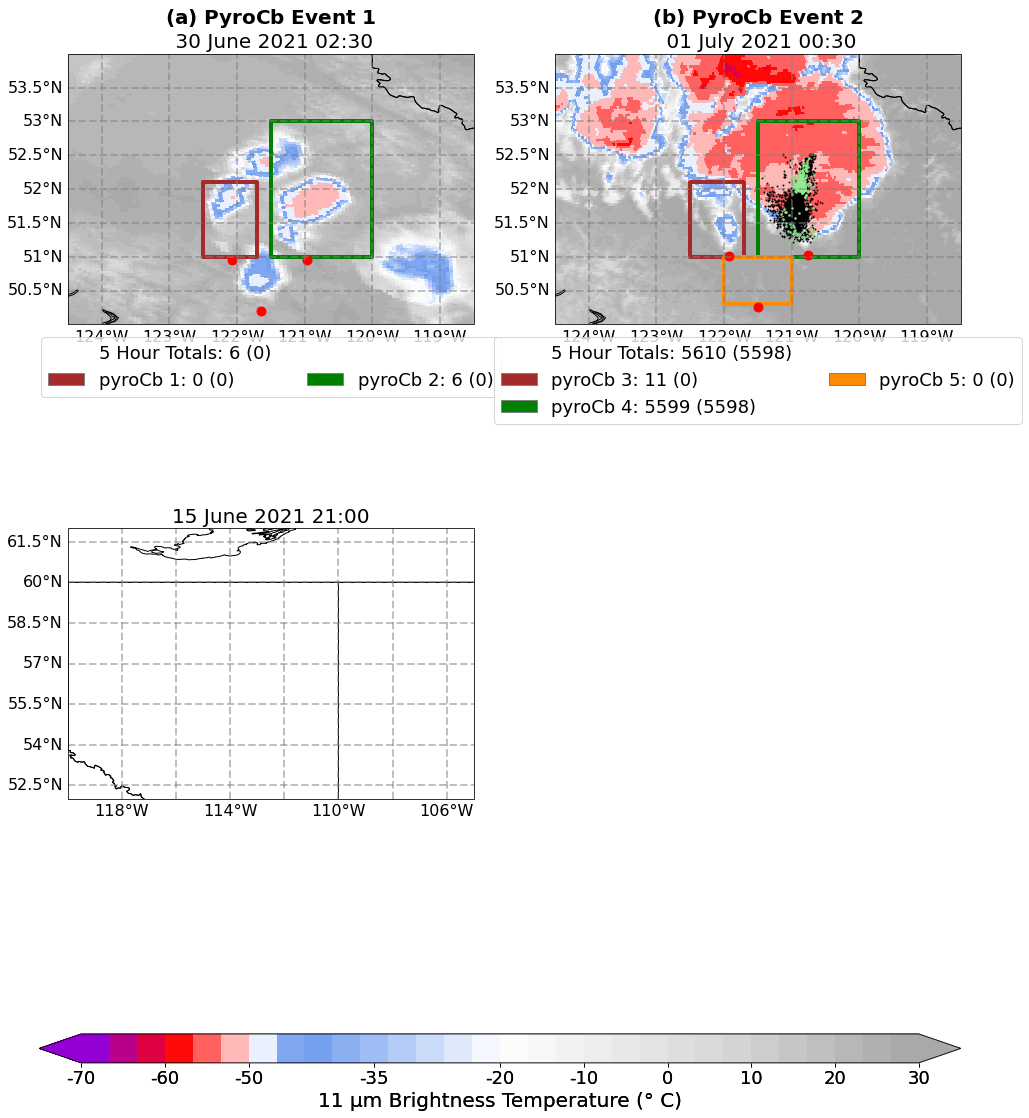

In [130]:
fig = plt.figure(figsize=(16, 16))

for i in range(1, 2, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_pyrocb_early/' + folder_names_pyrocbearly[i] + '/'
        FILE = path + file_names_pyrocbearly[i][j]
        data = xarray.open_dataset(FILE)
        
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()
        ax = fig.add_subplot(2, 2, 1, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123, -122, -121, -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} 
        
#         ax.tick_params(axis='x', colors='black', direction='out', length=13, width=0)
#         ax.tick_params(axis='y', colors='black', direction='out', length=13, width=0)


        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        
        
        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        
        lightning_count = len(data_june29.loc[(data_june29.lat >= 50) & (data_june29.lat <= 54) & (data_june29.lon >= -123) & (data_june29.lon <= -119.5)])
        patch1_count = len(data_june29.loc[(data_june29.lat >= 51) & (data_june29.lat <= 52.1) & (data_june29.lon >= -122.5) & (data_june29.lon <= -121.7)])
        patch2_count = len(data_june29.loc[(data_june29.lat >= 51) & (data_june29.lat <= 53) & (data_june29.lon >= -121.5) & (data_june29.lon <= -120.0)])
        
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {} (0)".format(str(lightning_count)))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        patch1 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("pyroCb 1: {} (0)".format(str(patch1_count))))
        patch2 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("pyroCb 2: {} (0)".format(str(patch2_count))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")

        ax.legend(handles=[titlepatch, patch1, blank, patch2], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.3),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)      
        
        fire_lat = [50.953, 50.202, 50.951]
        fire_lon = [-122.071, -121.649, -120.964]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'

        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5,  cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(a) \ PyroCb \ Event \ 1" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------

for i in range(21, 22, 1):

        path = '/data2/edworak/data/PyroCb/MCMIPF1/'
        FILE = path + file_names_pyrocb[i]

        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 2, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)
        ax.set_xlabel("Lightning Strike Totals", fontsize = 16)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        ax.set_axisbelow(True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123,  -122,  -121,  -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        
        points = lt_plx_pyrocb
        ax.scatter(x = points["lon"], y = points["lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = lt_plx_pyrocb.loc[(lt_plx_pyrocb.hour == 2)]
        ax.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)
        
        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        lytton_subregion_box(ax, points)
       
        patch3_count1 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch3_count2 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch3_count = patch3_count1 + patch3_count2
        patch4_count = len(data_pyrocb)
        patch4_bt_count = len(points)
        patch5_count1 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121)& (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch5_count2 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch5_count = patch5_count1 + patch5_count2
        
        lightning_count = patch4_count + patch3_count
        lightning_bt_count = len(points)
    
    
    
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {} ({})".format(str(lightning_count), str(lightning_bt_count)))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        patch3 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("pyroCb 3: {} (0)".format(str(patch3_count))))
        patch4 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("pyroCb 4: {} ({})".format(str(patch4_count), str(patch4_bt_count))))
        patch5 = mpatches.Patch(facecolor='darkorange', edgecolor = "grey", label=("pyroCb 5: {} (0)".format(str(patch5_count))))
        
        
        ax.legend(handles=[titlepatch, patch3, patch4, blank, patch5, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.4),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

        fire_lat = [51.012, 50.262, 51.026]
        fire_lon = [-121.932, -121.502, -120.754]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        
        ax.set_title(r"$\bf{" + "(b) \ PyroCb \ Event \ 2" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 20) #loc='right'

        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
        
# ------------------------------------------------------------------------------------------------------
    
for i in range(3, 4, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 3, projection=pc)
        ax.set_extent([-120, -105, 52, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([-118,  -116,  -114,  -112,  -110, -108, -106])
        gl.ylocator = mticker.FixedLocator([52.5, 54, 55.5, 57, 58.5, 60, 61.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

        points = lt_plx_clean5
        points_all = lightning_clean5

        ax.scatter(x = points["lon"], y = points["lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = lt_plx_clean5.loc[((lt_plx_clean5.hour == 20) & (lt_plx_clean5.minute >= 30)) | ((lt_plx_clean5.hour == 21) & (lt_plx_clean5.minute <= 30))]
        pointshour_all = lightning_clean5.loc[((lightning_clean5.hour == 20) & (lightning_clean5.minute >= 30)) | ((lightning_clean5.hour == 21) & (lightning_clean5.minute <= 30))]
        ax.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)
        
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {} ({})".format(str(len(points_all)), str(len(points))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        ax.legend(handles=[titlepatch, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)        
        
        fire_lat = [54.872]
        fire_lon = [-106.672]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'
    
       # tstorm_subregion_box(ax, im)
       # [left, bottom, width, height]
        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(c) \ Clean \ Thunderstorm" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------
    
for i in range(2, 3, 1):
    for j in range(0,1,1):
        path = '/data2/edworak/data/BT_smoke/' + folder_names_smoke[i] + '/'
        FILE = path + file_names_smoke[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 4, projection=pc)
        ax.set_extent([-125, -110, 54, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([ -124,  -122,  -120,  -118, -116, -114, -112])
        gl.ylocator = mticker.FixedLocator([54.5, 56, 57.5, 59, 60.5, 62, 63.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        points = lt_plx_smoke
        points_all = lightning_smoke

        ax.scatter(x = points["lon"], y = points["lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = lt_plx_smoke.loc[((lt_plx_smoke.hour == 9) & (lt_plx_smoke.minute >= 30)) | ((lt_plx_smoke.hour == 10) & (lt_plx_smoke.minute <= 30))]
        pointshour_all = lightning_smoke.loc[((lightning_smoke.hour == 9) & (lightning_smoke.minute >= 30)) | ((lightning_smoke.hour == 10) & (lightning_smoke.minute <= 30))]
        ax.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)

        nopoints = data_june29.loc[(data_june29.hour == 2) & (data_june29.hour == 3)]
        ax.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 80, color = "lightgreen", marker = "o", alpha = 0.8,  label = "Strikes Within 30 Minutes of Image Time")
        ax.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 80, color = "black", marker = "o", alpha = 0.8,  label = "All Strikes Analyzed")

        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {} ({})".format(str(len(points_all)), str(len(points))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour_all)), str(len(pointshour))))
        secondlegend =  ax.legend(handles=[titlepatch, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)
        ax.add_artist(secondlegend)
        
        fire_lat = [61.715,  60.709, 57.514, 59.481]
        fire_lon = [-123.694, -125.289, -123.021, -120.533]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), fontsize = 18, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol = 3)
        
       # [left, bottom, width, height]
        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(d) \ Smoke-Filled \ Thunderstorm" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------
plt.suptitle("Figure 1 : Four Thunderstorm Cases", x = 0.5, y = 0.95, fontweight='bold', fontsize=24)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.2)

plt.savefig("figure1_final".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## Figure 1 with VIIRS 

/tmp/ipykernel_186682/740868586.py:444: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


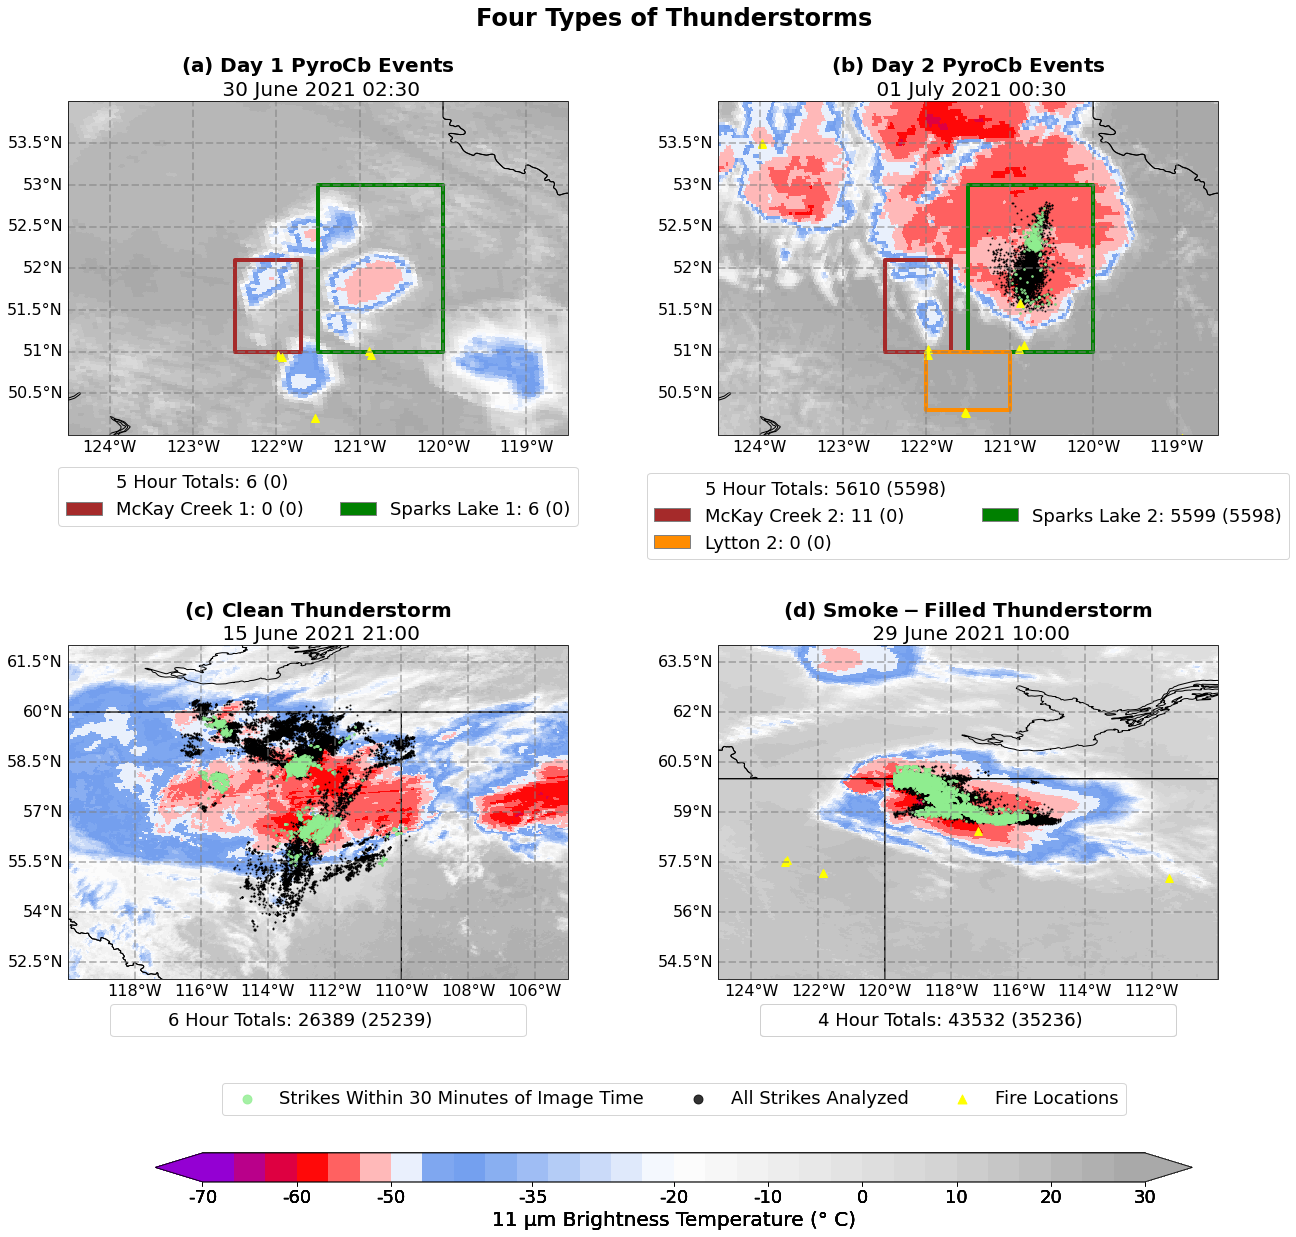

In [139]:
fig = plt.figure(figsize=(18, 16))#width height

for i in range(1, 2, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_pyrocb_early/' + folder_names_pyrocbearly[i] + '/'
        FILE = path + file_names_pyrocbearly[i][j]
        data = xarray.open_dataset(FILE)
        
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()
        ax = fig.add_subplot(2, 2, 1, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123, -122, -121, -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} 
        
#         ax.tick_params(axis='x', colors='black', direction='out', length=13, width=0)
#         ax.tick_params(axis='y', colors='black', direction='out', length=13, width=0)


        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        
        
        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        
        lightning_count = len(data_june29.loc[(data_june29.lat >= 50) & (data_june29.lat <= 54) & (data_june29.lon >= -123) & (data_june29.lon <= -119.5)])
        patch1_count = len(data_june29.loc[(data_june29.lat >= 51) & (data_june29.lat <= 52.1) & (data_june29.lon >= -122.5) & (data_june29.lon <= -121.7)])
        patch2_count = len(data_june29.loc[(data_june29.lat >= 51) & (data_june29.lat <= 53) & (data_june29.lon >= -121.5) & (data_june29.lon <= -120.0)])
        
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {} (0)".format(str(lightning_count)))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        patch1 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("McKay Creek 1: {} (0)".format(str(patch1_count))))
        patch2 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("Sparks Lake 1: {} (0)".format(str(patch2_count))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")

        ax.legend(handles=[titlepatch, patch1, blank, patch2], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.3),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)      
        
#         fire_lat = [50.953, 50.202, 50.951]
#         fire_lon = [-122.071, -121.649, -120.964]
#         ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        
        
        #######################
        # overlay viirs fires

        viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20210101_20211231.nc'
        # the code will pull the fire pixels from 24 hours before this time:

        plot_day = 181
        plot_hour = 2
        plot_minute = 30

        viirs_data = Dataset(viirs_path)
        viirs_lat = viirs_data['median_lat'][:]
        viirs_lon = viirs_data['median_lon'][:]
        viirs_time = viirs_data['time'][:]  
        viirs_frp = viirs_data['total_frp'][:]

        viirs_h = 6+viirs_time.data
        plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
        dt = viirs_h - plot_time
        fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

        plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=60,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Locations")
        
        #################

        
        cax = plt.axes([0.1, -0.07, 0.8, 0.025])
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5,  cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(a) \ Day \ 1 \ PyroCb \ Events" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------

for i in range(21, 22, 1):

        path = '/data2/edworak/data/PyroCb/MCMIPF1/'
        FILE = path + file_names_pyrocb[i]

        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 2, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)
        ax.set_xlabel("Lightning Strike Totals", fontsize = 16)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        ax.set_axisbelow(True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123,  -122,  -121,  -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        
        points = lt_plx_pyrocb
        ax.scatter(x = points["lon"], y = points["lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = lt_plx_pyrocb.loc[(lt_plx_pyrocb.hour == 2)]
        ax.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)
        
        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        lytton_subregion_box(ax, points)
       
        patch3_count1 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch3_count2 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch3_count = patch3_count1 + patch3_count2
        patch4_count = len(data_pyrocb)
        patch4_bt_count = len(points)
        patch5_count1 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121)& (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch5_count2 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch5_count = patch5_count1 + patch5_count2
        
        lightning_count = patch4_count + patch3_count
        lightning_bt_count = len(points)
    
    
    
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {} ({})".format(str(lightning_count), str(lightning_bt_count)))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        patch3 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("McKay Creek 2: {} (0)".format(str(patch3_count))))
        patch4 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("Sparks Lake 2: {} ({})".format(str(patch4_count), str(patch4_bt_count))))
        patch5 = mpatches.Patch(facecolor='darkorange', edgecolor = "grey", label=("Lytton 2: {} (0)".format(str(patch5_count))))
        
        
        ax.legend(handles=[titlepatch, patch3, patch5, blank, patch4, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.4),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

#         fire_lat = [51.012, 50.262, 51.026]
#         fire_lon = [-121.932, -121.502, -120.754]
#         ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        
        #######################
        # overlay viirs fires

        # the code will pull the fire pixels from 24 hours before this time:
        plot_day = 182
        plot_hour = 0
        plot_minute = 30

        viirs_data = Dataset(viirs_path)
        viirs_lat = viirs_data['median_lat'][:]
        viirs_lon = viirs_data['median_lon'][:]
        viirs_time = viirs_data['time'][:]  
        viirs_frp = viirs_data['total_frp'][:]

        viirs_h = 6+viirs_time.data
        plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
        dt = viirs_h - plot_time
        fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

        plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data,c='yellow',s=60,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Locations")
        
        #################
        
    
        
        ax.set_title(r"$\bf{" + "(b) \ Day \ 2 \ PyroCb \ Events" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 20) #loc='right'

        cax = plt.axes([0.1, -0.07, 0.8, 0.025])
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
        
# ------------------------------------------------------------------------------------------------------
    
for i in range(3, 4, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 3, projection=pc)
        ax.set_extent([-120, -105, 52, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([-118,  -116,  -114,  -112,  -110, -108, -106])
        gl.ylocator = mticker.FixedLocator([52.5, 54, 55.5, 57, 58.5, 60, 61.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

        points = lt_plx_clean5
        points_all = lightning_clean5

        ax.scatter(x = points["lon"], y = points["lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = lt_plx_clean5.loc[((lt_plx_clean5.hour == 20) & (lt_plx_clean5.minute >= 30)) | ((lt_plx_clean5.hour == 21) & (lt_plx_clean5.minute <= 30))]
        pointshour_all = lightning_clean5.loc[((lightning_clean5.hour == 20) & (lightning_clean5.minute >= 30)) | ((lightning_clean5.hour == 21) & (lightning_clean5.minute <= 30))]
        ax.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)
        
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {} ({})".format(str(len(points_all)), str(len(points))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        ax.legend(handles=[titlepatch, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)        
        
#         fire_lat = [54.872]
#         fire_lon = [-106.672]
#         ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='red',  marker = "o",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
    
    
        #######################
        # overlay viirs fires

        # the code will pull the fire pixels from 24 hours before this time:
        plot_day = 166
        plot_hour = 21
        plot_minute = 0

        viirs_data = Dataset(viirs_path)
        viirs_lat = viirs_data['median_lat'][:]
        viirs_lon = viirs_data['median_lon'][:]
        viirs_time = viirs_data['time'][:]  
        viirs_frp = viirs_data['total_frp'][:]

        viirs_h = 6+viirs_time.data
        plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
        dt = viirs_h - plot_time
        fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

        plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data,c='yellow',s=60,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Locations")
        
        #################
        
       # tstorm_subregion_box(ax, im)
       # [left, bottom, width, height]
        cax = plt.axes([0.1, -0.07, 0.8, 0.025])
        
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(c) \ Clean \ Thunderstorm" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------
    
for i in range(2, 3, 1):
    for j in range(0,1,1):
        path = '/data2/edworak/data/BT_smoke/' + folder_names_smoke[i] + '/'
        FILE = path + file_names_smoke[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 4, projection=pc)
        ax.set_extent([-125, -110, 54, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([ -124,  -122,  -120,  -118, -116, -114, -112])
        gl.ylocator = mticker.FixedLocator([54.5, 56, 57.5, 59, 60.5, 62, 63.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        points = lt_plx_smoke
        points_all = lightning_smoke

        ax.scatter(x = points["lon"], y = points["lat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = lt_plx_smoke.loc[((lt_plx_smoke.hour == 9) & (lt_plx_smoke.minute >= 30)) | ((lt_plx_smoke.hour == 10) & (lt_plx_smoke.minute <= 30))]
        pointshour_all = lightning_smoke.loc[((lightning_smoke.hour == 9) & (lightning_smoke.minute >= 30)) | ((lightning_smoke.hour == 10) & (lightning_smoke.minute <= 30))]
        ax.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)

        nopoints = data_june29.loc[(data_june29.hour == 2) & (data_june29.hour == 3)]
        ax.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 80, color = "lightgreen", marker = "o", alpha = 0.8,  label = "Strikes Within 30 Minutes of Image Time")
        ax.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 80, color = "black", marker = "o", alpha = 0.8,  label = "All Strikes Analyzed")

        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="4 Hour Totals: {} ({})".format(str(len(points_all)), str(len(points))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour_all)), str(len(pointshour))))
        secondlegend =  ax.legend(handles=[titlepatch, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)
        ax.add_artist(secondlegend)
        
        
        #######################
        # overlay viirs fires

        # the code will pull the fire pixels from 24 hours before this time:
        plot_day = 180
        plot_hour = 10
        plot_minute = 0

        viirs_data = Dataset(viirs_path)
        viirs_lat = viirs_data['median_lat'][:]
        viirs_lon = viirs_data['median_lon'][:]
        viirs_time = viirs_data['time'][:]  
        viirs_frp = viirs_data['total_frp'][:]

        viirs_h = 6+viirs_time.data
        plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
        dt = viirs_h - plot_time
        fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

        plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data,c='yellow',s=60,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Locations")
        
        #################
        
        
        fire_lat = [65]
        fire_lon = [-135]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='yellow',  marker = "^",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), fontsize = 18, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol = 3)
        
       # [left, bottom, width, height]
        cax = plt.axes([0.1, -0.07, 0.8, 0.025])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 20)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(d) \ Smoke-Filled \ Thunderstorm" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------
plt.suptitle("Four Types of Thunderstorms", x = 0.5, y = 0.95, fontweight='bold', fontsize=24)
plt.tight_layout()
plt.subplots_adjust(hspace= 0, wspace=0.3)
# wspace: the amount of width reserved for space between subplots
# hspace: the amount of height reserved for space between subplots

plt.savefig("figure1_final".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


# Merra :(

## load in merra

In [140]:
# create empty array to add into 
file_names_unsorted_merra = []

path = '/data2/edworak/data/merra2'
file = os.listdir(path)

for f in file: 
    #print(f)
    #print(len(f))
    file_names_unsorted_merra.append(f)
file_names_merra = sorted(file_names_unsorted_merra)

goes_data_merra = []

for i in range(len(file_names_merra[:-1])):
    path = '/data2/edworak/data/merra2/'
    FILE = path + file_names_merra[i]
    #print(FILE)
    #"goes_"+ filename[i][30:36] = xarray.open_dataset(FILE)
    goes_data_merra = xarray.open_dataset(FILE)    
    
aod_time = goes_data_merra["AODANA"][7,:,:].time.values
ts = pd.to_datetime(str(aod_time)).strftime('%m-%d-%Y %H UTC')

goes_data_merra

<xarray.Dataset>
Dimensions:  (lon: 576, lat: 361, time: 8)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 2021-09-30 ... 2021-09-30T21:00:00
Data variables:
    AODANA   (time, lat, lon) float32 ...
    AODINC   (time, lat, lon) float32 ...
Attributes: (12/30)
    Comment:                           GMAO filename: d5124_m2_jun21.inst3_2d...
    Filename:                          MERRA2_401.inst3_2d_gas_Nx.20210930.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    ...                                ...
    History:                           Re-processed file generated: Mon Dec  ...
    identifier_product_doi:            10.5067/HNGA0EWW0R09
    RangeBeginningDate:                2021-09-30
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2021-09-30
    RangeEndingTime:                   21:00:00.000000

min : <xarray.DataArray 'AODANA' ()>
array(2.50416597e-05)
max : <xarray.DataArray 'AODANA' ()>
array(3.21361542)
2021 06 15


<xarray.DataArray 'lon' (lon: 576)>
array([-180.   , -179.375, -178.75 , ...,  178.125,  178.75 ,  179.375])
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    long_name:    longitude
    units:        degrees_east
    vmax:         1000000000000000.0
    vmin:         -1000000000000000.0
    valid_range:  [-1.e+15  1.e+15]

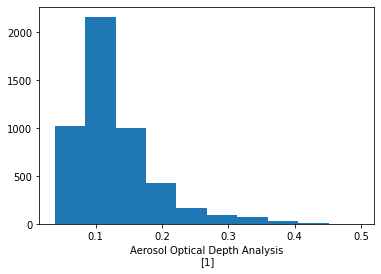

In [141]:
# AODANA : Aerosol Optical Depth Analysis
ds =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')
#ds['AODANA'][0,:,:].plot()
ds['AODANA'].sel(lat=slice(48,60),lon=slice(-125,-110)).plot()
#ds['T10M'].sel(lat=slice(0,50),lon=slice(55,115),time="1980-01-01T01:00:00").plot()

ds.time.begin_date
ds.AODANA.attrs
print("min : {}".format(ds["AODANA"][:].min()))
print("max : {}".format(ds["AODANA"][:].max()))

date = ds.AODANA.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]
print(year, month, day)
#goes_data_pyrocb.attrs["units"] = "celsius"
ds.AODANA.lon

## merra map

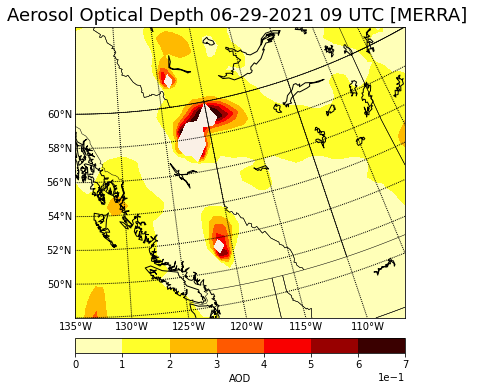

In [142]:
fig = plt.figure(figsize=(8, 6))
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210629.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
aodana = nc.variables['AODANA'][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)


aod_mask_1 = np.ma.masked_greater(aodana,0.7)
aod_mask_2 = np.ma.masked_less(aod_mask_1,0)

im = map.contourf(x,y,aod_mask_2[3,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='AOD', alpha = 0.8)
cbar.formatter.set_powerlimits((0, 0))

# im.set_clim(0, 1.0)
aod_time = nc["AODANA"][3,:,:].time.values
ts = pd.to_datetime(str(aod_time)).strftime('%m-%d-%Y %H UTC')


plt.title('Aerosol Optical Depth {} [MERRA] '.format(ts), fontsize = 18)
plt.savefig("MERRA AOD {}".format(ts), dpi = 200)


## june 15

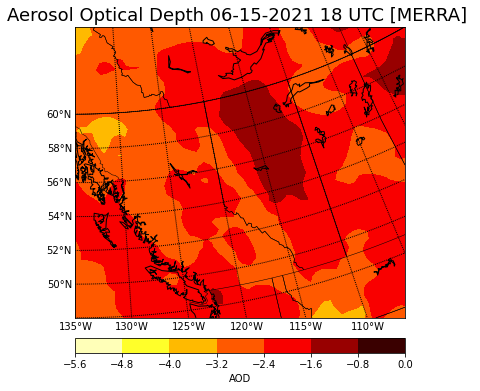

In [143]:
fig = plt.figure(figsize=(8, 6))
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
aodana = nc.variables['AODANA'][:]


# projection, lat/lon extents and resolution of polygons to draw
#map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-105.,urcrnrlat=60.,resolution='i') 

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

aod_mask_1 = np.ma.masked_greater(aodana,0.6)
aod_mask_2 = np.ma.masked_less(aod_mask_1,0)
im = map.contourf(x,y, np.log(aod_mask_2[6,:,:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='AOD', alpha = 0.8)
cbar.formatter.set_powerlimits((0, 0))

# im.set_clim(0, 0.6)
# cbar.set_label(tmax_units)

aod_time = nc["AODANA"][6,:,:].time.values
ts = pd.to_datetime(str(aod_time)).strftime('%m-%d-%Y %H UTC')


plt.title('Aerosol Optical Depth {} [MERRA] '.format(ts), fontsize = 18)
plt.savefig("MERRA AOD {}".format(ts), dpi = 200)


## AOD subplots

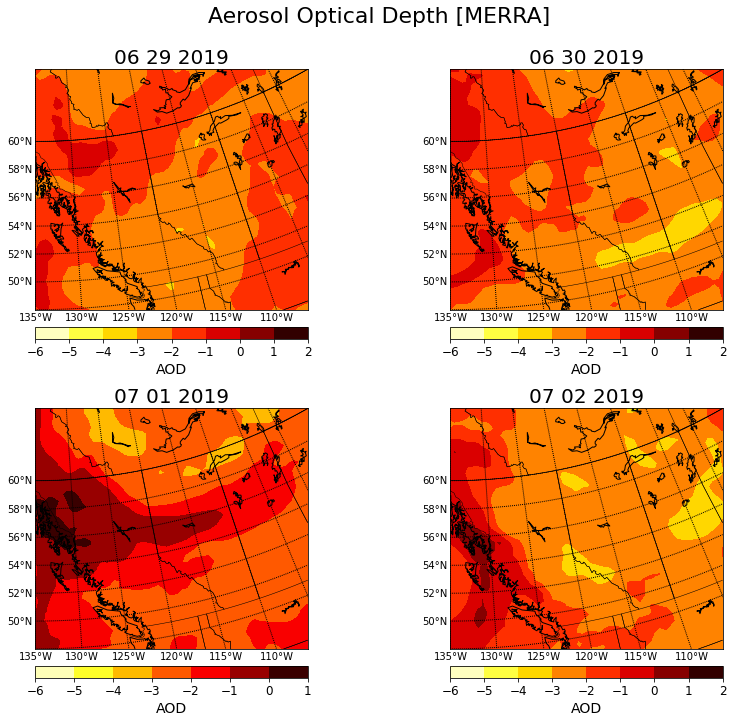

In [144]:
fig = plt.figure(figsize = (12,10))

subplots = [221, 222, 223, 224]
# maps june 29 - july 2 28, 32
for i in range(0, len(subplots)):
    
    ax = fig.add_subplot(subplots[i])
    path = '/data2/edworak/data/merra2/'
    FILE = path + file_names_merra[i + 28]
    nc = xarray.open_dataset(FILE)
    
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    time = nc.variables['time'][:]
    aodana = nc.variables["AODANA"][:]

    map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    map.drawcounties() # you can even add counties (and other shapefiles!)

    parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
    x,y = map(lons,lats)

    aod_mask_1 = np.ma.masked_greater(aodana,3.5)
    aod_mask_2 = np.ma.masked_less(aod_mask_1,0)

    im = map.contourf(x,y, np.log(aod_mask_2[4,:,:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
    cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', alpha = 0.8)
    cbar.formatter.set_powerlimits((0, 0))
    # im.set_clim(0, 2)
    
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
    cbar.set_label(label='AOD', fontsize = 14)
    #cbar.set_lim[-6, 2] 
    
    date = nc.AODANA.time.begin_date
    year = str(date)[:4]
    month = str(date)[4:6]
    day = str(date)[-2:]
    ax.set_title('{} {} {}'.format(month, day, year), fontsize = 20)

plt.suptitle('Aerosol Optical Depth [MERRA]'.format(month, day, year), fontsize = 22, y = 1.0)
plt.tight_layout()
plt.savefig("AOD subplots MERRA".format(date), dpi = 200, bbox_inches = "tight")


### plate carree projection

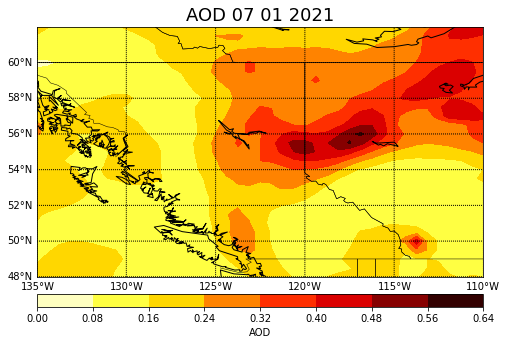

In [145]:
fig = plt.figure(figsize=(8, 8))
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210701.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
aodana = nc.variables['AODANA'][:]

# projection, lat/lon extents and resolution of polygons to draw
#map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-105.,urcrnrlat=60.,resolution='i') 

map = Basemap(projection="cyl",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-110.,urcrnrlat=62., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon-180,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

#aod = map.contourf(x,y,np.squeeze(aodana[4,:,:]))

#cs = map.contourf(x,y,aodana[4,:,:], cmap = 'hot_r')

aod_mask_1 = np.ma.masked_greater(aodana,1.0)
aod_mask_2 = np.ma.masked_less(aod_mask_1,0)

cs = map.contourf(x,y,aod_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(cs, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='AOD', alpha = 0.8)
# cbar.set_label(tmax_units)

date = nc.AODANA.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('AOD {} {} {}'.format(month, day, year), fontsize = 18)
plt.savefig("AOD {}".format(date), dpi = 200)


## compare datasets

In [146]:
# AODANA : Aerosol Optical Depth Analysis
ds =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')

time = ds.AODANA.time
time_array = time[1]
time_array
# scan_start = datetime.strptime(time_array, '%Y-%m-%dT%H:%M:%S.%fZ')


<xarray.DataArray 'time' ()>
array('2021-06-15T03:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-06-15T03:00:00
Attributes:
    long_name:       time
    time_increment:  30000
    begin_date:      20210615
    begin_time:      0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

In [147]:
tester_merra = pd.read_csv('/data2/edworak/data/tester_merra.nc', usecols = ["year", "month", "day", "lat", "lon", "AODANA"])
#tester_merra = df[["year", "month", "day","AODANA"]]
tester_merra

#tester_merra.lat

lat      lon  year  month  day    AODANA
0     45.0 -130.000  2021      6   15  0.128609
1     45.0 -129.375  2021      6   15  0.143267
2     45.0 -128.750  2021      6   15  0.130872
3     45.0 -128.125  2021      6   15  0.106506
4     45.0 -127.500  2021      6   15  0.087417
...    ...      ...   ...    ...  ...       ...
1514  60.0 -102.500  2021      6   15  0.215908
1515  60.0 -101.875  2021      6   15  0.234603
1516  60.0 -101.250  2021      6   15  0.242784
1517  60.0 -100.625  2021      6   15  0.224178
1518  60.0 -100.000  2021      6   15  0.187027

[1519 rows x 6 columns]

In [148]:
# if I can load in BT as one data frame, then can just do this process once to compare 
#ds_latlon = calc_latlon(xarray.open_dataset('/data2/edworak/data/BT_nosmoke_combined/ds_21.nc'))
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')

#select by lat/lon region
lat_min, lat_max = 45, 60
lon_min, lon_max = -130, -100

lat_condition = (nc.AODANA.lat >= lat_min) & (nc.AODANA.lat <= lat_max)
lon_condition = (nc.AODANA.lon >= lon_min) & (nc.AODANA.lon <= lon_max)

selected_region = nc.where((lat_condition) & (lon_condition), drop=True)

#select CMI_C14 channel anc convert into celsius
aodana = selected_region['AODANA'][4,:,:]
#print(aodana.lat[:]) 

# Convert the xarray dataarray to a pandas dataframe
df = aodana.to_dataframe()

date = aodana.time.begin_date

df['year'] = str(date)[:4]
df['month'] = str(date)[4:6]
df['day'] = str(date)[-2:]

# df["lat"] = pd.Series(aodana.lat[:])
# df["lon"] = pd.Series(aodana.lon[:])

data = df.loc[:, ("year","month", "day", "AODANA")]

# data = {'year': df["year"], 'month': df["month"], 'day': df['day'], 
#         'lat' : df["lats"], "lon" : df["lons"], "aod" : aodana}

data.reset_index
data.dropna(inplace = True)

data
data.to_csv('/data2/edworak/data/tester_merra.nc')


In [149]:
#members = lightning 
lt_nosmoke = pd.read_csv("/data2/edworak/data/lightning_df_nosmoke.csv", sep='\t')
lt_nosmoke = lt_nosmoke.drop_duplicates(subset=["l_lat", "l_lon"], keep='first')
lt_nosmoke.reindex()
lt_nosmoke
#lt_nosmoke.l_lat

Unnamed: 0  year  month  day  hour  minute     second    l_lat  \
0              48  2021      6   15    18       5   1.924783  53.5947   
1             126  2021      6   15    18       5   2.096512  53.6018   
3             176  2021      6   15    18       5   2.429782  53.6571   
4             252  2021      6   15    18       5   2.486228  53.6266   
6             327  2021      6   15    18       5   5.382116  53.9393   
...           ...   ...    ...  ...   ...     ...        ...      ...   
20853       14838  2021      6   15    23      59  48.000000  59.2990   
20854       14887  2021      6   15    23      59  49.000000  59.3110   
20855       14927  2021      6   15    23      59  54.000000  59.3270   
20857       14945  2021      6   15    23      59  55.000000  53.6360   
20858       14946  2021      6   15    23      59  56.000000  59.9540   

          l_lon  peak-current C or G    CMI_C14     bt_lat      bt_lon  \
0     -114.0116         125.2      G -55.103867  53.612045 -114.015620   
1     -113.9254         -10.0      G -58.036560  53.617190 -113.939210   
3     -114.0325         -39.8      G -54.146255  53.651413 -114.026870   
4     -114.2350         -22.1      G -56.360733  53.683445 -114.152504   
6     -113.5184         -13.6      G -56.659990  53.924763 -113.517880   
...         ...           ...    ...        ...        ...         ...   
20853 -115.3530         -15.8      G -57.019090  59.314545 -115.367620   
20854 -115.2900           7.0      C -58.694916  59.320705 -115.278336   
20855 -115.1040           6.1      C -60.251038  59.332714 -115.099770   
20857 -115.8750          11.8      C -36.071335  53.622547 -115.854290   
20858 -115.5400         -17.3      G -56.181183  59.967537 -115.527650   

       distance(km)  
0             1.947  
1             1.939  
3             0.733  
4             8.337  
6             1.617  
...             ...  
20853         1.917  
20854         1.266  
20855         0.679  
20857         2.025  
20858         1.655  

[13167 rows x 15 columns]

In [150]:
tester_merra = pd.read_csv('/data2/edworak/data/tester_merra.nc', usecols = ["year", "month", "day", "lat", "lon", "AODANA"])
tester_merra

lat      lon  year  month  day    AODANA
0     45.0 -130.000  2021      6   15  0.128609
1     45.0 -129.375  2021      6   15  0.143267
2     45.0 -128.750  2021      6   15  0.130872
3     45.0 -128.125  2021      6   15  0.106506
4     45.0 -127.500  2021      6   15  0.087417
...    ...      ...   ...    ...  ...       ...
1514  60.0 -102.500  2021      6   15  0.215908
1515  60.0 -101.875  2021      6   15  0.234603
1516  60.0 -101.250  2021      6   15  0.242784
1517  60.0 -100.625  2021      6   15  0.224178
1518  60.0 -100.000  2021      6   15  0.187027

[1519 rows x 6 columns]

In [151]:
# To make sure that there are no null values and All are either integers/ Float values 
lt_nosmoke.info() 
print('\n XXXXXXXXXXXXXXXXXXXXXXX\n')
tester_merra.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 13167 entries, 0 to 20858
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    13167 non-null  int64  
 1   year          13167 non-null  int64  
 2   month         13167 non-null  int64  
 3   day           13167 non-null  int64  
 4   hour          13167 non-null  int64  
 5   minute        13167 non-null  int64  
 6   second        13167 non-null  float64
 7   l_lat         13167 non-null  float64
 8   l_lon         13167 non-null  float64
 9   peak-current  13167 non-null  float64
 10  C or G        13167 non-null  object 
 11  CMI_C14       13167 non-null  float64
 12  bt_lat        13167 non-null  float64
 13  bt_lon        13167 non-null  float64
 14  distance(km)  13167 non-null  float64
dtypes: float64(8), int64(6), object(1)
memory usage: 1.6+ MB

 XXXXXXXXXXXXXXXXXXXXXXX

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 15

In [152]:
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [153]:
# find closest brightness temp point 
def find_nearest_merra(lat, long):

    distances = tester_merra.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return tester_merra.loc[distances.idxmin(), "AODANA"]
# get the bt from the bt_df

#then apply it to lightning 

This code will apply the find_nearest_merra() function to each row of the DataFrame using the apply() function. The lambda function passed to apply() takes each row as an input and returns the result of calling find_nearest_merra() with the latitude and longitude values from that row. The axis=1 argument tells apply() to apply the function to each row of the DataFrame. The results will be stored in a new column called 'AODANA' in lt_nosmoke.

In this context, a scalar is one of the things you put in an array. 
A single 64-bit float or 32-bit int, for example, rather than a whole array of them.

In [154]:
lt_nosmoke['AODANA'] = lt_nosmoke.apply(
    lambda row: find_nearest_merra(row['l_lat'], row['l_lon']), 
    axis=1)
# To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
lt_nosmoke.head()

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
print(lt_nosmoke['l_lat'].dtype)
print(lt_nosmoke['l_lon'].dtype)

In [ ]:
lt_nosmoke['l_lat'].values

In [ ]:
# lt_nosmoke['AODANA'] = lt_nosmoke.apply(
#     lambda row: find_nearest_merra(row['l_lat'], row['l_lon']), axis = 0)
# lt_nosmoke.head()

lt_nosmoke['AODANA'] = lt_nosmoke[["l_lat", "l_lon"]].apply(
    find_nearest_merra(lt_nosmoke['l_lat'], lt_nosmoke['l_lon']))
lt_nosmoke.head()

# test_df[[“float_col1”, “float_col2”]].apply(trig_transform)


In [ ]:
# find distance between lightning location to closest brightness temperature 

data_pyrocb_select = pd.merge(data_pyrocb_select, br_temp_select_pyrocb[["CMI_C14",'lat','lon']],on="CMI_C14", how='left')
# Rename the new columns as both the columns has same name, and python gets confused 
data_pyrocb_select = data_pyrocb_select.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon','lat_y':'bt_lat','lon_y':'bt_lon'})
data_pyrocb_select.head()


In [ ]:
data_pyrocb_select['distance(km)'] = [haversine(data_pyrocb_select.l_lon[i],data_pyrocb_select.l_lat[i],
                                             data_pyrocb_select.bt_lon[i],data_pyrocb_select.bt_lat[i]) 
                                   for i in range(len(data_pyrocb_select))]
data_pyrocb_select['distance(km)'] = data_pyrocb_select['distance(km)'].round(decimals=3)
# Printing the data table 
data_pyrocb_close = data_pyrocb_select.loc[data_pyrocb_select["distance(km)"] < 10]
data_pyrocb_select

## Black Carbon

In [ ]:
# create empty array to add into 
file_names_unsorted_bc = []

path = '/data2/edworak/data/black_carbon'
file = os.listdir(path)

for f in file: 
    #print(f)
    #print(len(f))
    file_names_unsorted_bc.append(f)
file_names_bc = sorted(file_names_unsorted_bc)

goes_data_bc = []

for i in range(len(file_names_bc[:-1])):
    path = '/data2/edworak/data/black_carbon/'
    FILE = path + file_names_bc[i]
    #print(FILE)
    #"goes_"+ filename[i][30:36] = xarray.open_dataset(FILE)
    goes_data_bc = xarray.open_dataset(FILE)
goes_data_bc["BCCMASS"][:]

In [ ]:
# AODANA : Aerosol Optical Depth Analysis
ds =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210702.nc4')

ds['BCCMASS'].sel(lat=slice(48,60),lon=slice(-125,-110)).plot()

ds.time.begin_date
ds.BCCMASS.attrs
print("min : {}".format(ds["BCCMASS"][:].min()))
print("max : {}".format(ds["BCCMASS"][:].max()))

date = ds.BCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]
print(year, month, day)
ds.BCCMASS[:]


### black carbon map

In [ ]:
fig = plt.figure(figsize=(8, 6))
nc =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210629.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
bccmass = nc.variables["BCCMASS"][:]

# projection, lat/lon extents and resolution of polygons to draw
#map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-105.,urcrnrlat=60.,resolution='i') 

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

bc_mask_1 = np.ma.masked_greater(bccmass,0.00002)
bc_mask_2 = np.ma.masked_less(bc_mask_1,0)

im = map.contourf(x,y, bc_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)', alpha = 0.8)
cbar.formatter.set_powerlimits((0, 0))

date = nc.BCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('Black Carbon Mass Density {} {} {} [MERRA]'.format(month, day, year), fontsize = 18)
plt.savefig("BCC {} MERRA".format(date), dpi = 200)


### june 15 

In [ ]:
fig = plt.figure(figsize=(8, 6))
nc =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210615.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
bccmass = nc.variables["BCCMASS"][:]

# projection, lat/lon extents and resolution of polygons to draw
#map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-105.,urcrnrlat=60.,resolution='i') 

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

bc_mask_1 = np.ma.masked_greater(bccmass,0.00001)
bc_mask_2 = np.ma.masked_less(bc_mask_1,0)

im = map.contourf(x,y, bc_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)', alpha = 0.8)
cbar.formatter.set_powerlimits((0, 0))

date = nc.BCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('Black Carbon Mass Density {} {} {} [MERRA]'.format(month, day, year), fontsize = 18)
plt.savefig("BCC {} MERRA".format(date), dpi = 200)


In [ ]:
fig = plt.figure(figsize = (12,10))

subplots = [221, 222, 223, 224]
# maps june 29 - july 2 28, 32
for i in range(0, len(subplots)):
    
    ax = fig.add_subplot(subplots[i])

    path = '/data2/edworak/data/black_carbon/'
    FILE = path + file_names_bc[i + 28]
    nc = xarray.open_dataset(FILE)
    
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    time = nc.variables['time'][:]
    bccmass = nc.variables["BCCMASS"][:]

    map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    map.drawcounties() # you can even add counties (and other shapefiles!)

    parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
    x,y = map(lons,lats)

    bc_mask_1 = np.ma.masked_greater(bccmass,0.00003)
    bc_mask_2 = np.ma.masked_less(bc_mask_1,0)

    im = map.contourf(x,y, bc_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
    cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', alpha = 0.8)
    im.set_clim(0, 0.00003)
    
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
    cbar.set_label(label='Column Mass Density(kg m^-2)', fontsize = 14)
    cbar.formatter.set_powerlimits((0, 0))

    date = nc.BCCMASS.time.begin_date
    year = str(date)[:4]
    month = str(date)[4:6]
    day = str(date)[-2:]
    ax.set_title('{} {} {}'.format(month, day, year), fontsize = 20)

plt.suptitle('Black Carbon Column Mass Density [MERRA]'.format(month, day, year), fontsize = 22, y = 1.0)
plt.tight_layout()
plt.savefig("BCC subplots {} MERRA".format(date), dpi = 200, bbox_inches = "tight")


### turn black carbon into dataframe

In [ ]:
# if I can load in BT as one data frame, then can just do this process once to compare 

# '/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210630.nc4'

#for i in range(0, 2):
for i in range(len(file_names_bc[:-1])):

    path = '/data2/edworak/data/black_carbon/'
    FILE = path + file_names_bc[i]
    bc_netcdf = xarray.open_dataset(FILE)
    
    lat = bc_netcdf.variables['lat'][:]
    lon = bc_netcdf.variables['lon'][:]
    time = bc_netcdf.variables['time'][:]
    bccmass = bc_netcdf.variables["BCCMASS"][:]
    
    #print(lat.values)
    # print(bc_netcdf.lat.values)
    
    #select by lat/lon region
    lat_min, lat_max = 53, 60
    lon_min, lon_max = -117, -110
    lat_condition = (bc_netcdf.lat >= lat_min) & (bc_netcdf.lat <= lat_max)
    lon_condition = (bc_netcdf.lon >= lon_min) & (bc_netcdf.lon <= lon_max)
    selected_region = bc_netcdf.where(lat_condition & lon_condition, drop=True)
#    print(selected_region.lat)
    # selected_region = bc_netcdf.where((lon_condition[:, None]), drop=True)

    # Convert the xarray dataarray to a pandas dataframe
    df = selected_region.to_dataframe()
    
    date = bc_netcdf.BCCMASS.time.begin_date
    time = ds.BCCMASS.time.values
# '2021-07-02T00:30:00.000000000'


    df["year"] = str(date)[:4]
    df["month"] = str(date)[4:6]
    df["day"] = str(date)[-2:]
    
    for j in range(len(ds.BCCMASS.time.values)):
        scan_start = datetime.strptime(ds.BCCMASS.time.values[j], '%Y-%m-%dT%H:%M:%S.%fZ')
        
    
    
    

#     df["lat"] = selected_region.lat
#     df["lon"] = selected_region.lon

#    bc_hourly_df = df.loc[:, ("year", "month","day", "lat", "lon", "BCCMASS")]
    bc_hourly_df = df.loc[:, ("year", "month","day", "BCCMASS")]

    bc_hourly_df.dropna(inplace = True)

    if i == 0: 
        bc_df = bc_hourly_df
    if i > 0: 
        bc_df = pd.concat([bc_df, bc_hourly_df], axis =0)
    
    # this is only showing the time of the last iteration 
    # have to either append it or combine all datasets for each hour after the fact 
    # it is only saving the last one 

In [ ]:
bc_df.to_csv("/data2/edworak/data/black_carbon_df.csv", sep='\t', encoding='utf-8')
bc_df
# string = "2021-06-01 00:30:00"
# string[:10]
# string[11:]
bc_df
a = (bcarbon_df["time"][:4])
print(a)
b = str(bcarbon_df["time"][0][5:7])
print(b)
c = str(bcarbon_df["time"][0][8:10])
print(c)

d = "2021-06-01 00:30:00"
scan_start = datetime.strptime(bcarbon_df["time"][0], '%Y-%m-%d %H:%M:%S')
scan_start

In [ ]:
bc_df

In [ ]:
bcarbon_df = pd.read_csv("/data2/edworak/data/black_carbon_df.csv", sep='\t')

bcarbon_df[["year", "month", "day"]] = bcarbon_df["time"][:10].str.split("-", expand = True)
bcarbon_df[["hour", "minute", "second"]] = bcarbon_df["time"][11:].str.split(":", expand = True)


# bcarbon_df['year'] = bcarbon_df['year'].astype('int')
# bcarbon_df['month'] = bcarbon_df['month'].astype('int')
# bcarbon_df['day'] = bcarbon_df['day'].astype('int')
# bcarbon_df['hour'] = bcarbon_df['hour'].astype('int')
# bcarbon_df['minute'] = bcarbon_df['minute'].astype('int')
#data_split2 = bcarbon_df[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "BCCMASS"]]
data_split2 = bcarbon_df[["year", "month", "day", "lat", "lon", "BCCMASS"]]

data_split2



# data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
# data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])

# data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
# data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
# data2['year'] = data2['year'].astype('int')
# data2['month'] = data2['month'].astype('int')
# data2['day'] = data2['day'].astype('int')
# data2['hour'] = data2['hour'].astype('int')
# data2['minute'] = data2['minute'].astype('int')
# data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

data_split2



In [ ]:
# if I can load in BT as one data frame, then can just do this process once to compare 
datasets = ["ds_18", "ds_19", "ds_20", "ds_21", "ds_22", "ds_23"]
path = '/data2/edworak/data/BT_nosmoke_combined/'

for i in range(len(datasets)): 
    ds_latlon = calc_latlon(xarray.open_dataset(path + datasets[i] + '.nc'))
    
    
    #select by lat/lon region
    lat_min, lat_max = 53, 60
    lon_min, lon_max = -117, -110
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

    #select CMI_C14 channel anc convert into celsius
    goes_data = selected_region['CMI_C14'][:] - 273.15
    goes_data.attrs["units"] = "celsius"
    
    # Convert the xarray dataarray to a pandas dataframe
    df = goes_data.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second
    
    bt_hourly_df = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
    
#     bt_hourly_df = pd.DataFrame({"year" : df['Date'].dt.year, "month": df['Date'].dt.month,
#                                  "day": df['Date'].dt.day, "hour": df['Date'].dt.hour,
#                                  "minute":df['Date'].dt.minute, "second": df['Date'].dt.second,
#                                  "CMI_C14": CMI_C14})

    bt_hourly_df.dropna(inplace = True)
    #data.set_index(df['Year'])

    # Add the dataframe to the existing pandas dataframe
    #existing_df = pd.read_csv('existing_data.csv')
    #result = pd.concat([data_nosmoke, df], axis=1)
    if i == 0: 
        bt_df = bt_hourly_df
    if i > 0: 
        bt_df = pd.concat([bt_df, bt_hourly_df], axis =0)
    
    # this is only showing the time of the last iteration 
    # have to either append it or combine all datasets for each hour after the fact 
    # it is only saving the last one 

## Organic Carbon

### file names

In [ ]:
# create empty array to add into 
file_names_unsorted_oc = []

path = '/data2/edworak/data/black_carbon'
file = os.listdir(path)

for f in file: 
    #print(f)
    #print(len(f))
    file_names_unsorted_oc.append(f)
file_names_oc = sorted(file_names_unsorted_oc)

goes_data_oc = []

for i in range(len(file_names_oc[:-1])):
    path = '/data2/edworak/data/black_carbon/'
    FILE = path + file_names_oc[i]
    goes_data_oc = xarray.open_dataset(FILE)
goes_data_oc["OCCMASS"][:]

In [ ]:
# AODANA : Aerosol Optical Depth Analysis
ds =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210702.nc4')

ds['OCCMASS'].sel(lat=slice(48,60),lon=slice(-125,-110)).plot()

ds.time.begin_date
ds.OCCMASS.attrs
print("min : {}".format(ds["OCCMASS"][:].min()))
print("max : {}".format(ds["OCCMASS"][:].max()))

date = ds.OCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]
print(year, month, day)
ds.OCCMASS[:]


### organic carbon map

In [ ]:
fig = plt.figure(figsize=(8, 6))
nc =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210701.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
occmass = nc.variables["OCCMASS"][:]

# projection, lat/lon extents and resolution of polygons to draw
#map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-105.,urcrnrlat=60.,resolution='i') 

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

oc_mask_1 = np.ma.masked_greater(occmass,0.0004)
oc_mask_2 = np.ma.masked_less(oc_mask_1,0)

im = map.contourf(x,y, oc_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)', alpha = 0.8)
cbar.formatter.set_powerlimits((0, 0))

date = nc.OCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('Organic Carbon Mass Density {} {} {} MERRA'.format(month, day, year), fontsize = 18)
plt.savefig("OCC {} MERRA".format(date), dpi = 200)


### june 15

In [ ]:
fig = plt.figure(figsize=(8, 6))
nc =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210615.nc4')

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
occmass = nc.variables["OCCMASS"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

oc_mask_1 = np.ma.masked_greater(occmass,0.00015)
oc_mask_2 = np.ma.masked_less(oc_mask_1,0)

# formatter = LogFormatter(10, labelOnlyBase=False) 
#formatter = ticker.ScalarFormatter(useMathText=True)
# formatter = ticker.LogFormatterExponent()

formatter = ticker.LogFormatterMathtext(base=10, labelOnlyBase=True)
#formatter = ticker.LogFormatterExponent()

#formatter.set_scientific(True) 
#formatter.set_powerlimits((-1,1)) 
im = map.contourf(x,y, oc_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)', alpha = 0.8, ticks = [0, 0.00004, 0.00008, 0.00012, 0.00016])
#cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_yticklabels(['0', '4e-5', '8e-5', '12e-5', '16e-5']) 

#cbar.ax.ticker.set_LogFormatterMathtext(base=10.0, labelOnlyBase=False, minor_thresholds=None, linthresh=None)

date = nc.OCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('Organic Carbon Mass Density {} {} {} MERRA'.format(month, day, year), fontsize = 18)
plt.savefig("OCC {} MERRA".format(date), dpi = 200)


In [ ]:
fig = plt.figure(figsize = (12,10))

subplots = [221, 222, 223, 224]
# maps june 29 - july 2 28, 32
for i in range(0, len(subplots)):
    
    ax = fig.add_subplot(subplots[i])

    path = '/data2/edworak/data/black_carbon/'
    FILE = path + file_names_oc[i + 28]
    nc = xarray.open_dataset(FILE)
    
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    time = nc.variables['time'][:]
    occmass = nc.variables["OCCMASS"][:]

    map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    map.drawcounties() # you can even add counties (and other shapefiles!)

    parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    # lon - 180
    lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
    x,y = map(lons,lats)

    oc_mask_1 = np.ma.masked_greater(occmass,0.00045)
    oc_mask_2 = np.ma.masked_less(oc_mask_1,0)

    im = map.contourf(x,y, oc_mask_2[4,:,:], cmap = 'hot_r') # , vmin = 0, vmax = 2
    cbar = map.colorbar(im, "bottom",  size="5%", pad="7%", cmap = 'hot_r', alpha = 0.8) 
    cbar.formatter.set_powerlimits((0, 0))
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
    cbar.set_label(label='Column Mass Density(kg m^-2)', fontsize = 14, y = -0.3)
    im.set_clim(0, 0.00045)
    # cbar.ax.set_xticklabels([ '0.000', '0.0001', '0.0002', '0.0003', '0.0004', '0.0005']) 

    date = nc.OCCMASS.time.begin_date
    year = str(date)[:4]
    month = str(date)[4:6]
    day = str(date)[-2:]
    ax.set_title('{} {} {}'.format(month, day, year), fontsize = 20)

plt.suptitle('Organic Carbon Column Mass Density MERRA'.format(month, day, year), fontsize = 22, y = 1.0)
plt.tight_layout()
plt.savefig("OCC subplots {} MERRA".format(date), dpi = 200, bbox_inches = "tight")


# CAMS Data

## load in 

In [ ]:
ds_cams = xarray.open_dataset("/data2/edworak/data/cams/adaptor.mars.internal-1681684655.353969-29265-10-0e988a18-53f9-4257-ad50-d0181a140bb8.nc")


lon = ds_cams.variables['longitude'][:]
lat = ds_cams.variables['latitude']
time = ds_cams.variables['time'][:]

lon, lat = np.meshgrid(lon, lat)
time.values.dtype

ds_cams.bcaod550.sel(latitude=slice(48,60),longitude=slice(-125,-110)).plot()
ds_cams.bcaod550.attrs

date = ds_cams.bcaod550.time

# each timestamp is 3 hours 
print("min : {}".format(ds_cams["bcaod550"][:].min()))
print("max : {}".format(ds_cams["bcaod550"][:].max()))

# [220,:224,:]
ds_cams['bcaod550']
ds_cams.variables["bcaod550"]
ds_cams.variables['time']


In [ ]:
# trying to work with time 
date = '2021-06-28'
dsloc = ds_cams.sel(time= date,method='nearest')
bcaod = dsloc["bcaod550"][:]
#dsloc.latitude.values
bcaod

## Black Carbon Aerosol Optical Depth at 550nm [CAMS]

In [ ]:
fig = plt.figure(figsize=(8, 6))
# nc = dsloc[220,:,:]

date = '2021-06-29'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
bcaod = dsloc["bcaod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

# mask_1 = np.ma.masked_greater(bcaod,0.01)
# mask_2 = np.ma.masked_less(mask_1,0)

im = map.contourf(x, y, bcaod[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')


plt.title('Black Carbon AOD {} [CAMS]'.format(date), fontsize = 18)
# plt.savefig("BCAOD {}".format(date), dpi = 200)




### june 15 

In [ ]:
fig = plt.figure(figsize=(8, 6))
# nc = dsloc[220,:,:]

date = '2021-06-15'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
bcaod = dsloc["bcaod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

# mask_1 = np.ma.masked_greater(bcaod,0.01)
# mask_2 = np.ma.masked_less(mask_1,0)

im = map.contourf(x, y, bcaod[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')


plt.title('Black Carbon AOD {} [CAMS]'.format(date), fontsize = 18)
plt.savefig("BCAOD {} [CAMS]".format(date), dpi = 200)




In [ ]:
fig = plt.figure(figsize = (12,10))

subplots = [221, 222, 223, 224]
dates = ['2021-06-29', '2021-06-30', '2021-07-01', '2021-06-02']
# maps june 29 - july 2 28, 32


for i in range(0, len(subplots)):
    
    ax = fig.add_subplot(subplots[i])

    date = dates[i]
    dsloc = ds_cams.sel(time = date, method='nearest')

    lat = dsloc["latitude"][:]
    lon = dsloc["longitude"][:]
    bcaod = dsloc["bcaod550"][:]

    map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    map.drawcounties() # you can even add counties (and other shapefiles!)

    parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
    x,y = map(lons,lats)

    mask_1 = np.ma.masked_greater(bcaod,0.5)
    mask_2 = np.ma.masked_less(mask_1,0)

    im = map.contourf(x, y, mask_2[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
    cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')
    # im.set_clim(0, 0.5)

    cbar.formatter.set_powerlimits((0, 0))
    
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
    cbar.set_label(label='Column Mass Density(kg m^-2)', fontsize = 14, y = -0.3)
    
    plt.title('{}'.format(date), fontsize = 18)


plt.suptitle('Black Carbon Aerosol Optical Depth at 550nm [CAMS]', fontsize = 22, y = 1.0)
plt.tight_layout()
plt.savefig("BC AOD subplots {} CAMS".format(date), dpi = 200, bbox_inches = "tight")


## Organic Matter Aerosol Optical Depth at 550nm [CAMS]

In [ ]:
fig = plt.figure(figsize=(8, 6))
# nc = dsloc[220,:,:]

date = '2021-06-15'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
ocaod = dsloc["omaod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

# mask_1 = np.ma.masked_greater(bcaod,0.01)
# mask_2 = np.ma.masked_less(mask_1,0)

im = map.contourf(x, y, ocaod[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')


plt.title('Organic Matter AOD {} [CAMS]'.format(date), fontsize = 18)
plt.savefig("OM AOD {} [CAMS]".format(date), dpi = 200)




In [ ]:
fig = plt.figure(figsize = (12,10))

subplots = [221, 222, 223, 224]
dates = ['2021-06-29', '2021-06-30', '2021-07-01', '2021-06-02']
# maps june 29 - july 2 28, 32


for i in range(0, len(subplots)):
    
    ax = fig.add_subplot(subplots[i])

    date = dates[i]
    dsloc = ds_cams.sel(time = date, method='nearest')

    lat = dsloc["latitude"][:]
    lon = dsloc["longitude"][:]
    ocaod = dsloc["omaod550"][:]

    map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    map.drawcounties() # you can even add counties (and other shapefiles!)

    parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
    x,y = map(lons,lats)

    mask_1 = np.ma.masked_greater(ocaod,2)
    mask_2 = np.ma.masked_less(mask_1,0)

    im = map.contourf(x, y, ocaod[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
    cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')
    # im.set_clim(0, 2)

    cbar.formatter.set_powerlimits((0, 0))
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
    cbar.set_label(label='Column Mass Density(kg m^-2)', fontsize = 14, y = -0.3)
    
    plt.title('{}'.format(date), fontsize = 18)


plt.suptitle('Organic Matter Aerosol Optical Depth at 550nm [CAMS]', fontsize = 22, y = 1.0)
plt.tight_layout()
plt.savefig("OM AOD subplots {} CAMS".format(date), dpi = 200, bbox_inches = "tight")


## Total Aerosol Optical Depth at 550nm

In [ ]:
fig = plt.figure(figsize=(8, 6))
# nc = dsloc[220,:,:]

date = '2021-06-15'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
aod = dsloc["aod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

mask_1 = np.ma.masked_greater(aod,0.5)
mask_2 = np.ma.masked_less(mask_1,0)

im = map.contourf(x, y, mask_2[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')


plt.title('Total Aerosol Optical Depth {} [CAMS]'.format(date), fontsize = 18)
plt.savefig("AOD {} [CAMS]".format(date), dpi = 200)




In [ ]:
# Total Aerosol Optical Depth at 550nm
fig = plt.figure(figsize = (12,10))

subplots = [221, 222, 223, 224]
dates = ['2021-06-29', '2021-06-30', '2021-07-01', '2021-06-02']
# maps june 29 - july 2 28, 32


for i in range(0, len(subplots)):
    
    ax = fig.add_subplot(subplots[i])

    date = dates[i]
    dsloc = ds_cams.sel(time = date, method='nearest')

    lat = dsloc["latitude"][:]
    lon = dsloc["longitude"][:]
    aod = dsloc["aod550"][:]

    map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    map.drawcounties() # you can even add counties (and other shapefiles!)

    parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
    x,y = map(lons,lats)

    mask_1 = np.ma.masked_greater(ocaod,2)
    mask_2 = np.ma.masked_less(mask_1,0)

    im = map.contourf(x, y, aod[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
    cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')
    # im.set_clim(0, 2)

    cbar.formatter.set_powerlimits((0, 0))
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
    cbar.set_label(label='Column Mass Density(kg m^-2)', fontsize = 14, y = -0.3)
    
    plt.title('{}'.format(date), fontsize = 18)


plt.suptitle('Total Aerosol Optical Depth at 550nm [CAMS]', fontsize = 22, y = 1.0)
plt.tight_layout()
plt.savefig("AOD subplots {} CAMS".format(date), dpi = 200, bbox_inches = "tight")


## Total column Carbon monoxide

In [ ]:
fig = plt.figure(figsize=(8, 6))
# nc = dsloc[220,:,:]

date = '2021-06-15'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
tcco = dsloc["tcco"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

# mask_1 = np.ma.masked_greater(bcaod,0.01)
# mask_2 = np.ma.masked_less(mask_1,0)

im = map.contourf(x, y, tcco[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')
cbar.formatter.set_powerlimits((0, 0))


plt.title('Total column Carbon monoxide {} [CAMS]'.format(date), fontsize = 18)
plt.savefig("TCCO {} [CAMS]".format(date), dpi = 200)




In [ ]:
# tcco 

# Total Aerosol Optical Depth at 550nm
fig = plt.figure(figsize = (12,10))

subplots = [221, 222, 223, 224]
dates = ['2021-06-29', '2021-06-30', '2021-07-01', '2021-06-02']
# maps june 29 - july 2 28, 32


for i in range(0, len(subplots)):
    
    ax = fig.add_subplot(subplots[i])

    date = dates[i]
    dsloc = ds_cams.sel(time = date, method='nearest')

    lat = dsloc["latitude"][:]
    lon = dsloc["longitude"][:]
    tcco = dsloc["tcco"][:]

    map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
    map.drawcounties() # you can even add counties (and other shapefiles!)

    parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
    meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
    x,y = map(lons,lats)

    mask_1 = np.ma.masked_greater(tcco,2)
    mask_2 = np.ma.masked_less(mask_1,0)

    im = map.contourf(x, y, tcco[:], cmap = 'hot_r') # , vmin = 0, vmax = 2
    cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', label='Column Mass Density (kg m^-2)')
    # im.set_clim(0, 2)

    cbar.formatter.set_powerlimits((0, 0))
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
    cbar.set_label(label='Column Mass Density(kg m^-2)', fontsize = 14, y = -0.3)
    
    plt.title('{}'.format(date), fontsize = 18)


plt.suptitle('Total column Carbon monoxide [CAMS]', fontsize = 22, y = 1.0)
plt.tight_layout()
plt.savefig("CO subplots {} CAMS".format(date), dpi = 200, bbox_inches = "tight")


# Log scale subplots per day 

## June 15

In [ ]:
fig = plt.figure(figsize=(12, 10))
#formatter = LogFormatter(10, labelOnlyBase=False) 
#formatter = ticker.LogFormatterSciNotation()
#formatter = ticker.LogFormatterMathtext(base=10, labelOnlyBase=False)

#-------------------------------------------------------------------------------------------------

fig.add_subplot(221)
nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
aodana = nc.variables['AODANA'][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
map.drawcounties() 

parallels = np.arange(48,62,2.) 
meridians = np.arange(-140,-95,5.) 
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) 
x,y = map(lons,lats)

aod_mask_1 = np.ma.masked_greater(aodana,0.5)
aod_mask_2 = np.ma.masked_less(aod_mask_1,0)
im = map.contourf(x,y, np.log(aod_mask_2[6,:,:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
                                        
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r',  alpha = 0.8, extend = "both") # , ticks = [-6, -5, -4, -3, -2, -1, 0]
cbar.set_label(label='Log of AOD', fontsize = 14)

#cbar.ax.set_yticklabels(['10$^-6$', '10$^-5$', '10$^-4$','10$^-3$', '10$^-2$', '10$^-1$', '10$^0$']) 


#cbar.formatter.set_powerlimits((0, 0))
#cbar.scale.LogScale(base = 10, nonpositive='clip')
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
aod_time = nc["AODANA"][6,:,:].time.values
ts = pd.to_datetime(str(aod_time)).strftime('%m-%d-%Y %H UTC')
plt.title('Aerosol Optical Depth [MERRA] ', fontsize = 18)

#-------------------------------------------------------------------------------------------------

fig.add_subplot(222)

nc =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210615.nc4')
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
bccmass = nc.variables["BCCMASS"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
map.drawcounties() 

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) 
x,y = map(lons,lats)

bc_mask_1 = np.ma.masked_greater(bccmass,0.00001)
bc_mask_2 = np.ma.masked_less(bc_mask_1,0)

im = map.contourf(x,y, np.log(bc_mask_2[4,:,:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', alpha = 0.8, extend = "both")
cbar.set_label(label='Log of Column Mass Density (kg m^-2)', fontsize = 14)

#cbar.ax.scale.LogScale(base = 10, nonpositive='clip')
#plt.xscale('log')
cbar.formatter.set_powerlimits((0, 0))
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
date = nc.BCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('Black Carbon Mass Density [MERRA]', fontsize = 18)


#-------------------------------------------------------------------------------------------------

fig.add_subplot(223)

date = '2021-06-15'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
aod = dsloc["aod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

mask_1 = np.ma.masked_greater(aod,0.5)
mask_2 = np.ma.masked_less(mask_1,0)

im = map.contourf(x, y, np.log(mask_2[:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r', extend = "both")
cbar.set_label(label='Log of Total AOD', fontsize = 14)

cbar.formatter.set_powerlimits((0, 0))
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
plt.title('Total Aerosol Optical Depth [CAMS]', fontsize = 18)



#-------------------------------------------------------------------------------------------------

fig.add_subplot(224)

date = '2021-06-15'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
bcaod = dsloc["bcaod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

im = map.contourf(x, y, np.log(bcaod[:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r',  extend = "both")
cbar.set_label(label='Log of BC AOD', fontsize = 18)

cbar.formatter.set_powerlimits((0, 0))
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
plt.title('Black Carbon AOD [CAMS]', fontsize = 14)


plt.suptitle("Merra and Cams Analysis : July 15 2021", fontsize = 20)
plt.tight_layout()
plt.savefig("Merra_cams_subplots_{}".format(date), dpi = 200, bbox_inches = "tight")



## June 29

In [ ]:
fig = plt.figure(figsize=(12, 10))

#-------------------------------------------------------------------------------------------------

fig.add_subplot(221)

nc =  xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210629.nc4')
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
aodana = nc.variables['AODANA'][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 
map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
map.drawcounties() 

parallels = np.arange(48,62,2.) 
meridians = np.arange(-140,-95,5.) 
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) 
x,y = map(lons,lats)

im = map.contourf(x,y, np.log(aodana[6,:,:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r',  alpha = 0.8)
cbar.set_label(label='Log of AOD', fontsize = 18)

cbar.formatter.set_powerlimits((0, 0))

aod_time = nc["AODANA"][6,:,:].time.values
ts = pd.to_datetime(str(aod_time)).strftime('%m-%d-%Y %H UTC')
plt.title('Aerosol Optical Depth [MERRA] ', fontsize = 18)

#-------------------------------------------------------------------------------------------------

fig.add_subplot(222)

nc =  xarray.open_dataset('/data2/edworak/data/black_carbon/MERRA2_401.tavg1_2d_aer_Nx.20210629.nc4')
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
time = nc.variables['time'][:]
bccmass = nc.variables["BCCMASS"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
map.drawcounties() 

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) 
x,y = map(lons,lats)

bc_mask_1 = np.ma.masked_greater(bccmass,0.00001)
bc_mask_2 = np.ma.masked_less(bc_mask_1,0)

im = map.contourf(x,y, np.log(bccmass[4,:,:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r',  alpha = 0.8)
cbar.set_label(label='Log of Column Mass Density (kg m^-2)', fontsize = 18)

cbar.formatter.set_powerlimits((0, 0))

date = nc.BCCMASS.time.begin_date
year = str(date)[:4]
month = str(date)[4:6]
day = str(date)[-2:]

plt.title('Black Carbon Mass Density [MERRA]', fontsize = 18)


#-------------------------------------------------------------------------------------------------


fig.add_subplot(223)

date = '2021-06-29'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
aod = dsloc["aod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

mask_1 = np.ma.masked_greater(aod,0.5)
mask_2 = np.ma.masked_less(mask_1,0)

im = map.contourf(x, y, np.log(aod[:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r')
cbar.set_label(label='Log of Total AOD', fontsize = 18)

plt.title('Total Aerosol Optical Depth [CAMS]', fontsize = 18)



#-------------------------------------------------------------------------------------------------

fig.add_subplot(224)

date = '2021-06-29'
dsloc = ds_cams.sel(time = date, method='nearest')

lat = dsloc["latitude"][:]
lon = dsloc["longitude"][:]
bcaod = dsloc["bcaod550"][:]

map = Basemap(projection="lcc",llcrnrlon=-135.,llcrnrlat=48.,urcrnrlon=-95.,urcrnrlat=60., lat_0 = 48., lon_0 = -135., resolution='l') 

map.drawcoastlines()
map.drawstates()
map.drawcountries()
map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
map.drawcounties() # you can even add counties (and other shapefiles!)

parallels = np.arange(48,62,2.) # make latitude lines ever 5 degrees from 30N-50N
meridians = np.arange(-140,-95,5.) # make longitude lines every 5 degrees from 95W to 70W
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

lons,lats= np.meshgrid(lon,lat) # for this dataset, longitude is 0 through 360, so you need to subtract 180 to properly display on map
x,y = map(lons,lats)

im = map.contourf(x, y, np.log(bcaod[:]), cmap = 'hot_r') # , vmin = 0, vmax = 2
cbar = map.colorbar(im, "bottom", size="5%", pad="7%", cmap = 'hot_r')
cbar.set_label(label='Log of BC AOD', fontsize = 18)

plt.title('Black Carbon AOD [CAMS]', fontsize = 18)


plt.suptitle("Merra and Cams Analysis : July 15 2021", fontsize = 24)
plt.tight_layout()
plt.savefig("Merra_cams_subplots_{}".format(date), dpi = 200, bbox_inches = "tight")



# combine lightning, BT, MERRA AOD

### MERRA as df

In [ ]:
nc = xarray.open_dataset('/data2/edworak/data/merra2/MERRA2_401.inst3_2d_gas_Nx.20210615.nc4')
nc.AODANA.to_dataframe().to_csv('/data2/edworak/data/merra_aod_nosmoke.csv')

In [ ]:
merra_aod_nosmoke = pd.read_csv('/data2/edworak/data/merra_aod_nosmoke.csv', sep = ",") # delim_whitespace = True, 

# merra_aod_nosmoke = pd.read_csv("/merra_aod_nosmoke/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
merra_aod_nosmoke[["Date", "Time"]] = merra_aod_nosmoke["time"].str.split(" ", expand = True)

merra_aod_nosmoke[["year", "month", "day"]] = merra_aod_nosmoke["Date"].str.split("-", expand = True)
merra_aod_nosmoke[["hour", "minute", "second"]] = merra_aod_nosmoke["Time"].str.split(":", expand = True)
merra_aod_nosmoke['year'] = merra_aod_nosmoke['year'].astype('int')
merra_aod_nosmoke['month'] = merra_aod_nosmoke['month'].astype('int')
merra_aod_nosmoke['day'] = merra_aod_nosmoke['day'].astype('int')
merra_aod_nosmoke['hour'] = merra_aod_nosmoke['hour'].astype('int')
merra_aod_nosmoke['minute'] = merra_aod_nosmoke['minute'].astype('int')


merra_aod_nosmoke = merra_aod_nosmoke[["year", "month", "day", "hour", "lat", "lon", "AODANA"]]
merra_aod_nosmoke


# data_nosmoke = data_nosmoke.loc[(data_nosmoke["lat"] >= 53) & (data_nosmoke["lat"] <= 60) & (data_nosmoke["lon"] >= -117) &(data_nosmoke["lon"] <= -110)]

### CAMS as df

In [ ]:
nc = xarray.open_dataset("/data2/edworak/data/cams/adaptor.mars.internal-1681684655.353969-29265-10-0e988a18-53f9-4257-ad50-d0181a140bb8.nc")
nc.aod550.to_dataframe().to_csv('/data2/edworak/data/cams_aod_nosmoke.csv')



In [ ]:
cams_aod_nosmoke = pd.read_csv('/data2/edworak/data/cams_aod_nosmoke.csv', sep = ",") # delim_whitespace = True, 

# cams_aod_nosmoke = pd.read_csv("/cams_aod_nosmoke/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
cams_aod_nosmoke[["Date", "Time"]] = cams_aod_nosmoke["time"].str.split(" ", expand = True)

cams_aod_nosmoke[["year", "month", "day"]] = cams_aod_nosmoke["Date"].str.split("-", expand = True)
cams_aod_nosmoke[["hour", "minute", "second"]] = cams_aod_nosmoke["Time"].str.split(":", expand = True)
cams_aod_nosmoke['year'] = cams_aod_nosmoke['year'].astype('int')
cams_aod_nosmoke['month'] = cams_aod_nosmoke['month'].astype('int')
cams_aod_nosmoke['day'] = cams_aod_nosmoke['day'].astype('int')
cams_aod_nosmoke['hour'] = cams_aod_nosmoke['hour'].astype('int')
cams_aod_nosmoke['minute'] = cams_aod_nosmoke['minute'].astype('int')


cams_aod_nosmoke = cams_aod_nosmoke[["year", "month", "day", "hour", "latitude", "longitude", "aod550"]]
cams_aod_nosmoke


# data_nosmoke = data_nosmoke.loc[(data_nosmoke["lat"] >= 53) & (data_nosmoke["lat"] <= 60) & (data_nosmoke["lon"] >= -117) &(data_nosmoke["lon"] <= -110)]

## compare datasets
- full process with creating .py script
- then run in python file as os.system()
- much faster and in background 

In [ ]:
ltbt_nosmoke = pd.read_csv("/data2/edworak/data/lightning_df_nosmoke.csv", sep='\t')
ltbt_nosmoke = lt_bt_nosmoke.drop_duplicates(subset=["l_lat", "l_lon"], keep='first')
data_nosmoke_sel = ltbt_nosmoke
data_nosmoke_sel


In [ ]:

"""br_temp = pd.read_csv('/data2/edworak/data/bt_df.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
br_temp_select = br_temp.loc[(br_temp.hour== 18) & (br_temp.minute <= 5)]
br_temp_select
"""
# hours 18 - 20 
aod_nosmoke_sel = aod_nosmoke.loc[ (aod_nosmoke.hour >= 18) & (aod_nosmoke.lat >= 50) & (aod_nosmoke.lat <= 60) &(aod_nosmoke.lon >= -117) & (aod_nosmoke.lon <= -110)]
aod_nosmoke_sel

In [ ]:
# def dist(lat1, long1, lat2, long2):

# find closest brightness temp point 
def find_nearest_nosmoke(lat, long):

    distances = aod_nosmoke_sel.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return aod_nosmoke_sel.loc[distances.idxmin(), "AODANA"]
# get the bt from the bt_df

#then apply it to lightning 

In [ ]:
data_nosmoke_sel['AODANA'] = data_nosmoke_sel.apply(
    lambda row: find_nearest_nosmoke((row['l_lat']), (row['l_lon'])), 
    axis=1)
#np.asscalar(np.array([24]))
# To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
data_nosmoke_sel.head()

In [ ]:
# find distance between lightning location to closest brightness temperature 

aod_bt_merge = pd.merge(data_nosmoke_sel, aod_nosmoke_sel[["AODANA",'lat','lon']],on="AODANA", how='left')
# Rename the new columns as both the columns has same name, and python gets confused 
aod_bt_merge = aod_bt_merge.rename(columns = {'lat_x':'aod_lat','lon_x':'aod_lon'})
aod_bt_merge.head()



In [ ]:
aod_bt_merge['distance aod(km)'] = [haversine(aod_bt_merge.l_lon[i],aod_bt_merge.l_lat[i],
                                             aod_bt_merge.lon[i],aod_bt_merge.lat[i]) 
                                   for i in range(len(aod_bt_merge))]
aod_bt_merge['distance aod(km)'] = aod_bt_merge['distance aod(km)'].round(decimals=3)
# Printing the data table 
aod_bt_close = aod_bt_merge.loc[aod_bt_merge["distance aod(km)"] < 10]
aod_bt_close

## no smoke aod box and whisker 

In [ ]:
## using no smoke lightning aod bt 

data_nosmoke_aod = pd.read_csv('/data2/edworak/data/nosmoke_lightning_bt_aod.csv')
data_nosmoke_aod



### process new statistics 

In [ ]:
data_nosmoke_aod = pd.read_csv('/data2/edworak/data/nosmoke_lightning_bt_aod.csv')

hours15 = [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
mins15 = range(0, 60, 10)

num_strikes_nosmoke_aod = np.zeros((len(hours15), len(mins15)))
mean_current_nosmoke_aod = np.zeros((len(hours15), len(mins15)))
mean_pos_current_nosmoke_aod = np.zeros((len(hours15), len(mins15)))
mean_neg_current_nosmoke_aod = np.zeros((len(hours15), len(mins15)))
percent_pos_current_nosmoke_aod = np.zeros((len(hours15), len(mins15)))
num_pos_current_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
num_neg_current_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
cloud_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
cloud_ground_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
pos_cloud_ground_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
neg_cloud_ground_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
pos_cloud_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
neg_cloud_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
percent_pos_current_cloud_ground_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))
percent_pos_current_cloud_nosmoke_aod =  np.zeros((len(hours15), len(mins15)))


def nosmoke_function(data_nosmoke_aod):
        for i in range(len(hours15)): 
            for j in range(len(mins15)): 
                
                    time = data_nosmoke_aod.loc[(data_nosmoke_aod.CMI_C14 <= -50) & (data_nosmoke_aod.hour == hours15[i]) & (data_nosmoke_aod.minute >= mins15[j]) & (data_nosmoke_aod.minute <= mins15[j] + 9)]
                
                    
                    strikes_nosmoke_aod = (time.loc[(time["l_lon"] >= -120)& (time["l_lon"] <= -110) & 
                                                (time["l_lat"] >= 52) & (time["l_lat"] <= 60)])
                    

                    if len(strikes_nosmoke_aod) >= 1: 
                    
                        num_strikes_nosmoke_aod[i,j] = len(strikes_nosmoke_aod)
                        mean_current_nosmoke_aod[i,j] = np.mean(abs(strikes_nosmoke_aod["peak-current"]))

                        pos_current_nosmoke_aod = strikes_nosmoke_aod.loc[(strikes_nosmoke_aod["peak-current"] > 0)]
                        num_pos_current_nosmoke_aod[i,j]= len(pos_current_nosmoke_aod)
                        mean_pos_current_nosmoke_aod[i,j] = np.mean(pos_current_nosmoke_aod["peak-current"])

                        neg_current_nosmoke_aod = strikes_nosmoke_aod.loc[(strikes_nosmoke_aod["peak-current"] < 0)]
                        num_neg_current_nosmoke_aod[i,j] = len(neg_current_nosmoke_aod)
                        mean_neg_current_nosmoke_aod[i,j] = np.mean(neg_current_nosmoke_aod["peak-current"])
                        
                        cloud_count_nosmoke_aod = strikes_nosmoke_aod.loc[(strikes_nosmoke_aod["C or G"] == "C")]
                        cloud_nosmoke_aod[i,j] = len(cloud_count_nosmoke_aod)
                        pos_cloud_count_nosmoke_aod = cloud_count_nosmoke_aod.loc[(cloud_count_nosmoke_aod["peak-current"] > 0)]
                        pos_cloud_nosmoke_aod[i,j] = len(pos_cloud_count_nosmoke_aod)
                        neg_cloud_count_nosmoke_aod = cloud_count_nosmoke_aod.loc[(cloud_count_nosmoke_aod["peak-current"] < 0)]
                        neg_cloud_nosmoke_aod[i,j] = len(neg_cloud_count_nosmoke_aod)
                        
                        ground_count_nosmoke_aod = strikes_nosmoke_aod.loc[(strikes_nosmoke_aod["C or G"] == "G")]
                        cloud_ground_nosmoke_aod[i, j] = len(ground_count_nosmoke_aod)
                        pos_cloud_ground_count_nosmoke_aod = ground_count_nosmoke_aod.loc[(ground_count_nosmoke_aod["peak-current"] > 0)]
                        pos_cloud_ground_nosmoke_aod[i,j] = len(pos_cloud_ground_count_nosmoke_aod)
                        neg_cloud_ground_count_nosmoke_aod= ground_count_nosmoke_aod.loc[(ground_count_nosmoke_aod["peak-current"] < 0)]
                        neg_cloud_ground_nosmoke_aod[i,j] = len(neg_cloud_ground_count_nosmoke_aod)
                        
                        if len(strikes_nosmoke_aod) > 2: 
                            percent_pos_current_nosmoke_aod[i,j] = (len(pos_current_nosmoke_aod["peak-current"]) / len(strikes_nosmoke_aod)) * 100
                        
                        if len(cloud_count_nosmoke_aod) > 2:    
                            percent_pos_current_cloud_nosmoke_aod[i,j] = (len(pos_cloud_count_nosmoke_aod["peak-current"]) / len(cloud_count_nosmoke_aod)) * 100
                        
                        if len(ground_count_nosmoke_aod) > 2:  
                            percent_pos_current_cloud_ground_nosmoke_aod[i,j] = (len(pos_cloud_ground_count_nosmoke_aod["peak-current"]) / len(ground_count_nosmoke_aod)) * 100
                     
                        
        return(num_strikes_nosmoke_aod, percent_pos_current_nosmoke_aod, num_pos_current_nosmoke_aod, num_neg_current_nosmoke_aod, 
            mean_current_nosmoke_aod, mean_pos_current_nosmoke_aod, mean_neg_current_nosmoke_aod, cloud_nosmoke_aod, 
            cloud_ground_nosmoke_aod, pos_cloud_nosmoke_aod,  neg_cloud_nosmoke_aod, pos_cloud_ground_nosmoke_aod,  neg_cloud_ground_nosmoke_aod, 
             percent_pos_current_cloud_nosmoke_aod, percent_pos_current_cloud_ground_nosmoke_aod)


In [ ]:
d15_aod = {}

names15_aod = ["num_strikes_nosmoke_aod", "percent_pos_current_nosmoke_aod", "num_pos_current_nosmoke_aod", "num_neg_current_nosmoke_aod", 
           "mean_current_nosmoke_aod", "mean_pos_current_nosmoke_aod", "mean_neg_current_nosmoke_aod", "cloud_nosmoke_aod",
         "cloud_ground_nosmoke_aod", "pos_cloud_nosmoke_aod",  "neg_cloud_nosmoke_aod", "pos_cloud_ground_nosmoke_aod",  "neg_cloud_ground_nosmoke_aod", 
        "percent_pos_current_cloud_nosmoke_aod", "percent_pos_current_cloud_ground_nosmoke_aod"]


for i in range(0, len(names15_aod)):
    a15 = nosmoke_function(data_nosmoke_aod)[i]
    b15 = [item for sublist in a15 for item in sublist]
    d15_aod[names15_aod[i]] = b15

print(np.mean(d15_aod["percent_pos_current_nosmoke_aod"]))   

print(np.mean(d15_aod["percent_pos_current_cloud_ground_nosmoke_aod"]))   

In [ ]:
hours15 = [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
mins15 = range(0, 60, 10)

nosmoke_cloud_aod_array = []
nosmoke_ground_aod_array = []
nosmoke_neg_cloud_aod_array = []
nosmoke_pos_cloud_aod_array = []
nosmoke_neg_ground_aod_array = []
nosmoke_pos_ground_aod_array = []

nosmoke_aod_array = []
nosmoke_bt_array = []

for i in range(len(hours15)): 
    for j in range(len(mins15)):   

#nested_data = data_smoke[(data_smoke["hour"] == hours[i]) & (data_smoke["minute"] >= mins[j]) & (data_smoke["minute"] <= mins[j] + 9)]

        time = data_nosmoke_aod.loc[(data_nosmoke_aod.CMI_C14 <= -50) & (data_nosmoke_aod.hour == hours15[i]) & (data_nosmoke_aod.minute >= mins15[j]) & (data_nosmoke_aod.minute <= mins15[j] + 9)]
                
                    
        strikes_nosmoke = (time.loc[(time["l_lon"] >= -120)& (time["l_lon"] <= -110) & 
                                    (time["l_lat"] >= 52) & (time["l_lat"] <= 60)])
        
        if len(strikes_nosmoke) >= 1: 
            nosmoke_cloud_aod_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            nosmoke_ground_aod_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["C or G"] == "G")]["peak-current"]))
            
            nosmoke_pos_cloud_aod_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] > 0) & (strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            nosmoke_neg_cloud_aod_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] < 0) & (strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            
            nosmoke_pos_ground_aod_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] > 0) & (strikes_nosmoke["C or G"] == "G")]["peak-current"]))
            nosmoke_neg_ground_aod_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] < 0) & (strikes_nosmoke["C or G"] == "G")]["peak-current"]))
            
            nosmoke_aod_array.append(strikes_nosmoke["AODANA"])
            nosmoke_bt_array.append(strikes_nosmoke["CMI_C14"])
            
nosmoke_cloud_aod_flat = [item for sublist in nosmoke_cloud_aod_array for item in sublist]
nosmoke_ground_aod_flat = [item for sublist in nosmoke_ground_aod_array for item in sublist]
nosmoke_neg_cloud_aod_flat = [item for sublist in nosmoke_neg_cloud_aod_array for item in sublist]
nosmoke_pos_cloud_aod_flat = [item for sublist in nosmoke_pos_cloud_aod_array for item in sublist]
nosmoke_neg_ground_aod_flat = [item for sublist in nosmoke_neg_ground_aod_array for item in sublist]
nosmoke_pos_ground_aod_flat = [item for sublist in nosmoke_pos_ground_aod_array for item in sublist]
nosmoke_aod_array_flat = [item for sublist in nosmoke_aod_array for item in sublist]
nosmoke_bt_array_flat = [item for sublist in nosmoke_bt_array for item in sublist]



### box and whisker 

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title('No Smoke Lightning and AOD Distribution [BT < -50 C]', fontsize = 20)
ax.set_ylabel("Magnitude Peak Current (kA)", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 20, color = "orangered")

# data = [ list(map(abs, nosmoke_cloud_aod_flat)), list(map(abs,nosmoke_neg_ground_aod_flat)), nosmoke_pos_ground_aod_flat]
data = [ np.absolute(nosmoke_cloud_aod_flat),  nosmoke_pos_ground_aod_flat, np.absolute(nosmoke_neg_ground_aod_flat)]


box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2])



# nosmoke length count 
plt.annotate("{:.0f}".format(len(nosmoke_cloud_aod_flat)), xy =(0, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_pos_ground_aod_flat)), xy =(1, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_neg_ground_aod_flat)), xy =(2, 71), fontsize = 14, color = "green", ha='center')


# nosmoke percentage 
plt.annotate("{:.0f}%".format(np.mean(d15_aod["percent_pos_current_cloud_ground_nosmoke_aod"])), xy =(1, 66), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d15_aod["percent_pos_current_cloud_ground_nosmoke_aod"])), xy =(2, 66), fontsize = 14, color = "darkblue", ha='center')





yticks2 = np.arange(0, 1, 0.1)
ax2=ax.twinx()

data2 = [nosmoke_aod_array_flat] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [3]) # 

ax2.set_ylabel("AOD", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 1)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange', 'steelblue'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['violet']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["No Smoke CC", "No Smoke +CG", "No Smoke -CG", "MERRA AOD"]  
ax.set_xticklabels(labels, fontsize = 12)



green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.savefig("boxplot_posneg_bt_aod.png",bbox_inches = "tight", dpi = 800)
plt.show()


## smoke aod box and whisker 

In [ ]:
data_smoke_aod = pd.read_csv('/data2/edworak/data/smoke_lightning_bt_aod.csv')
data_smoke_aod

In [ ]:
data_smoke_aod = pd.read_csv('/data2/edworak/data/smoke_lightning_bt_aod.csv')

hours29 = [8, 9, 10, 11]
# can't do hour 12 becasue no birghness temperature 
mins29 = range(0, 60, 10)

num_strikes_smoke_aod = np.zeros((len(hours29), len(mins29)))
mean_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
mean_pos_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
mean_neg_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
percent_pos_current_smoke_aod = np.zeros((len(hours29), len(mins29)))
num_pos_current_smoke_aod =  np.zeros((len(hours29), len(mins29)))
num_neg_current_smoke_aod =  np.zeros((len(hours29), len(mins29)))
cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))
cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
pos_cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
neg_cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
pos_cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))
neg_cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))
percent_pos_current_cloud_ground_smoke_aod =  np.zeros((len(hours29), len(mins29)))
percent_pos_current_cloud_smoke_aod =  np.zeros((len(hours29), len(mins29)))

def smoke_function(data_smoke_aod):
        for i in range(len(hours29)): 
            for j in range(len(mins29)): 
                
                    time = data_smoke_aod.loc[(data_smoke_aod.CMI_C14 <= -50) & (data_smoke_aod.hour == hours29[i]) & (data_smoke_aod.minute >= mins29[j]) & (data_smoke_aod.minute <= mins29[j] + 9)]
                
                    
                    strikes_smoke_aod = (time.loc[(time["l_lon"] >= -122)& (time["l_lon"] <= -114) & 
                                                (time["l_lat"] >= 58) & (time["l_lat"] <= 60.5)])
                    

                    if len(strikes_smoke_aod) >= 1: 
                    
                        num_strikes_smoke_aod[i,j] = len(strikes_smoke_aod)
                        mean_current_smoke_aod[i,j] = np.mean(abs(strikes_smoke_aod["peak-current"]))

                        pos_current_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["peak-current"] > 0)]
                        num_pos_current_smoke_aod[i,j]= len(pos_current_smoke_aod)
                        mean_pos_current_smoke_aod[i,j] = np.mean(pos_current_smoke_aod["peak-current"])

                        neg_current_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["peak-current"] < 0)]
                        num_neg_current_smoke_aod[i,j] = len(neg_current_smoke_aod)
                        mean_neg_current_smoke_aod[i,j] = np.mean(neg_current_smoke_aod["peak-current"])
                        
                        cloud_count_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["C or G"] == "C")]
                        cloud_smoke_aod[i,j] = len(cloud_count_smoke_aod)
                        pos_cloud_count_smoke_aod = cloud_count_smoke_aod.loc[(cloud_count_smoke_aod["peak-current"] > 0)]
                        pos_cloud_smoke_aod[i,j] = len(pos_cloud_count_smoke_aod)
                        neg_cloud_count_smoke_aod = cloud_count_smoke_aod.loc[(cloud_count_smoke_aod["peak-current"] < 0)]
                        neg_cloud_smoke_aod[i,j] = len(neg_cloud_count_smoke_aod)
                        
                        ground_count_smoke_aod = strikes_smoke_aod.loc[(strikes_smoke_aod["C or G"] == "G")]
                        cloud_ground_smoke_aod[i, j] = len(ground_count_smoke_aod)
                        pos_cloud_ground_count_smoke_aod = ground_count_smoke_aod.loc[(ground_count_smoke_aod["peak-current"] > 0)]
                        pos_cloud_ground_smoke_aod[i,j] = len(pos_cloud_ground_count_smoke_aod)
                        neg_cloud_ground_count_smoke_aod= ground_count_smoke_aod.loc[(ground_count_smoke_aod["peak-current"] < 0)]
                        neg_cloud_ground_smoke_aod[i,j] = len(neg_cloud_ground_count_smoke_aod)
                        
                        if len(strikes_smoke_aod) > 2: 
                            percent_pos_current_smoke_aod[i,j] = (len(pos_current_smoke_aod["peak-current"]) / len(strikes_smoke_aod)) * 100
                        
                        if len(cloud_count_smoke_aod) > 2:    
                            percent_pos_current_cloud_smoke_aod[i,j] = (len(pos_cloud_count_smoke_aod["peak-current"]) / len(cloud_count_smoke_aod)) * 100
                        
                        if len(ground_count_smoke_aod) > 2:  
                            percent_pos_current_cloud_ground_smoke_aod[i,j] = (len(pos_cloud_ground_count_smoke_aod["peak-current"]) / len(ground_count_smoke_aod)) * 100

        return(num_strikes_smoke_aod, percent_pos_current_smoke_aod, num_pos_current_smoke_aod, num_neg_current_smoke_aod, 
            mean_current_smoke_aod, mean_pos_current_smoke_aod, mean_neg_current_smoke_aod, cloud_smoke_aod, 
            cloud_ground_smoke_aod, pos_cloud_smoke_aod,  neg_cloud_smoke_aod, pos_cloud_ground_smoke_aod,  neg_cloud_ground_smoke_aod, 
             percent_pos_current_cloud_smoke_aod, percent_pos_current_cloud_ground_smoke_aod)


## new datasets

In [157]:
## merra 

m_clean1_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean1.csv", sep = ",")
m_clean1_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean1.csv", sep = ",")

m_clean2_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean2.csv", sep = ",")
m_clean2_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean2.csv", sep = ",")

m_clean3_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean3.csv", sep = ",")
m_clean3_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean3.csv", sep = ",")

m_clean4_aod = pd.read_csv("/data2/edworak/data/merra_lightning_AODANA_clean4.csv", sep = ",")
m_clean4_bc = pd.read_csv("/data2/edworak/data/merra_lightning_BCCMASS_clean4.csv", sep = ",")

m_clean5_aod = pd.read_csv('/data2/edworak/data/nosmoke_lightning_bt_aod.csv', sep = ",") 
m_clean5_bc = pd.read_csv('/data2/edworak/data/merra_nosmoke_lightning_bt_bc.csv', sep = ",") 

m_smoke_aod = pd.read_csv('/data2/edworak/data/smoke_lightning_bt_aod.csv', sep = ",") 
m_smoke_bc = pd.read_csv('/data2/edworak/data/merra_smoke_lightning_bt_bc.csv', sep = ",")

m_pyrocb_aod = pd.read_csv('/data2/edworak/data/merra_pyrocb_lightning_bt_aod.csv', sep = ",") 
m_pyrocb_bc = pd.read_csv('/data2/edworak/data/merra_pyrocb_lightning_bt_bc.csv', sep = ",") 


m_clean_aod = pd.concat([m_clean1_aod, m_clean2_aod, m_clean3_aod, m_clean4_aod, m_clean5_aod])
m_clean_bc = pd.concat([m_clean1_bc, m_clean2_bc, m_clean3_bc, m_clean4_bc, m_clean5_bc])

m_clean_aod = m_clean_aod.loc[(m_clean_aod.CMI_C14 < -50)]
m_clean_bc = m_clean_bc.loc[(m_clean_bc.CMI_C14 < -50)]
m_smoke_aod = m_smoke_aod.loc[(m_smoke_aod.CMI_C14 < -50)]
m_smoke_bc = m_smoke_bc.loc[(m_smoke_bc.CMI_C14 < -50)]
m_pyrocb_aod = m_pyrocb_aod.loc[(m_pyrocb_aod.CMI_C14 < -50)]
m_pyrocb_bc = m_pyrocb_bc.loc[(m_pyrocb_bc.CMI_C14 < -50)]

m_clean_aod = m_clean_aod[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'AODANA']]
m_clean_bc = m_clean_bc[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'BCCMASS']]
m_clean_bc

year  month  day  hour  minute   lat      lon  peak current C or G  \
0      2019      6    8    21      25   NaN      NaN           7.6      C   
1      2019      6    8    21      25   NaN      NaN           9.5      C   
2      2019      6    8    21      15   NaN      NaN          -8.1      C   
3      2019      6    8    21       0   NaN      NaN           7.3      C   
4      2019      6    8    21      20   NaN      NaN         -16.1      C   
...     ...    ...  ...   ...     ...   ...      ...           ...    ...   
13832  2021      6   15    23      59  60.0 -116.250           NaN      G   
13835  2021      6   15    23      59  59.5 -115.625           NaN      G   
13836  2021      6   15    23      59  59.5 -115.000           NaN      C   
13837  2021      6   15    23      59  59.5 -115.000           NaN      C   
13839  2021      6   15    23      59  60.0 -115.625           NaN      G   

         CMI_C14       BCCMASS  
0     -53.667450  3.896522e-07  
1     -53.667450  3.896522e-07  
2     -50.734770  4.199202e-07  
3     -51.752228  4.199202e-07  
4     -52.051483  3.518172e-07  
...          ...           ...  
13832 -53.727295  5.810122e-07  
13835 -57.019090  4.505106e-07  
13836 -58.694916  4.807786e-07  
13837 -60.251038  4.807786e-07  
13839 -56.181183  5.563322e-07  

[33954 rows x 11 columns]

In [158]:
## cams 

c_clean1_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean1.csv', sep = ",")
c_clean1_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean1.csv', sep = ",")

c_clean2_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean2.csv', sep = ",")
c_clean2_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean2.csv', sep = ",")

c_clean3_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean3.csv', sep = ",")
c_clean3_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean3.csv', sep = ",")

c_clean4_aod = pd.read_csv('/data2/edworak/data/cams_lightning_aod550_clean4.csv', sep = ",")
c_clean4_bc = pd.read_csv('/data2/edworak/data/cams_lightning_bcaod550_clean4.csv', sep = ",")

c_clean5_aod = pd.read_csv('/data2/edworak/data/cams_nosmoke_lightning_bt_aod.csv', sep = ",") # delim_whitespace = True, 
c_clean5_bc = pd.read_csv('/data2/edworak/data/cams_nosmoke_lightning_bt_bc.csv', sep = ",") # delim_whitespace = True, 

c_clean_aod = pd.concat([c_clean1_aod, c_clean2_aod, c_clean3_aod, c_clean4_aod, c_clean5_aod])
c_clean_bc = pd.concat([c_clean1_bc, c_clean2_bc, c_clean3_bc, c_clean4_bc, c_clean5_bc])

c_smoke_aod = pd.read_csv('/data2/edworak/data/cams_smoke_lightning_bt_aod.csv', sep = ",") # delim_whitespace = True, 
c_smoke_bc = pd.read_csv('/data2/edworak/data/cams_smoke_lightning_bt_bc.csv', sep = ",") # delim_whitespace = True, 
c_pyrocb_aod = pd.read_csv('/data2/edworak/data/cams_pyrocb_lightning_bt_aod.csv', sep = ",") # delim_whitespace = True, 
c_pyrocb_bc = pd.read_csv('/data2/edworak/data/cams_pyrocb_lightning_bt_bc.csv', sep = ",") # delim_whitespace = True, 

c_clean_aod = c_clean_aod.loc[(c_clean_aod.CMI_C14 < -50)]
c_clean_bc = c_clean_bc.loc[(c_clean_bc.CMI_C14 < -50)]
c_smoke_aod = c_smoke_aod.loc[(c_smoke_aod.CMI_C14 < -50)]
c_smoke_bc = c_smoke_bc.loc[(c_smoke_bc.CMI_C14 < -50)]
c_pyrocb_aod = c_pyrocb_aod.loc[(c_pyrocb_aod.CMI_C14 < -50)]
c_pyrocb_bc = c_pyrocb_bc.loc[(c_pyrocb_bc.CMI_C14 < -50)]

c_clean_aod = c_clean_aod[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'aod550']]
c_clean_bc = c_clean_bc[['year', 'month', 'day', 'hour', 'minute', 
       'lat', 'lon', 'peak current', 'C or G', 'CMI_C14', 'bcaod550']]
c_clean_bc

year  month  day  hour  minute      lat       lon  peak current C or G  \
0      2019      6    8    21      15  53.0877 -115.4588          -8.1      C   
1      2019      6    8    21       0  53.1334 -115.6042           7.3      C   
2      2019      6    8    21       0  53.1411 -115.6600           4.3      C   
3      2019      6    8    21      10  53.1362 -115.5337          18.7      C   
4      2019      6    8    21      55  53.3032 -117.3331           5.2      C   
...     ...    ...  ...   ...     ...      ...       ...           ...    ...   
18294  2021      6   15    23      59      NaN       NaN           NaN      G   
18297  2021      6   15    23      59      NaN       NaN           NaN      G   
18298  2021      6   15    23      59      NaN       NaN           NaN      C   
18299  2021      6   15    23      59      NaN       NaN           NaN      C   
18301  2021      6   15    23      59      NaN       NaN           NaN      G   

         CMI_C14  bcaod550  
0     -50.734770  0.016091  
1     -51.752228  0.016091  
2     -51.931778  0.016091  
3     -51.871918  0.016091  
4     -53.128784  0.012527  
...          ...       ...  
18294 -53.727295  0.012981  
18297 -57.019090  0.011437  
18298 -58.694916  0.011437  
18299 -60.251038  0.011437  
18301 -56.181183  0.011976  

[30343 rows x 11 columns]

## MERRA box and whisker

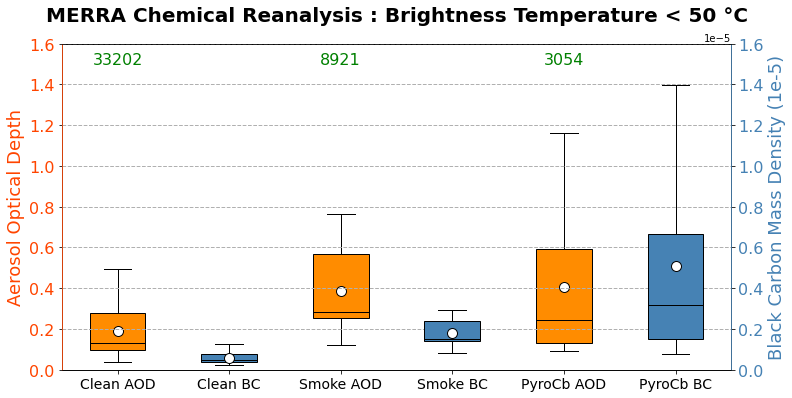

In [159]:
fig, ax = plt.subplots(figsize = (12,6))

degree_sign = u'\N{DEGREE SIGN}'
ax.set_title("MERRA Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 20, y = 1.05) 
ax.set_ylabel("Aerosol Optical Depth", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 16)
plt.ylim(0, 1.6)
plt.yticks(fontsize = 16, color = "orangered")

data =  [m_clean_aod.AODANA, m_smoke_aod.AODANA, m_pyrocb_aod.AODANA]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 2, 4])

yticks2 = np.arange(0, 1.6e-5, 1e-7)
ax2=ax.twinx()

data2 =  [m_clean_bc.BCCMASS, m_smoke_bc.BCCMASS, m_pyrocb_bc.BCCMASS] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [1, 3, 5]) # 

ax2.set_ylabel("Black Carbon Mass Density (1e-5)", color="steelblue",fontsize=18)


plt.annotate("{:.0f}".format(len(m_clean_aod.AODANA)), xy =(0, 1.5e-5), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(m_smoke_aod.AODANA)), xy =(2, 1.5e-5), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_pyrocb_aod.AODANA)), xy =(4, 1.5e-5), fontsize = 16, color = "green", ha='center')

# plt.annotate("{:.0f}".format(len(m_clean_bc.BCCMASS)), xy =(0.5, 1.5e-5), fontsize = 16, color = "green", ha='center')
# plt.annotate("{:.0f}".format(len(m_smoke_bc.BCCMASS)), xy =(2.5, 1.5e-5), fontsize = 16, color = "green", ha='center')
# plt.annotate("{:.0f}".format(len( m_pyrocb_bc.BCCMASS)), xy =(4.5, 1.5e-5), fontsize = 16, color = "green", ha='center')

plt.yticks(fontsize = 16, color = "steelblue")
plt.ylim(0, 1.6e-5)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue',  'steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)

labels = ["Clean AOD",  "Smoke AOD", "PyroCb AOD", "Clean BC", "Smoke BC", "PyroCb BC"]  
ax.set_xticklabels(labels, fontsize = 14)

# green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
# plt.legend(handles=[green_patch], fontsize = 14,loc='lower center', 
#            bbox_to_anchor=(0.5, -0.2), ncol=1, fancybox=True, shadow=False)


plt.grid(linestyle='--', linewidth=1) 
plt.savefig("merra_subplots_allclean.png",bbox_inches = "tight", dpi = 800)
plt.show()


## CAMS Box and Whisker

In [160]:
new1 = pd.read_csv('/data2/edworak/data/nosmoke_lightning_bt_aod.csv', sep = ",") # delim_whitespace = True, 
new1

Unnamed: 0.1  Unnamed: 0  year  month  day  hour  minute     second  \
0                 0          48  2021      6   15    18       5   1.924783   
1                 1         126  2021      6   15    18       5   2.096512   
2                 2         176  2021      6   15    18       5   2.429782   
3                 3         252  2021      6   15    18       5   2.486228   
4                 4         327  2021      6   15    18       5   5.382116   
...             ...         ...   ...    ...  ...   ...     ...        ...   
13162          3728       14838  2021      6   15    23      59  48.000000   
13163          3729       14887  2021      6   15    23      59  49.000000   
13164          3730       14927  2021      6   15    23      59  54.000000   
13165          3731       14945  2021      6   15    23      59  55.000000   
13166          3732       14946  2021      6   15    23      59  56.000000   

         l_lat     l_lon  peak-current C or G    CMI_C14     bt_lat  \
0      53.5947 -114.0116         125.2      G -55.103867  53.612045   
1      53.6018 -113.9254         -10.0      G -58.036560  53.617190   
2      53.6571 -114.0325         -39.8      G -54.146255  53.651413   
3      53.6266 -114.2350         -22.1      G -56.360733  53.683445   
4      53.9393 -113.5184         -13.6      G -56.659990  53.924763   
...        ...       ...           ...    ...        ...        ...   
13162  59.2990 -115.3530         -15.8      G -57.019090  59.314545   
13163  59.3110 -115.2900           7.0      C -58.694916  59.320705   
13164  59.3270 -115.1040           6.1      C -60.251038  59.332714   
13165  53.6360 -115.8750          11.8      C -36.071335  53.622547   
13166  59.9540 -115.5400         -17.3      G -56.181183  59.967537   

           bt_lon  distance(km)    AODANA   lat      lon  distance aod(km)  
0     -114.015620         1.947  0.198896  53.5 -113.750            29.399  
1     -113.939210         1.939  0.198896  53.5 -113.750            20.033  
2     -114.026870         0.733  0.198896  53.5 -113.750            32.199  
3     -114.152504         8.337  0.211558  53.5 -114.375            16.611  
4     -113.517880         1.617  0.222227  54.0 -113.750            25.895  
...           ...           ...       ...   ...      ...               ...  
13162 -115.367620         1.917  0.356707  59.5 -115.625            31.737  
13163 -115.278336         1.266  0.388995  59.5 -115.000            33.460  
13164 -115.099770         0.679  0.388995  59.5 -115.000            14.145  
13165 -115.854290         2.025  0.093921  53.5 -115.625            28.565  
13166 -115.527650         1.655  0.399752  60.0 -115.625             9.706  

[13167 rows x 20 columns]

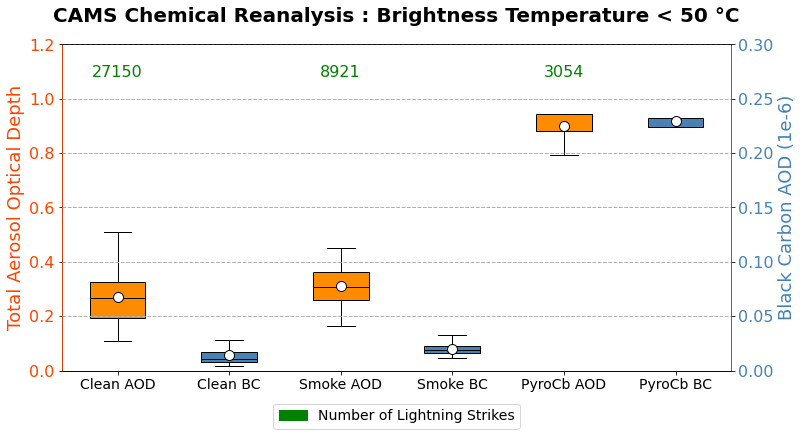

In [161]:
fig, ax = plt.subplots(figsize = (12,6))

#ax.set_title('CAMS AOD and Black Carbon [BT < -50 C]', fontsize = 20, y = 1.05)
degree_sign = u'\N{DEGREE SIGN}'
ax.set_title("CAMS Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 20, y = 1.05) 

ax.set_ylabel("Total Aerosol Optical Depth", color = "orangered", fontsize = 18)

plt.yticks(fontsize = 16)
plt.ylim(0, 1.2)
plt.yticks(fontsize = 16, color = "orangered")

data =  [ c_clean_aod.aod550, c_smoke_aod.aod550, c_pyrocb_aod.aod550]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 2, 4])

yticks2 = np.arange(0, 0.3, 0.01)
ax2=ax.twinx()

data2 =  [c_clean_bc.bcaod550, c_smoke_bc.bcaod550, c_pyrocb_bc.bcaod550] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [1, 3, 5]) # 

ax2.set_ylabel("Black Carbon AOD (1e-6)", color="steelblue",fontsize=18)


plt.annotate("{:.0f}".format(len(c_clean_aod.aod550)), xy =(0, 0.27), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_smoke_aod.aod550)), xy =(2, 0.27), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_pyrocb_aod.aod550)), xy =(4, 0.27), fontsize = 16, color = "green", ha='center')

# plt.annotate("{:.0f}".format(len(c_clean_bc.bcaod550)), xy =(0.5, 0.27), fontsize = 16, color = "green", ha='center')
# plt.annotate("{:.0f}".format(len(c_smoke_bc.bcaod550)), xy =(2.5, 0.27), fontsize = 16, color = "green", ha='center')
# plt.annotate("{:.0f}".format(len(c_pyrocb_bc.bcaod550)), xy =(4.5, 0.27), fontsize = 16, color = "green", ha='center')


plt.yticks(fontsize = 16, color = "steelblue")
plt.ylim(0, 0.3)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue', 'steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = [ "Clean AOD",  "Smoke AOD", "PyroCb AOD", "Clean BC", "Smoke BC", "PyroCb BC"]  
ax.set_xticklabels(labels, fontsize = 14)

green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
plt.legend(handles=[green_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2), ncol=1, fancybox=True, shadow=False)

plt.grid(linestyle='--', linewidth=1) 
plt.savefig("cams_subplots_allclean.png",bbox_inches = "tight", dpi = 800)
plt.show()


## MERRA CAMS BC only 

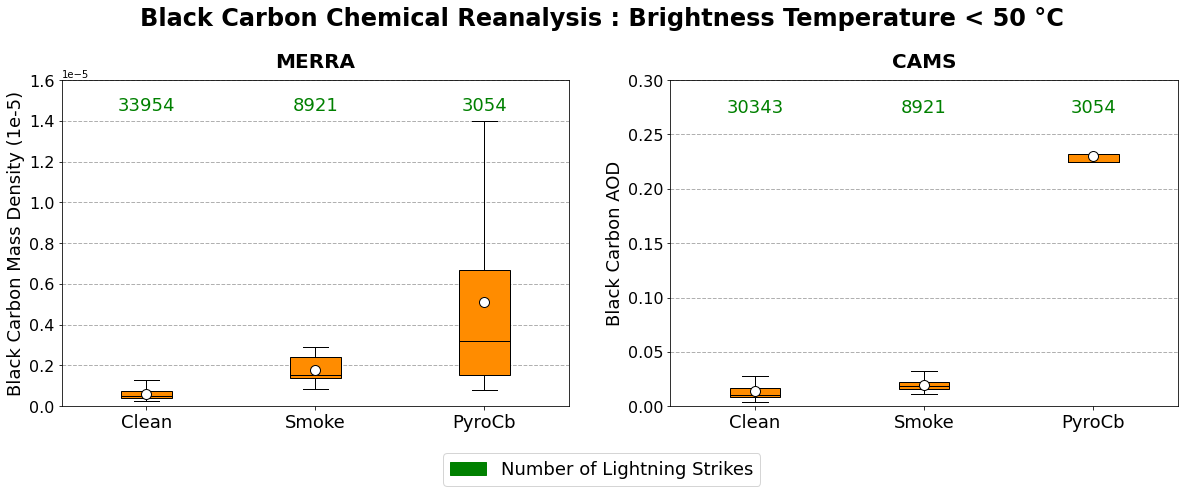

In [166]:
fig = plt.figure(figsize=(20,6))
gs = grd.GridSpec(1, 2, width_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])

degree_sign = u'\N{DEGREE SIGN}'
plt.suptitle("Black Carbon Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 24, y = 1.05) 

ax0.set_title("MERRA", fontsize = 20, fontweight='bold', y = 1.02) 
plt.yticks(fontsize = 16)
plt.ylim(0, 1.6e-5, 1e-7)

data =  [m_clean_bc.BCCMASS, m_smoke_bc.BCCMASS, m_pyrocb_bc.BCCMASS] 
box = ax0.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2]) # 

ax0.set_ylabel("Black Carbon Mass Density (1e-5)", color="black",fontsize=18)

plt.annotate("{:.0f}".format(len(m_clean_bc.BCCMASS)), xy =(0, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(m_smoke_bc.BCCMASS)), xy =(1, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_pyrocb_bc.BCCMASS)), xy =(2, 1.45e-5), fontsize = 18, color = "green", ha='center')

color1 = ['darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box['boxes'], color1):
    patch.set_facecolor(color)

labels = ["Clean", "Smoke", "PyroCb"]  
ax0.set_xticklabels(labels, fontsize = 18)

plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)

# --------------------------------------------------


ax1 = plt.subplot(gs[1])

ax1.set_title("CAMS", fontweight='bold', fontsize = 20, y = 1.02) 

plt.yticks(fontsize = 16)
plt.ylim(0, 0.3, 0.01)
plt.yticks(fontsize = 16)

data =  [c_clean_bc.bcaod550, c_smoke_bc.bcaod550, c_pyrocb_bc.bcaod550] 
box = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2]) # 

ax1.set_ylabel("Black Carbon AOD", fontsize=18)

plt.annotate("{:.0f}".format(len(c_clean_bc.bcaod550)), xy =(0, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_smoke_bc.bcaod550)), xy =(1, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_pyrocb_bc.bcaod550)), xy =(2, 0.27), fontsize = 18, color = "green", ha='center')

color2 = ['darkorange', 'darkorange', 'darkorange']
for patch, color in zip(box['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Clean", "Smoke", "PyroCb"]  
ax1.set_xticklabels(labels, fontsize = 18)

green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
fig.legend(handles=[green_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.08), ncol=1, fancybox=True, shadow=False)

plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)
plt.savefig("cams_merra_bc_subplots_allclean.png",bbox_inches = "tight", dpi = 800)
plt.show()



## clean case boxplots

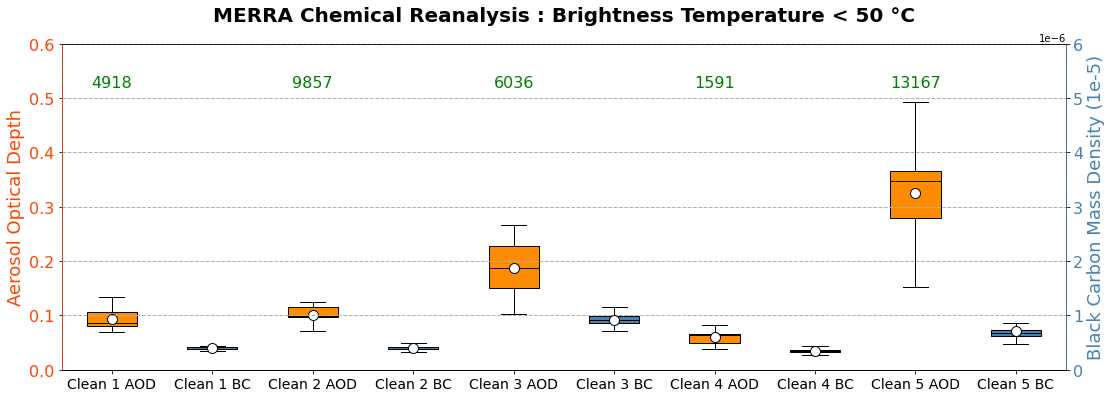

In [163]:
fig, ax = plt.subplots(figsize = (18,6))

degree_sign = u'\N{DEGREE SIGN}'
ax.set_title("MERRA Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 20, y = 1.05) 
ax.set_ylabel("Aerosol Optical Depth", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 16)
plt.ylim(0, 0.6)
plt.yticks(fontsize = 16, color = "orangered")

data =  [m_clean1_aod.AODANA, m_clean2_aod.AODANA, m_clean3_aod.AODANA, m_clean4_aod.AODANA, m_clean5_aod.AODANA]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 2, 4, 6, 8])

yticks2 = np.arange(0, 0.6e-5, 1e-6)
ax2=ax.twinx()

data2 =  [m_clean1_bc.BCCMASS, m_clean2_bc.BCCMASS, m_clean3_bc.BCCMASS, m_clean4_bc.BCCMASS, m_clean5_bc.BCCMASS] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [1, 3, 5, 7, 9]) # 

ax2.set_ylabel("Black Carbon Mass Density (1e-5)", color="steelblue",fontsize=18)


plt.annotate("{:.0f}".format(len(m_clean1_aod.AODANA)), xy =(0, 0.52e-5), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(m_clean2_aod.AODANA)), xy =(2, 0.52e-5), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean3_aod.AODANA)), xy =(4, 0.52e-5), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean4_aod.AODANA)), xy =(6, 0.52e-5), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean5_aod.AODANA)), xy =(8, 0.52e-5), fontsize = 16, color = "green", ha='center')


plt.yticks(fontsize = 16, color = "steelblue")
plt.ylim(0, 0.6e-5)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue',  'steelblue', 'steelblue',  'steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Clean 1 AOD",  "Clean 2 AOD", "Clean 3 AOD", "Clean 4 AOD", "Clean 5 AOD",
          "Clean 1 BC", "Clean 2 BC", "Clean 3 BC", "Clean 4 BC", "Clean 5 BC"]  
ax.set_xticklabels(labels, fontsize = 14)

# green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
# plt.legend(handles=[green_patch], fontsize = 14,loc='lower center', 
#            bbox_to_anchor=(0.5, -0.2), ncol=1, fancybox=True, shadow=False)


plt.grid(linestyle='--', linewidth=1) 
plt.savefig("merra_subplots_seperate_clean.png",bbox_inches = "tight", dpi = 800)
plt.show()


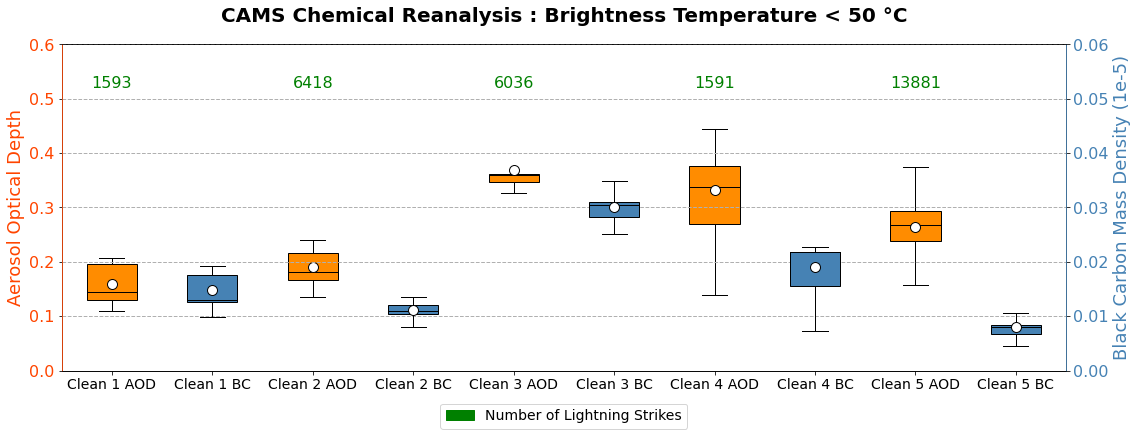

In [164]:
fig, ax = plt.subplots(figsize = (18,6))

degree_sign = u'\N{DEGREE SIGN}'
ax.set_title("CAMS Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 20, y = 1.05) 
ax.set_ylabel("Aerosol Optical Depth", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 16)
plt.ylim(0, 0.6)
plt.yticks(fontsize = 16, color = "orangered")

data =  [c_clean1_aod.aod550, c_clean2_aod.aod550, c_clean3_aod.aod550, c_clean4_aod.aod550, c_clean5_aod.aod550]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 2, 4, 6, 8])

yticks2 = np.arange(0, 0.06, 0.01)
ax2=ax.twinx()

data2 =  [c_clean1_bc.bcaod550, c_clean2_bc.bcaod550, c_clean3_bc.bcaod550, c_clean4_bc.bcaod550, c_clean5_bc.bcaod550] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [1, 3, 5, 7, 9]) # 

ax2.set_ylabel("Black Carbon Mass Density (1e-5)", color="steelblue",fontsize=18)


plt.annotate("{:.0f}".format(len(c_clean1_aod.aod550)), xy =(0, 0.052), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_clean2_aod.aod550)), xy =(2, 0.052), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean3_aod.aod550)), xy =(4, 0.052), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean4_aod.aod550)), xy =(6, 0.052), fontsize = 16, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean5_aod.aod550)), xy =(8, 0.052), fontsize = 16, color = "green", ha='center')


plt.yticks(fontsize = 16, color = "steelblue")
plt.ylim(0, 0.06)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue',  'steelblue', 'steelblue',  'steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Clean 1 AOD",  "Clean 2 AOD", "Clean 3 AOD", "Clean 4 AOD", "Clean 5 AOD",
          "Clean 1 BC", "Clean 2 BC", "Clean 3 BC", "Clean 4 BC", "Clean 5 BC"]  
ax.set_xticklabels(labels, fontsize = 14)

green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
plt.legend(handles=[green_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2), ncol=1, fancybox=True, shadow=False)


plt.grid(linestyle='--', linewidth=1) 
plt.savefig("cams_subplots_seperate_clean.png",bbox_inches = "tight", dpi = 800)
plt.show()


### BC only

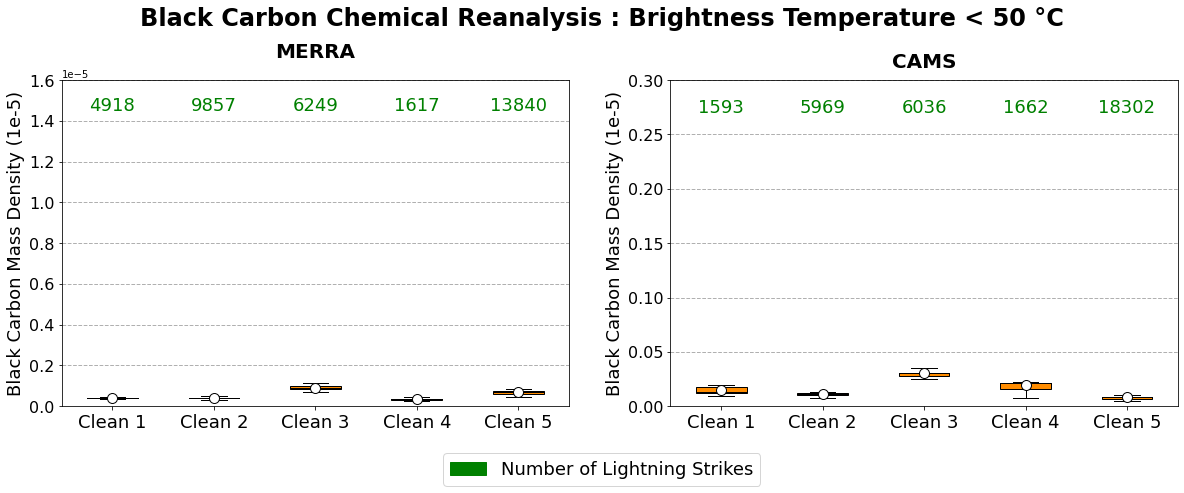

In [167]:
fig = plt.figure(figsize=(20,6))
gs = grd.GridSpec(1, 2, width_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])

degree_sign = u'\N{DEGREE SIGN}'
plt.suptitle("Black Carbon Chemical Reanalysis : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 24, y = 1.05) 

ax0.set_title("MERRA",  fontweight='bold', fontsize = 20, y = 1.05) 
plt.yticks(fontsize = 16)
plt.ylim(0, 1.6e-5, 1e-7)

data = [m_clean1_bc.BCCMASS, m_clean2_bc.BCCMASS, m_clean3_bc.BCCMASS, m_clean4_bc.BCCMASS, m_clean5_bc.BCCMASS] 
box = ax0.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2, 3, 4]) # 

ax0.set_ylabel("Black Carbon Mass Density (1e-5)", fontsize=18)

plt.annotate("{:.0f}".format(len(m_clean1_bc.BCCMASS)), xy =(0, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(m_clean2_bc.BCCMASS)), xy =(1, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean3_bc.BCCMASS)), xy =(2, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean4_bc.BCCMASS)), xy =(3, 1.45e-5), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( m_clean5_bc.BCCMASS)), xy =(4, 1.45e-5), fontsize = 18, color = "green", ha='center')


color1 = ['darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box['boxes'], color1):
    patch.set_facecolor(color)

labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]  
ax0.set_xticklabels(labels, fontsize = 18)
plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)


# --------------------------------------------------

ax1 = plt.subplot(gs[1])

ax1.set_title("CAMS",  fontweight='bold', fontsize = 20, y = 1.02) 
plt.yticks(fontsize = 16)
plt.ylim(0, 0.3, 0.01)

data =  [c_clean1_bc.bcaod550, c_clean2_bc.bcaod550, c_clean3_bc.bcaod550, c_clean4_bc.bcaod550, c_clean5_bc.bcaod550] 
box = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2, 3, 4]) # 

ax1.set_ylabel("Black Carbon Mass Density (1e-5)", fontsize=18)

plt.annotate("{:.0f}".format(len(c_clean1_bc.bcaod550)), xy =(0, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(c_clean2_bc.bcaod550)), xy =(1, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean3_bc.bcaod550)), xy =(2, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean4_bc.bcaod550)), xy =(3, 0.27), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len( c_clean5_bc.bcaod550)), xy =(4, 0.27), fontsize = 18, color = "green", ha='center')

color1 = ['darkorange', 'darkorange', 'darkorange', 'darkorange', 'darkorange'] 
for patch, color in zip(box['boxes'], color1):
    patch.set_facecolor(color)

labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]  
ax1.set_xticklabels(labels, fontsize = 18)

green_patch = mpatches.Patch(color='green', label='Number of Lightning Strikes')
fig.legend(handles=[green_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.08), ncol=1, fancybox=True, shadow=False)


plt.gca().yaxis.grid(True, linestyle='--', linewidth=1)
plt.savefig("cams_merra_bc_subplots_seperate_clean.png",bbox_inches = "tight", dpi = 800)
plt.show()



# Clean Case Search 

In [ ]:
data2 = pd.read_csv("/data2/edworak/data/vaisala_2018_2021/dN4KG_Elena_2019.csv", names = ["Date", "Time", "lat", "lon", "peak current", "C or G"])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_2019 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak current", "C or G"]]

data_2019

In [ ]:
june27_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 27) & (data_2019.lat <= 56)]
june27_2019
june27_pos_ground = june27_2019.loc[(june27_2019["C or G"] == "G") & (june27_2019["peak current"] > 0)]
print(np.mean(june27_pos_ground["peak current"]))
june27_neg_ground = june27_2019.loc[(june27_2019["C or G"] == "G") & (june27_2019["peak current"] < 0)]
print(np.mean(june27_neg_ground["peak current"]))
june27_perc_pos = len(june27_pos_ground) / (len(june27_pos_ground) + len(june27_neg_ground)) * 100
june27_cloud = june27_2019.loc[(june27_2019["C or G"] == "C")]
print(len(june27_cloud) / (len(june27_pos_ground) + len(june27_neg_ground)))

In [ ]:
june19_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 19)& (data_2019.lat <= 56)]
june19_pos_ground = june19_2019.loc[(june19_2019["C or G"] == "G") & (june19_2019["peak current"] > 0)]
print(np.mean(june19_pos_ground["peak current"]))
june19_neg_ground = june19_2019.loc[(june19_2019["C or G"] == "G") & (june19_2019["peak current"] < 0)]
print(np.mean(june19_neg_ground["peak current"]))
june19_perc_pos = len(june19_pos_ground) / (len(june19_pos_ground) + len(june19_neg_ground)) * 100
june19_cloud = june19_2019.loc[(june19_2019["C or G"] == "C")]
print(len(june19_cloud) / (len(june19_pos_ground) + len(june19_neg_ground)))


In [ ]:
june13_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 13) & (data_2019.lat <= 57)]
june13_pos_ground = june13_2019.loc[(june13_2019["C or G"] == "G") & (june13_2019["peak current"] > 0)]
print(np.mean(june13_pos_ground["peak current"]))
june13_neg_ground = june13_2019.loc[(june13_2019["C or G"] == "G") & (june13_2019["peak current"] < 0)]
print(np.mean(june13_neg_ground["peak current"]))
june13_perc_pos = len(june13_pos_ground) / (len(june13_pos_ground) + len(june13_neg_ground)) * 100
june13_cloud = june13_2019.loc[(june13_2019["C or G"] == "C")]
print(len(june13_cloud) / (len(june13_pos_ground) + len(june13_neg_ground)))

In [ ]:
all_pos_ground = data_2019.loc[(data_2019.month == 6) &(data_2019["C or G"] == "G") & (data_2019["peak current"] > 0) ]
print(all_pos_ground["peak current"].values)
all_neg_ground = data_2019.loc[(data_2019.month == 6) &(data_2019["C or G"] == "G") & (data_2019["peak current"] < 0) ]
print(np.mean(all_neg_ground["peak current"]))
all_perc_pos = len(all_pos_ground) / (len(all_pos_ground) + len(all_neg_ground)) * 100
all_cloud = data_2019.loc[(data_2019["C or G"] == "C")]
print(len(all_cloud) / (len(all_pos_ground) + len(all_neg_ground)))

In [ ]:
fig, ax = plt.subplots(figsize = (22,6))

ax.set_title('2019 British Columbia CG Lightning', fontsize = 24, y = 1.05)
ax.set_ylabel("Peak Current", color = "orangered", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 20, color = "orangered")
    
data =  [abs(june13_cloud["peak current"].values), june13_pos_ground["peak current"].values, 
         abs(june19_cloud["peak current"].values), june19_pos_ground["peak current"].values, 
         abs(june27_cloud["peak current"].values), june27_pos_ground["peak current"].values]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 3, 4, 6, 7])

plt.annotate("{:.0f}".format(len(june13_cloud["peak current"])), xy =(0, 65), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(june19_cloud["peak current"])), xy =(3, 65), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(june27_cloud["peak current"])), xy =(6, 65), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(june13_perc_pos), xy =(1, 72), fontsize = 18, color = "violet", ha='center')
plt.annotate("{:.0f}%".format(june19_perc_pos), xy =(4, 72), fontsize = 18, color = "violet", ha='center')
plt.annotate("{:.0f}%".format(june27_perc_pos), xy =(7, 72), fontsize = 18, color = "violet", ha='center')

plt.annotate("{:.0f}".format(len(june13_pos_ground["peak current"])), xy =(1, 65), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(june19_pos_ground["peak current"])), xy =(4, 65), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(june27_pos_ground["peak current"])), xy =(7, 65), fontsize = 18, color = "green", ha='center')

yticks2 = np.arange(0, 80, 8)
ax2=ax.twinx()

data2 =  [ abs(june13_neg_ground["peak current"].values), abs(june19_neg_ground["peak current"].values), 
          abs(june27_neg_ground["peak current"].values)] 

box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2, 5, 8]) #

ax2.set_ylabel("Negative Peak current", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 80)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')


plt.annotate("{:.0f}".format(len(june13_neg_ground["peak current"])), xy =(2, 65), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(june19_neg_ground["peak current"])), xy =(5, 65), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(june27_neg_ground["peak current"])), xy =(8, 65), fontsize = 18, color = "green", ha='center')


color1 = ['lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange'] # , 'lightgray', 'darkorange'
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue'] # , 'steelblue'
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["June 13 CC", "June 13 +CG",  "June 19 CC", "June 19 +CG",  "June 27 CC", "June 27 +CG", 
          "June 13 -CG", "June 19 -CG",  "June 27 -CG"]  
ax.set_xticklabels(labels, fontsize = 12)

plt.grid(linestyle='--', linewidth=1) 
plt.savefig("lightning_2019_subplots2.png",bbox_inches = "tight", dpi = 800)
plt.show()


## June 13 2019 (DOY 164)

In [ ]:
fig = plt.figure(figsize=(8, 6))

path = '/data2/edworak/data/br_temp_2019//201916619/OR_ABI-L2-MCMIPF-M6_G17_s20191661950341_e20191661959420_c20191661959482.nc'
# FILE = path + file_names[i][j]
data = xarray.open_dataset(path)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y
# ------------------------------------------------------------------------------------------------------

pc = ccrs.LambertConformal()

ax = fig.add_subplot(1, 1, 1, projection=pc)
ax.set_extent([-135, -105, 48, 64], ccrs.PlateCarree())

ax.coastlines(resolution='50m', color='black', linewidth=1.0)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'


gl = ax.gridlines(draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)

gl.xlocator = mticker.FixedLocator([ -130,  -125,  -120,  -115,  -110, -105])

gl.ylocator = mticker.FixedLocator([50,  55, 60, 65])
gl.left_labels = gl.top_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 0, 'size': 16, 'color': 'black'}
gl.ylabel_style = {'rotation': 0, 'size': 16, 'color': 'black'} #, 'weight': 'bold'

colormap = LinearSegmentedColormap.from_list('custom', 
                               [#(0, "darkviolet"), 
                                (0, "darkviolet"), 
                                (0.1, "red"), 
                                (0.2, "yellow"),
                                (0.3, "cornflowerblue"),
                                (0.4, "lightsteelblue"), 
                                (0.5, 'white'),
                                (0.8, 'lightgrey'), 
                                (1.0, 'darkgrey'), 
                                ], N=30)

im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

# [left, bottom, width, height]
cax = plt.axes([0.15, -0.1, 0.7, 0.03])

#, im, extend='both', cax=cax 
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(16)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-40', '-30','-20', '-10', '0', '10', '20', '30']) 
# tstorm_subregion_box(ax, im)

plt.tight_layout()
#plt.subplots_adjust(hspace=0.3, wspace=0.2) 
plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_nosmoke_MAP_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 6))

FILE = "/data2/edworak/data/br_temp_2019/201916402/OR_ABI-L2-MCMIPF-M6_G17_s20191640200339_e20191640209412_c20191640209480.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y
# ------------------------------------------------------------------------------------------------------

pc = ccrs.PlateCarree()

#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=pc)
ax.set_extent([-125, -110, 50, 58], crs=pc)

ax.coastlines(resolution='50m', color='black', linewidth=1.0)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -124,  -122,  -120,  -118, -116, -114])

gl.ylocator = mticker.FixedLocator([52, 54, 56, 58])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

colormap = LinearSegmentedColormap.from_list('custom', 
                                        [#(0, "darkviolet"), 
                                        (0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                        (0.25, "cornflowerblue"), 
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        ], N=30)


im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
points = june19_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 13) & (data_2019.hour == 2)]
ax.scatter(x = points.lon, y = points.lat, s = 1, color = "black", marker = "o", alpha = 0.8)

# [left, bottom, width, height]
cax = plt.axes([0.15, 0, 0.7, 0.03])

#, im, extend='both', cax=cax 
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(18)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

plt.tight_layout()
# plt.suptitle('June 13 2019', fontweight='bold', fontsize=20, y = 0.95)
#plt.savefig("BT_smoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
FILE = "/data2/edworak/data/br_temp_2019/201915922/OR_ABI-L2-MCMIPF-M6_G17_s20191592200339_e20191592209406_c20191592209478.nc"

data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y
# ------------------------------------------------------------------------------------------------------

pc = ccrs.PlateCarree()

#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=pc)
ax.set_extent([-125, -110, 50, 58], crs=pc)

ax.coastlines(resolution='50m', color='black', linewidth=1.0)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -124,  -122,  -120,  -118, -116, -114])

gl.ylocator = mticker.FixedLocator([52, 54, 56, 58])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

colormap = LinearSegmentedColormap.from_list('custom', 
                                        [#(0, "darkviolet"), 
                                        (0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                        (0.25, "cornflowerblue"), 
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        ], N=30)


im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
points = june19_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 8) & (data_2019.hour == 22)]

ax.scatter(x = points.lon, y = points.lat, s = 1, color = "black", marker = "o", alpha = 0.8)

# [left, bottom, width, height]
cax = plt.axes([0.15, 0, 0.7, 0.03])

#, im, extend='both', cax=cax 
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(18)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

plt.tight_layout()
# plt.suptitle('June 13 2019', fontweight='bold', fontsize=20, y = 0.95)
#plt.savefig("BT_smoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()
